In [1]:
import torch
import matplotlib.pyplot as plt
import os

In [2]:
10

10

In [3]:
os.environ["TORCH_HOME"] = "./torhchub"

In [4]:
# !pip install imageiopip install gdown
!pip install gdown

In [5]:
!gdown 1vbYawI5z1Faz4TqfsW-q_OlSbbLlmust

Downloading...
From (original): https://drive.google.com/uc?id=1vbYawI5z1Faz4TqfsW-q_OlSbbLlmust
From (redirected): https://drive.google.com/uc?id=1vbYawI5z1Faz4TqfsW-q_OlSbbLlmust&confirm=t&uuid=24d1f80f-e3e0-4b0f-85a0-c07cdf46a74d
To: /scratch/cvlab/home/durasov/projects/ittt/exps/age/utkface.zip
100%|█████████████████████████████████████████| 122M/122M [00:00<00:00, 166MB/s]


In [8]:
!unzip utkface.zip

Archive:  utkface.zip
   creating: UTKFace/
  inflating: UTKFace/4_1_0_20170109191240933.jpg.chip.jpg  
  inflating: UTKFace/1_0_2_20161219200427051.jpg.chip.jpg  
  inflating: UTKFace/1_1_3_20161219225640200.jpg.chip.jpg  
  inflating: UTKFace/60_1_1_20170113185146864.jpg.chip.jpg  
  inflating: UTKFace/32_1_3_20170119200442740.jpg.chip.jpg  
  inflating: UTKFace/34_1_1_20170113011657832.jpg.chip.jpg  
  inflating: UTKFace/26_0_3_20170119160406155.jpg.chip.jpg  
  inflating: UTKFace/45_0_1_20170117172020917.jpg.chip.jpg  
  inflating: UTKFace/73_1_0_20170110141055369.jpg.chip.jpg  
  inflating: UTKFace/36_0_3_20170119191815385.jpg.chip.jpg  
  inflating: UTKFace/70_1_1_20170119205140215.jpg.chip.jpg  
  inflating: UTKFace/28_1_1_20170117121917805.jpg.chip.jpg  
  inflating: UTKFace/39_0_1_20170113135644306.jpg.chip.jpg  
  inflating: UTKFace/40_1_1_20170113000039241.jpg.chip.jpg  
  inflating: UTKFace/1_1_0_20170109190937434.jpg.chip.jpg  
  inflating: UTKFace/60_1_0_20170110140707890

In [9]:
import imageio
import random

In [10]:
import os
from typing import Optional
from glob import glob
import numpy as np
# import imageio.v2 as imageio
# import imageio
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
# import albumentations as A
import tqdm
from PIL import Image

from models import *

import argparse
import glob

NORM_PARAM = 50

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),    
])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(),
    transforms.RandomResizedCrop(size=200, scale=(0.5, 1.0)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),    # ImageNet-pretrain transform
])


class UTKFaceDataset(torch.utils.data.Dataset):

    class2gender = {
        0: 'Male',
        1: 'Female'
    }

    class2race = {
        0: 'White',
        1: 'Black',
        2: 'Asian',
        3: 'Indian',
        4: 'Others'
    }

    def __init__(self, root, split_root, partition, transform=None, const=False):
        """
        The dataset must have the following structure:
        
        <root>/<filename>.jpg, where <filename> = "[age]_[gender]_[race]_[date&time].jpg"
        <split_root>/<partition>_names.txt, where <partition> is given as a keyword argument to __init__ 
            and typically is one of: "train", "val", "holdout". 
            The file contains basenames separated by a newline.

        NB: landmarks reading is not supported yet.
        """
        super().__init__()

        self.root = root
        self.const = const
        self.transform = transform
        self.short_names = open(os.path.join(split_root, f"{partition}_names.txt")).readlines()
        self.short_names = [name.strip() for name in self.short_names if name]
        self.filenames = [os.path.join(root, name) for name in self.short_names]
        self.filenames = [full_name for full_name in self.filenames if os.path.exists(full_name)]
        print('filenames before extension:', len(self.filenames))
        
        self.samples = []

#         print("Preloading files...")
#         for fn in self.filenames:
#             #fn = self.filenames[idx]
#             img = np.array(imageio.imread(fn))
#             img = img.astype(np.float32) / 255.0
#             age = fn.split("/")[-1].split("_")[0]
#             age = int(age)
                        
#             self.samples.append((fn, img, age))

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        
        fn = self.filenames[idx]
        img = np.array(imageio.imread(fn))
        img = img.astype(np.float32) / 255.0
        age = fn.split("/")[-1].split("_")[0]
        age = int(age)
        
#         fn, img, age = self.samples[idx]
        
        if self.transform:
            img = self.transform(img)
            
        t = torch.ones([1, 200, 200])
        const = (random.random() < 0.5) or self.const
        if const:
            t *= -50
        else:
            t *= age
            
        img = torch.cat([img, t / NORM_PARAM])

        return img, {"age" : age, "name" : fn}
    
    
class CartoonDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, transform, const=False):
        self.filenames = glob.glob(root + "*")
        self.transform = transform
        self.const = const
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):

        fn = self.filenames[idx]
#         img = imageio.imread(fn)
        img = Image.open(fn)
        img = transforms.Resize([200, 200])(img)
        img = np.array(img)
        img = img.astype(np.float32) / 255.0
        
        if len(img.shape) < 3:
            img = img[:, :, None]
            img = np.tile(img, [1, 1, 3])
            
        if img.shape[2] > 3:
            img = img[:, :, :3]
            
        if img.shape[2] == 1:
            img = np.tile(img, [1, 1, 3])
            
        img = img.astype("float")
        assert img.shape == (200, 200, 3), f"{img.shape} {fn}"

        if self.transform:
            img = self.transform(img)
            
        t = torch.ones([1, 200, 200])
        const = (random.random() < 0.5) or self.const
        if const:
            t *= -50
        else:
            t *= age
            
        img = torch.cat([img, t / NORM_PARAM])

        return img, {"age" : 42, "name" : fn}
    
# utk_face_dir = "../../../single_shot_uncertainty/faces/UTKFace"
# splits_dir = "../../../single_shot_uncertainty/faces/splits"
# cartoons_faces_dir = "/cvlabdata2/home/durasov/projects/single_shot_uncertainty/faces/CartoonFaces/personai_icartoonface_rectest/icartoonface_rectest/"

# test_data = UTKFaceDataset(root=utk_face_dir, split_root=splits_dir, partition="ages_test", transform=transform_test)
# train_data = UTKFaceDataset(root=utk_face_dir, split_root=splits_dir, partition="ages_train", transform=transform_train)
# ood_age = UTKFaceDataset(root=utk_face_dir, split_root="./splits", partition="ages_ood", transform=transform_test)
# ood_data = CartoonDataset(cartoons_faces_dir, transform=transform_test)

In [11]:
utk_face_dir = "./UTKFace"
splits_dir = "./splits"
# cartoons_faces_dir = "/cvlabdata2/home/durasov/projects/single_shot_uncertainty/faces/CartoonFaces/personai_icartoonface_rectest/icartoonface_rectest/"

train_data = UTKFaceDataset(root=utk_face_dir, split_root=splits_dir, partition="ages_train", transform=transform_train, const=False)
test_data = UTKFaceDataset(root=utk_face_dir, split_root=splits_dir, partition="ages_test", transform=transform_test, const=True)
ood_age = UTKFaceDataset(root=utk_face_dir, split_root=splits_dir, partition="ages_ood", transform=transform_test, const=True)
# ood_data = CartoonDataset(cartoons_faces_dir, transform=transform_test, const=True)
print("Done!")

filenames before extension: 13144
filenames before extension: 3287
filenames before extension: 7274
Done!


In [12]:
# test_data = UTKFaceDataset(root=utk_face_dir, split_root=splits_dir, partition="ages_test", transform=transform_test, const=True)

In [13]:
from tqdm import tqdm
from torch.utils.data import Dataset, Subset

indexes = []
for i in tqdm(range(len(ood_age)), total=len(ood_age)):
    fn = ood_age.filenames[i]
    age = fn.split("/")[-1].split("_")[0]
    age = int(age)
    if age >= 50 and age <= 70:
        indexes.append(i)    
    elif age >= 10 and age <= 20:
        indexes.append(i)     

ood_50_age = Subset(ood_age, indexes)

100%|██████████| 7274/7274 [00:00<00:00, 582940.70it/s]


In [14]:
# for i in range(50, 100):
#     s = ood_age[i]
#     if s[1]["age"] >= 50:
#         print(i)

In [15]:
# import numpy as np

# def inverse_normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
#     # Convert the mean and std lists to NumPy arrays
#     mean = np.array(mean)
#     std = np.array(std)
    
#     # Inverse the normalization: multiply by std and add mean
#     image = image * std[:, None, None] + mean[:, None, None]
#     return image

In [16]:



# i = 56
# s = test_data[i]
# img = inverse_normalize(s[0][:-1]).permute(1, 2, 0).numpy()[:-1]
# plt.figure(figsize=(5,5))
# plt.imshow(img)
# plt.axis("off")
# plt.tight_layout()
# plt.savefig(f"viz/age_img_test_{i}.png", format="png")

In [17]:
#58
#59
#60
#62
#65
#66

# i = 66
# s = ood_age[i]
# img = inverse_normalize(s[0][:-1]).permute(1, 2, 0).numpy()[:-1]
# plt.figure(figsize=(5,5))
# plt.imshow(img)
# plt.axis("off")
# plt.tight_layout()
# plt.savefig(f"viz/age_img_young_{i}.png", format="png")

In [18]:
# 52
# 54
# 57
# 61
# 63
# 64

# i = 64
# s = ood_age[i]
# img = inverse_normalize(s[0][:-1]).permute(1, 2, 0).numpy()[:-1]
# plt.figure(figsize=(5,5))
# plt.imshow(img)
# plt.axis("off")
# plt.tight_layout()
# plt.savefig(f"viz/age_img_old_{i}.png", format="png")

## Visualize Train / Test / OOD

In [19]:
train_ages = [train_data[idx][1]["age"] for idx in range(0, 10000, 100)]
test_ages = [test_data[idx][1]["age"] for idx in range(0, 3000, 100)]
ood_ages = [ood_age[idx][1]["age"] for idx in range(0, 7000, 100)]

/tmp/ipykernel_14047/4054332298.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = np.array(imageio.imread(fn))


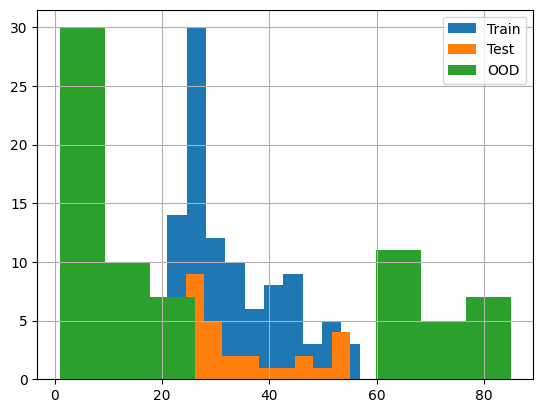

In [20]:
import matplotlib.pyplot as plt
plt.hist(train_ages, label="Train")
plt.hist(test_ages, label="Test")
plt.hist(ood_ages, label="OOD")

plt.legend()
plt.grid()
plt.show()

# Evaluate Vanilla Model

In [21]:
# import torch
# import torchvision
# import numpy as np
# import random
# import tqdm
# import models
# import imageio

# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# class Args:
#     pass

# args = Args()
# args.weights = "./weights/pretrained_zigzag.pth"

# n_epochs = 15
# batch_size_train = 8
# batch_size_test = 8
# learning_rate = 1e-3
# momentum = 0.5
# log_interval = 100
# class_num = 1 #20

# device = "cuda"

# random_seed = 42
# torch.backends.cudnn.enabled = False
# torch.manual_seed(random_seed)

# torch.manual_seed(random_seed)
# random.seed(random_seed)

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True, num_workers=batch_size_train)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False, num_workers=batch_size_test)
# ood_loader = torch.utils.data.DataLoader(ood_age, batch_size=batch_size_test, shuffle=False, num_workers=batch_size_test)

# network = models.NoiseNet(class_num, init_ch=4).to(device)
# network.load_state_dict(torch.load(args.weights))
# network.eval()
# # optimizer = optim.Adam(network.parameters(), lr=learning_rate)

# train_losses = []
# train_counter = []
# test_losses = []
# test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# min_age = 0 # 20
# max_age = 80 # 60

# def SigmaLoss(outputs, target):
#     sigma = torch.nn.functional.elu(outputs[:, 1]) + 1.2
#     return ((outputs[:, 0] - target) ** 2 / sigma + torch.log(sigma)).mean()

# def year2bins(age):
#     # bins = np.linspace(20, 60, class_num).astype("int")
#     bins = np.linspace(min_age, max_age, class_num).astype("int")
#     classes = np.digitize(age.cpu(), bins, right=True) - 1
#     return torch.tensor(classes).to(age.device)

# def train(epoch):
#     i = 0
#     correct = 0 
#     network.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         optimizer.zero_grad()
#         target = target["age"].to(device).long()
#         transformed_ages = year2bins(target)

#         data = data.to(device)
#         output = network(data)
#         loss = torch.nn.CrossEntropyLoss()(output, transformed_ages)
#         loss.backward()
#         optimizer.step()

#         pred = output.data.max(1, keepdim=True)[1][:, 0]
#         c = (transformed_ages == pred).sum()
#         correct += c

#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Acc {:.3f}'.format(
#             epoch, batch_idx * len(data), len(train_loader.dataset),
#             100. * batch_idx / len(train_loader), loss.item(), c.item() / batch_size_train))
#             train_losses.append(loss.cpu().item())
            
#     network.eval()

# def trainMAE(epoch):
#     i = 0
#     correct = 0 
#     mean_loss = 0

#     network.train()
#     for batch_idx, (data, target) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
#         optimizer.zero_grad()
#         target = target["age"].to(device).float()[:, None]
#         data = data.to(device)
#         output = network(data)
#         # loss = torch.nn.L1Loss()(output, target)
#         loss = SigmaLoss(output, target[:, 0])
#         loss.backward()
#         optimizer.step()
#         mean_loss += loss.cpu().detach()
    
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} MLoss {:.3f}'.format(
#             epoch, batch_idx * len(data), len(train_loader.dataset),
#             100. * batch_idx / len(train_loader), loss.item(), mean_loss / (batch_idx + 1)))
#             train_losses.append(loss.cpu().item())
#     network.eval()

# def age_regression(output, pow=1):
#     prob = torch.nn.functional.softmax(output, dim=1)
#     bins = np.linspace(min_age, max_age, class_num).astype("int")
#     range_x = torch.tensor((bins[1:] + bins[:-1]) / 2).to(device)
#     result = (range_x[None] ** pow * prob).sum(dim=1)
#     # result = range_x[output.argmax(dim=1).cpu()]
#     #return torch.tensor(result).to(device).float()
#     return result.float()

# def testMAE(dataloader):
#     loss_fn = lambda x, y: torch.abs(x - y).sum()
#     network.eval()
#     test_loss = 0
#     correct = 0
    
#     targets = []
#     errors = []
#     with torch.no_grad():
#         for data, target in tqdm.tqdm(dataloader, total=len(dataloader)):
#             data = data.to(device)
#             pred = network(data)
#             data[:, [-1]] = pred[:, :, None, None].tile([1, 1, 200, 200]) / NORM_PARAM #.cpu()
#             pred_w = network(data.cuda())
#             output = pred_w #(pred + pred_w) / 2
#             target = target["age"].to(device).float()
# #             tl = torch.nn.L1Loss(reduction = 'sum')(output[:, 0], target).cpu()
#             tl = torch.abs(output[:, 0] - target).cpu()
#             #print(tl.shape, output[:, 0].shape, target.shape)
#             #print(output[:, 0], target)
#             targets += target.cpu().tolist()
#             errors += tl.tolist()
            
#             test_loss += tl.mean()
#         test_loss /= len(test_loader.dataset)
#         test_losses.append(test_loss)
#         print("TEST MAE: ", test_loss)
#     return test_loss, targets, errors

# def test2MAE(dataloader):
#     loss_fn = lambda x, y: torch.abs(x - y).sum()
#     network.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in tqdm.tqdm(dataloader, total=len(dataloader)):
#             data = data.to(device)
#             data[:, [-1]] = target["age"][:, None, None, None].float().tile([1, 1, 200, 200]).cuda() / NORM_PARAM
#             pred = network(data.cuda())
#             output = pred
#             target = target["age"].to(device).float()
#             test_loss += torch.nn.L1Loss(reduction = 'sum')(output[:, 0], target).cpu()
#         test_loss /= len(test_loader.dataset)
#         test_losses.append(test_loss)
#         print("TEST MAE: ", test_loss)
#     return test_loss

# def test():
#     loss_fn = lambda x, y: torch.abs(x - y).sum()
#     network.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in tqdm.tqdm(test_loader, total=len(test_loader)):
#             data = data.to(device)
#             output = age_regression(network(data))
#             target = target["age"].to(device)
#             test_loss += loss_fn(output, target).cpu()
#         test_loss /= len(test_loader.dataset)
#         test_losses.append(test_loss)
#         print("TEST MAE: ", test_loss)
#     return test_loss

In [22]:
# test_result, targets, errors = testMAE(test_loader)

In [23]:
# len(errors), len(targets), np.mean(errors)

In [24]:
# train_result = testMAE(train_loader)

In [25]:
# ood_result, ood_targets, ood_errors = testMAE(ood_loader)

In [26]:
# ood_errors_array = np.array(ood_errors)
# ood_targets_array = np.array(ood_targets)

# ood_errors_old_array = ood_errors_array[ood_targets_array >= 50]
# ood_targets_old_array = ood_targets_array[ood_targets_array >= 50]

In [27]:
# ood_errors_array[ood_targets_array >= 50].mean(), ood_errors_array[ood_targets_array <= 40].mean()

In [28]:


# args = Args()
# args.weights = "/cvlabdata2/home/durasov/projects/single_shot_uncertainty/faces/weights/with_sigma_reg_wo_unc_1.pth"

# class_num = 2
# network = Net(class_num).to(device)
# network.load_state_dict(torch.load(args.weights))
# network = network.eval()

# Vanilla Model

In [29]:
import torch
import torch.optim as optim
import gc
import tqdm

import models
from models import *

n_epochs = 15
batch_size_train = 4
batch_size_test = 16
learning_rate = 1e-3
momentum = 0.5
log_interval = 100

device = "cuda"

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

ood_loader = torch.utils.data.DataLoader(ood_50_age, batch_size=batch_size_test, shuffle=False, num_workers=batch_size_test)

class Args:
    pass

args = Args()
args.weights = "./weights/pretrained_zigzag.pth"

class_num = 1
zigzag_network = models.NoiseNet(class_num, init_ch=4).to(device)
zigzag_network.load_state_dict(torch.load(args.weights))
zigzag_network = zigzag_network.eval()

# def zigzag_unc(network, old_network, data):
#     pred = network(data)
#     old_network.eval()
#     copy_data = data.clone()  # Shallow copy of the input tensor
#     copy_data[:, [-1]] = pred[:, :, None, None].tile([1, 1, 200, 200]) / NORM_PARAM
#     pred_w = old_network(copy_data)
    
#     # Detach tensors to avoid holding onto computation graphs, and move them to the CPU
#     return torch.abs(pred - pred_w).mean().cpu(), pred.cpu(), pred_w.cpu()

# def ttt_one_instance(x, f_ttt, f, optimizer, n_steps, n_classes=10):
#     f_ttt.load_state_dict(f.state_dict())  # Reset f_ttt to f
#     f_ttt.train()
#     f.eval()
    
#     for step in range(n_steps):
#         loss, y_1, y_2 = zigzag_unc(f_ttt, f, x)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     f_ttt.eval()
#     with torch.no_grad():
#         _, y_1, y_2 = zigzag_unc(f_ttt, f, x)
    
#     return y_1, y_2

# def set_batchnorm_tracking(model, track=False):
#     for module in model.modules():
#         if isinstance(module, torch.nn.BatchNorm2d):
#             module.track_running_stats = track
#         elif isinstance(module, torch.nn.BatchNorm1d):
#             module.track_running_stats = track
            
# def freeze_batchnorm_params(model):
#     for module in model.modules():
#         if isinstance(module, torch.nn.BatchNorm2d) or isinstance(module, torch.nn.BatchNorm1d):
#             # Disable statistics tracking
#             module.track_running_stats = False
#             # Freeze parameters
#             module.weight.requires_grad = False
#             module.bias.requires_grad = False
            
# # Assume 'model' is your NoiseNet instance
# def get_fully_connected_params(model):
#     params = []
#     for name, param in model.named_parameters():
#         if 'fc' in name:  # Only include parameters from fully connected layers
#             params.append(param)
#     return params

def vanilla_eval(f, test_loader):
    # Set f in evaluation mode
    f.eval()
    # f_ttt = models.NoiseNet(class_num, init_ch=4).to(device).train()
    # f_ttt.load_state_dict(f.state_dict())
    
    # Pre-allocate storage for errors and targets
    errors = []
    targets = []
    preds = []
    
    # Progress bar setup
    t = tqdm.trange(len(test_loader), desc='Current Loss = ', leave=True)
    
        # Reset f_ttt weights to match the original model
    
    # set_batchnorm_tracking(f_ttt, False)
    # freeze_batchnorm_params(f_ttt)
    
#     fc_params = get_fully_connected_params(f_ttt)
#     optimizer = optim.Adam(fc_params, lr=lr)
    
    # optimizer = optim.Adam(f_ttt.parameters(), lr=lr)
#     optimizer = optim.SGD(f_ttt.parameters(), lr=lr, momentum=0.9)
    
    #for data, target in tqdm.tqdm(test_loader, total=len(test_loader)):
    for _, (data, target) in zip(t, test_loader):
        data = data.to(device)
        
        # Reuse f_ttt and optimizer for every batch
        #f_ttt = models.NoiseNet(class_num, init_ch=4).to(device).train()
#         set_batchnorm_tracking(f_ttt, False)
#         freeze_batchnorm_params(f_ttt)
        
#         fc_params = get_fully_connected_params(f_ttt)
#         optimizer = optim.Adam(fc_params, lr=lr)
       
        # Perform the adaptation (TTT) on one instance
        pred = f(data) #ttt_one_instance(data, f_ttt, f, optimizer, n_steps)
        
        # Move predictions to CPU and detach from computation graph
        output = pred.detach().cpu() # pred_w.detach().cpu()
        
        # Process the target and calculate errors
        target = target["age"].cpu().float()
        tl = torch.abs(output[:, 0] - target).cpu()
        
        # Store results
        targets += target.tolist()
        errors += tl.tolist()
        preds += output[:, 0].tolist()

        # Clear unused variables
        del data, pred
        gc.collect()  # Trigger garbage collection
        torch.cuda.empty_cache()  # Free up cached memory on the GPU

        # Update progress bar
        t.set_description(f"Current Loss = {sum(errors) / len(errors)}", refresh=True)

    return np.array(errors), np.array(targets), np.array(preds)

# Run the training process
errors, targets, preds = vanilla_eval(zigzag_network, ood_loader)

ood_errors_array = np.array(errors)
ood_targets_array = np.array(targets)
# ood_preds_array = np.array(preds)

ood_errors_old_array = ood_errors_array[ood_targets_array >= 50]
ood_targets_old_array = ood_targets_array[ood_targets_array >= 50]
# ood_preds_old_array = ood_preds_array[ood_targets_array >= 50]

ood_errors_young_array = ood_errors_array[ood_targets_array < 20]
ood_targets_young_array = ood_targets_array[ood_targets_array < 20]
# ood_preds_young_array = ood_preds_array[ood_targets_array < 25]

sorting_indices = np.argsort(ood_targets_old_array)
sorted_ood_errors_old = ood_errors_old_array[sorting_indices]
splitted_ood_errors_old = np.array_split(sorted_ood_errors_old, 4)

sorting_indices = np.argsort(ood_targets_young_array)
sorted_ood_errors_young = ood_errors_young_array[sorting_indices]
splitted_ood_errors_young = np.array_split(sorted_ood_errors_young, 4)[::-1]

res = []
for x, y in zip(splitted_ood_errors_old, splitted_ood_errors_young):
    res.append(x.tolist() + y.tolist())

Using cache found in ./torhchub/hub/pytorch_vision_v0.10.0
/scratch/cvlab/home/durasov/miniconda/envs/ittt/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/cvlab/home/durasov/miniconda/envs/ittt/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/scratch/cvlab/home/durasov/miniconda/envs/ittt/lib/python3.8/site-packages/torch/hub.py:746: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME 

In [30]:
NOT_OPTIMIZED = [t for s in res for t in s]

# ITTT Eval

In [31]:
import torch
import torch.optim as optim
import gc
import tqdm

import models
from models import *

n_epochs = 15
batch_size_train = 4
# batch_size_test = 4
learning_rate = 1e-3
momentum = 0.5
log_interval = 100

device = "cuda"

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

ittt_results = {}
for bs in [4, 8, 16]:

    ood_loader = torch.utils.data.DataLoader(ood_50_age, batch_size=bs, shuffle=False, num_workers=bs)
    
    class Args:
        pass
    
    args = Args()
    args.weights = "./weights/pretrained_zigzag.pth"
    
    class_num = 1
    zigzag_network = models.NoiseNet(class_num, init_ch=4).to(device)
    zigzag_network.load_state_dict(torch.load(args.weights))
    zigzag_network = zigzag_network.eval()
    
    def zigzag_unc(network, old_network, data):
        pred = network(data)
        old_network.eval()
        copy_data = data.clone()  # Shallow copy of the input tensor
        copy_data[:, [-1]] = pred[:, :, None, None].tile([1, 1, 200, 200]) / NORM_PARAM
        pred_w = old_network(copy_data)
        
        # Detach tensors to avoid holding onto computation graphs, and move them to the CPU
        return torch.abs(pred - pred_w).mean().cpu(), pred.cpu(), pred_w.cpu()
    
    def ttt_one_instance(x, f_ttt, f, optimizer, n_steps, n_classes=10):
        f_ttt.load_state_dict(f.state_dict())  # Reset f_ttt to f
        f_ttt.train()
        f.eval()
        
        for step in range(n_steps):
            loss, y_1, y_2 = zigzag_unc(f_ttt, f, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        f_ttt.eval()
        with torch.no_grad():
            _, y_1, y_2 = zigzag_unc(f_ttt, f, x)
        
        return y_1, y_2
    
    def set_batchnorm_tracking(model, track=False):
        for module in model.modules():
            if isinstance(module, torch.nn.BatchNorm2d):
                module.track_running_stats = track
            elif isinstance(module, torch.nn.BatchNorm1d):
                module.track_running_stats = track
                
    def freeze_batchnorm_params(model):
        for module in model.modules():
            if isinstance(module, torch.nn.BatchNorm2d) or isinstance(module, torch.nn.BatchNorm1d):
                # Disable statistics tracking
                module.track_running_stats = False
                # Freeze parameters
                module.weight.requires_grad = False
                module.bias.requires_grad = False
                
    # Assume 'model' is your NoiseNet instance
    def get_fully_connected_params(model):
        params = []
        for name, param in model.named_parameters():
            if 'fc' in name:  # Only include parameters from fully connected layers
                params.append(param)
        return params
    
    def ttt(f, test_loader, n_steps, lr):
        # Set f in evaluation mode
        f.eval()
        f_ttt = models.NoiseNet(class_num, init_ch=4).to(device).train()
        f_ttt.load_state_dict(f.state_dict())
        
        # Pre-allocate storage for errors and targets
        errors = []
        targets = []
        preds = []
        
        # Progress bar setup
        t = tqdm.trange(len(test_loader), desc='Current Loss = ', leave=True)
        
            # Reset f_ttt weights to match the original model
        
        set_batchnorm_tracking(f_ttt, False)
        freeze_batchnorm_params(f_ttt)
        
    #     fc_params = get_fully_connected_params(f_ttt)
    #     optimizer = optim.Adam(fc_params, lr=lr)
        
        optimizer = optim.Adam(f_ttt.parameters(), lr=lr)
    #     optimizer = optim.SGD(f_ttt.parameters(), lr=lr, momentum=0.9)
        
        #for data, target in tqdm.tqdm(test_loader, total=len(test_loader)):
        for _, (data, target) in zip(t, test_loader):
            data = data.to(device)
            
            # Reuse f_ttt and optimizer for every batch
            #f_ttt = models.NoiseNet(class_num, init_ch=4).to(device).train()
    #         set_batchnorm_tracking(f_ttt, False)
    #         freeze_batchnorm_params(f_ttt)
            
    #         fc_params = get_fully_connected_params(f_ttt)
    #         optimizer = optim.Adam(fc_params, lr=lr)
           
            # Perform the adaptation (TTT) on one instance
            pred, pred_w = ttt_one_instance(data, f_ttt, f, optimizer, n_steps)
            
            # Move predictions to CPU and detach from computation graph
            output = pred_w.detach().cpu() # pred_w.detach().cpu()
            
            # Process the target and calculate errors
            target = target["age"].cpu().float()
            tl = torch.abs(output[:, 0] - target).cpu()
            
            # Store results
            targets += target.tolist()
            errors += tl.tolist()
            preds += output[:, 0].tolist()
    
            # Clear unused variables
            del data, pred, pred_w
            gc.collect()  # Trigger garbage collection
            torch.cuda.empty_cache()  # Free up cached memory on the GPU
    
            # Update progress bar
            t.set_description(f"Current Loss = {sum(errors) / len(errors)}", refresh=True)
    
        return np.array(errors), np.array(targets), np.array(preds)
    
    # Run the training process
    errors, targets, preds = ttt(zigzag_network, ood_loader, n_steps=2, lr=5e-4) #2e-3
    
    ood_errors_array = np.array(errors)
    ood_targets_array = np.array(targets)
    # ood_preds_array = np.array(preds)
    
    ood_errors_old_array = ood_errors_array[ood_targets_array >= 50]
    ood_targets_old_array = ood_targets_array[ood_targets_array >= 50]
    # ood_preds_old_array = ood_preds_array[ood_targets_array >= 50]
    
    ood_errors_young_array = ood_errors_array[ood_targets_array < 20]
    ood_targets_young_array = ood_targets_array[ood_targets_array < 20]
    # ood_preds_young_array = ood_preds_array[ood_targets_array < 25]
    
    sorting_indices = np.argsort(ood_targets_old_array)
    sorted_ood_errors_old = ood_errors_old_array[sorting_indices]
    splitted_ood_errors_old = np.array_split(sorted_ood_errors_old, 4)
    
    sorting_indices = np.argsort(ood_targets_young_array)
    sorted_ood_errors_young = ood_errors_young_array[sorting_indices]
    splitted_ood_errors_young = np.array_split(sorted_ood_errors_young, 4)[::-1]
    
    res = []
    for x, y in zip(splitted_ood_errors_old, splitted_ood_errors_young):
        res.append(x.tolist() + y.tolist())
    
    final_errors = [t for s in res for t in s]

    ittt_results[bs] = final_errors

Using cache found in ./torhchub/hub/pytorch_vision_v0.10.0
/tmp/ipykernel_14047/2663563242.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  zigzag_network.load_state_dic

In [32]:
# len(ood_errors_old_array) + len(ood_errors_young_array), len(ood_errors_old_array), len(ood_errors_young_array)

In [33]:
# (ood_errors_old_array.sum() + ood_errors_young_array.sum()) / (len(ood_errors_old_array) + len(ood_errors_young_array))

In [34]:

#     res.append(x.tolist())
#     res.append(y.tolist()

In [35]:
#MAE_32_batch = [1.1111412048339844, 17.687938690185547, 0.2770957946777344, 12.159530639648438, 9.491409301757812, 3.2202491760253906, 2.9987945556640625, 5.662960052490234, 0.4805793762207031, 0.1456451416015625, 1.1422233581542969, 1.5787696838378906, 2.6713218688964844, 0.5718460083007812, 22.646778106689453, 2.7784385681152344, 5.438129425048828, 18.344688415527344, 0.8560066223144531, 11.819103240966797, 12.13058090209961, 2.901721954345703, 10.5791015625, 9.700397491455078, 7.751605987548828, 2.5457725524902344, 2.7402725219726562, 19.93262481689453, 16.256072998046875, 3.371826171875, 3.1689682006835938, 0.13257980346679688, 2.8204612731933594, 7.0002288818359375, 10.299263000488281, 28.42227554321289, 5.859687805175781, 1.5720024108886719, 1.971649169921875, 6.282958984375, 4.3777008056640625, 25.720355987548828, 1.0489692687988281, 12.433547973632812, 0.07112503051757812, 4.571224212646484, 4.893283843994141, 1.0378303527832031, 3.0174179077148438, 22.473041534423828, 4.038063049316406, 2.5426712036132812, 7.910007476806641, 2.339374542236328, 0.9400787353515625, 14.912792205810547, 22.683475494384766, 2.0949974060058594, 0.6327056884765625, 2.404560089111328, 0.9825401306152344, 1.4320487976074219, 8.576473236083984, 1.4004135131835938, 5.562839508056641, 1.9777793884277344, 0.10547256469726562, 1.2756881713867188, 3.594989776611328, 2.051227569580078, 18.360424041748047, 13.648353576660156, 1.7572593688964844, 9.695903778076172, 19.483795166015625, 0.13651275634765625, 3.4089584350585938, 10.398883819580078, 2.9190292358398438, 0.9141807556152344, 2.27593994140625, 21.454204559326172, 0.7676048278808594, 1.9824676513671875, 5.051189422607422, 5.206535339355469, 21.38028335571289, 3.360992431640625, 2.7660865783691406, 8.04587173461914, 4.097126007080078, 9.247173309326172, 27.440258026123047, 22.232227325439453, 0.37129974365234375, 14.113323211669922, 11.310779571533203, 0.8753242492675781, 22.183834075927734, 0.4113883972167969, 14.974628448486328, 0.23833465576171875, 13.851242065429688, 13.145393371582031, 2.2742652893066406, 13.80111312866211, 0.9079322814941406, 3.24395751953125, 3.6370925903320312, 2.568195343017578, 8.629974365234375, 0.2238006591796875, 0.9590568542480469, 1.8873329162597656, 21.353588104248047, 2.293170928955078, 1.4883346557617188, 6.208309173583984, 0.5720367431640625, 1.1910438537597656, 4.689060211181641, 7.612545013427734, 3.3195114135742188, 8.947521209716797, 24.593379974365234, 0.4419136047363281, 28.64879608154297, 20.062599182128906, 3.3977890014648438, 2.5764808654785156, 0.00372314453125, 7.500850677490234, 0.032367706298828125, 1.0365943908691406, 0.5245246887207031, 4.789455413818359, 3.5993118286132812, 0.2974510192871094, 0.9257125854492188, 10.326122283935547, 4.345363616943359, 4.6737213134765625, 30.322046279907227, 1.930755615234375, 5.29803466796875, 20.725997924804688, 6.595836639404297, 26.164447784423828, 1.1724433898925781, 3.4739456176757812, 1.98858642578125, 14.18167495727539, 2.218231201171875, 6.235027313232422, 25.721477508544922, 2.883258819580078, 0.48326873779296875, 0.09336471557617188, 2.077503204345703, 11.578601837158203, 2.775104522705078, 3.0812644958496094, 4.4719085693359375, 14.026432037353516, 0.3720855712890625, 11.778694152832031, 2.1478652954101562, 0.55316162109375, 1.3823356628417969, 1.75335693359375, 1.0812644958496094, 25.958179473876953, 17.94485855102539, 22.13955307006836, 20.672958374023438, 4.304710388183594, 5.9270172119140625, 5.47808837890625, 5.377071380615234, 18.695743560791016, 0.34517669677734375, 1.8508644104003906, 1.8784294128417969, 31.31231689453125, 1.4343528747558594, 1.5902442932128906, 0.7689094543457031, 8.247013092041016, 4.172882080078125, 1.3395538330078125, 23.111827850341797, 9.471431732177734, 24.675933837890625, 6.347232818603516, 7.920719146728516, 11.445789337158203, 6.593608856201172, 1.2292823791503906, 21.67770004272461, 5.891777038574219, 11.943973541259766, 10.051353454589844, 2.2482986450195312, 9.40945053100586, 3.4849777221679688, 0.7783164978027344, 6.853889465332031, 1.8253021240234375, 2.071308135986328, 0.1519012451171875, 8.131664276123047, 18.843242645263672, 7.558780670166016, 2.0177001953125, 11.316505432128906, 0.5195159912109375, 4.701015472412109, 12.35538101196289, 21.24514389038086, 3.0718841552734375, 21.69415283203125, 0.038555145263671875, 1.6106414794921875, 2.69287109375, 0.9855003356933594, 0.7843246459960938, 6.578823089599609, 10.566020965576172, 10.260662078857422, 2.3351364135742188, 0.5096321105957031, 2.869434356689453, 11.96329116821289, 5.4735260009765625, 8.694049835205078, 4.932529449462891, 15.86935043334961, 1.6922874450683594, 9.978984832763672, 2.0027313232421875, 16.645427703857422, 8.483261108398438, 18.918025970458984, 3.2435150146484375, 16.329097747802734, 28.485504150390625, 2.390247344970703, 17.751094818115234, 2.6582717895507812, 17.01846694946289, 4.573543548583984, 1.0600852966308594, 3.4668502807617188, 11.355697631835938, 2.184062957763672, 16.494014739990234, 27.886737823486328, 10.717334747314453, 9.609306335449219, 1.0475730895996094, 18.96023941040039, 3.3608779907226562, 0.09965896606445312, 0.345001220703125, 0.0284423828125, 3.021595001220703, 2.9782562255859375, 0.04461669921875, 3.1055564880371094, 1.1262092590332031, 14.780269622802734, 1.0247993469238281, 8.131660461425781, 3.2778167724609375, 18.688800811767578, 16.975677490234375, 22.392940521240234, 9.046337127685547, 20.426456451416016, 13.462055206298828, 7.438671112060547, 9.29916000366211, 15.110725402832031, 2.538776397705078, 1.696319580078125, 3.3048133850097656, 6.042533874511719, 7.7951812744140625, 0.12662506103515625, 3.2218666076660156, 6.445880889892578, 4.805931091308594, 0.3864707946777344, 10.719823837280273, 12.514060974121094, 9.501708984375, 10.653188705444336, 9.517425537109375, 9.40716552734375, 8.477060317993164, 12.027542114257812, 8.848976135253906, 10.462657928466797, 10.422988891601562, 16.0364990234375, 9.937580108642578, 9.562871932983398, 10.277763366699219, 9.710010528564453, 10.287506103515625, 11.071224212646484, 11.288238525390625, 9.589168548583984, 8.288846969604492, 10.641345977783203, 14.791675567626953, 11.655475616455078, 8.768287658691406, 9.642921447753906, 7.588573455810547, 7.729074478149414, 9.758155822753906, 7.4511260986328125, 9.51921272277832, 12.213253021240234, 10.177732467651367, 9.332771301269531, 7.757759094238281, 11.520984649658203, 8.70504379272461, 8.195674896240234, 9.386463165283203, 9.046480178833008, 8.610736846923828, 9.291784286499023, 9.089962005615234, 10.02021598815918, 11.01593017578125, 9.954788208007812, 10.718864440917969, 12.789546966552734, 12.03133773803711, 8.65774154663086, 10.937511444091797, 10.298934936523438, 12.941299438476562, 9.709756851196289, 8.054981231689453, 11.058074951171875, 8.52193832397461, 11.248918533325195, 10.08492660522461, 18.45975112915039, 7.786151885986328, 10.918041229248047, 10.819957733154297, 8.556968688964844, 8.013116836547852, 8.812854766845703, 7.643238067626953, 9.564279556274414, 7.893501281738281, 10.792745590209961, 13.750228881835938, 8.337827682495117, 8.706153869628906, 8.35650634765625, 9.173553466796875, 9.124038696289062, 8.934532165527344, 9.304756164550781, 9.717498779296875, 8.26884651184082, 7.675041198730469, 7.687496185302734, 14.058483123779297, 11.576072692871094, 10.133905410766602, 8.002683639526367, 8.888774871826172, 9.643814086914062, 9.163825988769531, 8.107112884521484, 7.4133148193359375, 10.121356964111328, 6.977884292602539, 8.817827224731445, 9.634979248046875, 11.018070220947266, 9.830177307128906, 9.926692962646484, 9.987987518310547, 8.88487434387207, 28.770736694335938, 19.24197006225586, 10.078800201416016, 11.070768356323242, 9.906526565551758, 8.660430908203125, 9.895893096923828, 9.642036437988281, 9.712942123413086, 20.815189361572266, 9.198692321777344, 13.281932830810547, 9.143072128295898, 10.152912139892578, 9.70278549194336, 11.455596923828125, 11.368585586547852, 7.946138381958008, 9.429584503173828, 10.197288513183594, 8.732963562011719, 11.064119338989258, 12.441173553466797, 7.709339141845703, 9.96558952331543, 12.023313522338867, 8.227485656738281, 10.17778205871582, 9.264362335205078, 9.705522537231445, 15.871578216552734, 9.945035934448242, 8.791017532348633, 9.66067123413086, 9.613306045532227, 8.694942474365234, 8.298545837402344, 8.346622467041016, 12.366426467895508, 8.373039245605469, 11.93551254272461, 11.318035125732422, 10.196460723876953, 9.055118560791016, 7.8725738525390625, 9.734550476074219, 10.275650024414062, 10.737876892089844, 11.234111785888672, 8.800796508789062, 17.63058090209961, 9.1802978515625, 9.646190643310547, 10.95591926574707, 10.259332656860352, 7.675086975097656, 8.773382186889648, 15.30804443359375, 9.19051742553711, 16.681396484375, 10.4349365234375, 13.02679443359375, 13.009654998779297, 9.115638732910156, 7.876544952392578, 8.474361419677734, 8.068782806396484, 11.252725601196289, 10.912647247314453, 8.807884216308594, 9.86871337890625, 10.153129577636719, 10.858848571777344, 9.750808715820312, 16.320083618164062, 8.150667190551758, 15.668289184570312, 9.393346786499023, 9.50369644165039, 13.46484375, 7.095220565795898, 10.76468276977539, 10.010311126708984, 13.516029357910156, 6.942449569702148, 9.06503677368164, 14.63201904296875, 8.318450927734375, 8.839017868041992, 14.378532409667969, 9.636102676391602, 9.94045639038086, 10.283798217773438, 10.775171279907227, 10.727962493896484, 8.373271942138672, 9.256380081176758, 9.131353378295898, 8.829551696777344, 7.548370361328125, 6.775287628173828, 6.5418701171875, 11.592926025390625, 7.69305419921875, 10.405263900756836, 11.452556610107422, 9.216842651367188, 16.12893295288086, 8.16398811340332, 11.346170425415039, 12.187131881713867, 8.822622299194336, 10.101266860961914, 8.85635757446289, 10.256301879882812, 8.74860954284668, 10.558212280273438, 8.032707214355469, 11.874876022338867, 6.866710662841797, 9.703226089477539, 19.117542266845703, 7.8188323974609375, 8.94455337524414, 9.575735092163086, 9.196294784545898, 9.113054275512695, 8.867687225341797, 9.046993255615234, 11.337942123413086, 9.382329940795898, 14.562969207763672, 7.76409912109375, 8.418590545654297, 9.105766296386719, 8.08529281616211, 8.918489456176758, 11.92837905883789, 8.975542068481445, 8.90457534790039, 9.75714111328125, 8.89022445678711, 11.963127136230469, 8.361135482788086, 8.069942474365234, 10.030681610107422, 8.622650146484375, 7.788204193115234, 7.807548522949219, 8.883350372314453, 10.240211486816406, 8.954648971557617, 7.513179779052734, 11.194952011108398, 9.734695434570312, 10.738447189331055, 17.319259643554688, 9.820453643798828, 10.568031311035156, 8.946491241455078, 10.533576965332031, 9.958463668823242, 10.808582305908203, 8.640329360961914, 9.031181335449219, 8.301252365112305, 24.137691497802734, 9.318201065063477, 10.803977966308594, 8.993257522583008, 9.099411010742188, 10.73220443725586, 10.144662857055664, 9.814111709594727, 11.340675354003906, 12.811290740966797, 10.523990631103516, 9.040363311767578, 9.202028274536133, 10.491130828857422, 11.833391189575195, 8.657829284667969, 9.17193603515625, 8.653802871704102, 7.624261856079102, 11.22341537475586, 7.663982391357422, 9.443035125732422, 12.059101104736328, 9.059749603271484, 8.196887969970703, 7.199066162109375, 7.3889312744140625, 8.728202819824219, 7.656074523925781, 10.785074234008789, 7.982883453369141, 8.412076950073242, 9.842670440673828, 9.44997787475586, 9.496917724609375, 6.86577033996582, 8.026605606079102, 14.16586685180664, 7.192939758300781, 8.059606552124023, 7.715473175048828, 10.805522918701172, 10.943180084228516, 8.407417297363281, 8.068355560302734, 19.18187713623047, 9.036989212036133, 8.399799346923828, 10.669021606445312, 6.794261932373047, 5.015554428100586, 9.116004943847656, 9.86854362487793, 12.018983840942383, 8.28067398071289, 6.290334701538086, 9.695474624633789, 8.712261199951172, 11.750850677490234, 10.428115844726562, 10.26278305053711, 11.072620391845703, 6.587348937988281, 8.787399291992188, 7.404653549194336, 8.421754837036133, 9.052806854248047, 9.800270080566406, 7.967382431030273, 7.960945129394531, 11.701923370361328, 9.429956436157227, 10.062498092651367, 7.424642562866211, 9.133487701416016, 6.049938201904297, 10.715103149414062, 7.731014251708984, 8.397445678710938, 7.469146728515625, 8.670795440673828, 9.611499786376953, 11.275144577026367, 14.85772705078125, 11.434213638305664, 6.871852874755859, 9.540590286254883, 7.476934432983398, 5.833608627319336, 8.716117858886719, 12.723321914672852, 7.993642807006836, 9.889884948730469, 9.405538558959961, 10.307750701904297, 7.649288177490234, 8.146614074707031, 7.166477203369141, 10.436168670654297, 6.059764862060547, 11.655532836914062, 10.567340850830078, 11.175769805908203, 12.462421417236328, 7.687915802001953, 12.636463165283203, 9.571155548095703, 11.141727447509766, 9.934625625610352, 8.028118133544922, 7.216552734375, 7.734165191650391, 7.503215789794922, 7.914264678955078, 7.955953598022461, 7.410768508911133, 10.951526641845703, 1.6957473754882812, 16.603225708007812, 4.21875, 13.597904205322266, 4.102985382080078, 3.0682411193847656, 2.659515380859375, 1.320465087890625, 19.525455474853516, 0.8403282165527344, 2.8696327209472656, 1.0472335815429688, 4.665130615234375, 4.290290832519531, 2.1297264099121094, 4.242877960205078, 6.316432952880859, 5.574459075927734, 8.63924789428711, 1.4382247924804688, 2.0423126220703125, 10.249698638916016, 3.272724151611328, 3.1021156311035156, 2.3045310974121094, 18.832996368408203, 12.439102172851562, 3.8109474182128906, 5.503643035888672, 0.188934326171875, 6.161312103271484, 1.3735504150390625, 33.08769226074219, 1.8607177734375, 3.9505958557128906, 12.511184692382812, 6.483303070068359, 14.671772003173828, 3.4076461791992188, 0.3085746765136719, 1.4105987548828125, 0.6507987976074219, 3.571704864501953, 4.380222320556641, 26.542659759521484, 3.8916244506835938, 14.915122985839844, 6.232318878173828, 4.220752716064453, 0.4539756774902344, 5.580684661865234, 0.9455680847167969, 2.0670089721679688, 3.190540313720703, 1.33782958984375, 6.347034454345703, 9.348331451416016, 4.8609161376953125, 3.1361961364746094, 1.6477890014648438, 0.19864654541015625, 6.071735382080078, 11.084308624267578, 8.130409240722656, 0.6411781311035156, 1.864898681640625, 17.216075897216797, 2.9336509704589844, 1.8589553833007812, 2.706531524658203, 3.1347694396972656, 7.794281005859375, 8.663288116455078, 0.18714141845703125, 2.419414520263672, 16.897491455078125, 9.536666870117188, 8.596015930175781, 3.9565162658691406, 9.181133270263672, 5.631381988525391, 13.091728210449219, 3.7716941833496094, 10.795108795166016, 1.1571159362792969, 4.9317626953125, 4.407066345214844, 7.073055267333984, 5.0144500732421875, 12.344348907470703, 2.0826950073242188, 7.167995452880859, 1.4732589721679688, 11.430912017822266, 0.5447349548339844, 2.419208526611328, 2.2533187866210938, 6.825817108154297, 5.561836242675781, 9.513019561767578, 3.166576385498047, 16.046215057373047, 2.8622894287109375, 4.541999816894531, 4.704925537109375, 23.160907745361328, 3.2108802795410156, 17.006938934326172, 2.3593597412109375, 0.8265151977539062, 0.12320709228515625, 12.335792541503906, 6.785503387451172, 2.8899497985839844, 31.95444107055664, 3.375408172607422, 5.685234069824219, 23.869892120361328, 0.31818389892578125, 10.99575424194336, 10.442272186279297, 22.942142486572266, 2.7515640258789062, 7.380523681640625, 1.7039871215820312, 3.0152435302734375, 27.811290740966797, 6.980159759521484, 11.821735382080078, 4.344310760498047, 0.3838920593261719, 8.76102066040039, 10.939144134521484, 4.581901550292969, 1.7983970642089844, 0.12682342529296875, 16.699764251708984, 0.5228271484375, 19.321029663085938, 3.1874465942382812, 3.2927322387695312, 7.764659881591797, 1.9406700134277344, 3.092487335205078, 1.0487022399902344, 2.1413345336914062, 4.564659118652344, 2.251476287841797, 9.275382995605469, 13.383930206298828, 13.367042541503906, 4.15191650390625, 0.6847076416015625, 30.55209732055664, 23.485218048095703, 9.75909423828125, 7.395782470703125, 11.24294662475586, 25.492115020751953, 8.740684509277344, 4.696674346923828, 15.672142028808594, 5.26416015625, 17.155956268310547, 9.117706298828125, 5.195281982421875, 7.218254089355469, 4.471393585205078, 30.670398712158203, 8.45907974243164, 4.635723114013672, 3.595806121826172, 4.547840118408203, 32.59292221069336, 6.419239044189453, 0.20891571044921875, 5.468982696533203, 6.232929229736328, 4.134883880615234, 21.687301635742188, 7.561008453369141, 5.010868072509766, 4.873783111572266, 10.997882843017578, 24.548473358154297, 8.061992645263672, 4.443843841552734, 5.747699737548828, 9.42193603515625, 3.1189498901367188, 3.695484161376953, 5.927272796630859, 26.295703887939453, 12.649959564208984, 13.805984497070312, 4.045619964599609, 6.218349456787109, 11.483634948730469, 23.503395080566406, 7.448192596435547, 7.9681854248046875, 7.484508514404297, 18.744182586669922, 7.3072357177734375, 13.30862808227539, 7.309879302978516, 11.802227020263672, 6.045246124267578, 3.0360069274902344, 25.44738006591797, 16.07626724243164, 10.343040466308594, 2.585803985595703, 4.676090240478516, 5.222766876220703, 4.215610504150391, 0.9131011962890625, 16.70064926147461, 13.311161041259766, 16.393123626708984, 0.16771697998046875, 7.117954254150391, 7.006900787353516, 15.579742431640625, 11.30966567993164, 28.94552993774414, 10.340274810791016, 20.406414031982422, 3.2477035522460938, 11.665775299072266, 0.9945831298828125, 5.606025695800781, 12.280895233154297, 4.942817687988281, 1.3555450439453125, 3.7274551391601562, 7.536460876464844, 2.768115997314453, 1.5827255249023438, 20.86377716064453, 2.4973297119140625, 2.749675750732422, 2.405345916748047, 6.921298980712891, 5.643711090087891, 3.5507164001464844, 7.085910797119141, 22.78223419189453, 10.61990737915039, 10.83840560913086, 12.991039276123047, 2.1329689025878906, 7.113079071044922, 15.444324493408203, 0.27388763427734375, 6.23309326171875, 2.150959014892578, 9.616031646728516, 18.612499237060547, 21.524017333984375, 15.59317398071289, 1.0942497253417969, 0.6778717041015625, 5.4255218505859375, 2.4320068359375, 2.149890899658203, 0.31012725830078125, 4.863727569580078, 1.9264602661132812, 3.157329559326172, 5.391376495361328, 1.3189353942871094, 24.00493621826172, 4.508991241455078, 15.336864471435547, 0.7427902221679688, 22.664226531982422, 17.285297393798828, 8.242565155029297, 12.067218780517578, 15.370166778564453, 4.195762634277344, 9.289314270019531, 0.6821823120117188, 22.22384262084961, 3.654071807861328, 11.58664321899414, 21.520404815673828, 2.0558547973632812, 1.3912124633789062, 13.40450668334961, 14.851016998291016, 12.189767837524414, 11.207836151123047, 22.74673080444336, 11.293853759765625, 14.482503890991211, 10.734806060791016, 13.380111694335938, 17.26604461669922, 11.48438835144043, 12.728103637695312, 13.78022575378418, 11.087581634521484, 11.510196685791016, 13.096702575683594, 8.610147476196289, 12.537330627441406, 13.370513916015625, 11.91189193725586, 11.021648406982422, 13.018754959106445, 9.805049896240234, 12.877771377563477, 12.566909790039062, 10.517887115478516, 13.63188362121582, 13.574016571044922, 11.058929443359375, 12.023141860961914, 11.58279037475586, 9.128440856933594, 16.17319107055664, 12.660663604736328, 33.02394485473633, 12.273231506347656, 10.426227569580078, 12.447324752807617, 12.741485595703125, 12.791391372680664, 11.858455657958984, 10.552013397216797, 10.328598022460938, 11.282150268554688, 13.16485595703125, 11.2664794921875, 10.401737213134766, 11.655532836914062, 11.130796432495117, 10.617116928100586, 12.407951354980469, 17.038776397705078, 14.622474670410156, 13.320178985595703, 13.085519790649414, 12.549993515014648, 12.126928329467773, 10.664186477661133, 12.847213745117188, 12.004657745361328, 14.090782165527344, 10.191665649414062, 15.036418914794922, 18.620738983154297, 12.088371276855469, 10.246660232543945, 13.328338623046875, 11.695987701416016, 17.475414276123047, 11.406986236572266, 12.823478698730469, 13.057670593261719, 9.69007682800293, 10.655906677246094, 12.501895904541016, 15.106382369995117, 13.768791198730469, 12.448501586914062, 13.756706237792969, 11.599098205566406, 10.776315689086914, 10.910587310791016, 11.807851791381836, 11.329797744750977, 12.530805587768555, 16.59865951538086, 11.428655624389648, 14.755212783813477, 10.10660171508789, 12.202003479003906, 12.903121948242188, 12.384584426879883, 13.487466812133789, 12.397390365600586, 17.49618911743164, 11.005353927612305, 12.70510482788086, 10.837972640991211, 15.80072021484375, 11.409950256347656, 12.47990608215332, 14.33487319946289, 12.58460807800293, 9.714569091796875, 10.84323501586914, 11.628622055053711, 11.954341888427734, 13.325984954833984, 15.573783874511719, 15.495532989501953, 13.399173736572266, 12.895532608032227, 10.049396514892578, 11.530677795410156, 14.913240432739258, 11.187931060791016, 12.921024322509766, 18.65069580078125, 15.017539978027344, 13.51284408569336, 10.838937759399414, 15.454338073730469, 9.070266723632812, 15.284992218017578, 14.561695098876953, 18.228801727294922, 10.349964141845703, 15.034589767456055, 11.051620483398438, 10.99510383605957, 13.249080657958984, 17.59653091430664, 17.02599334716797, 18.197311401367188, 10.967147827148438, 13.457237243652344, 11.608165740966797, 12.716365814208984, 17.439590454101562, 11.132675170898438, 14.995105743408203, 8.523597717285156, 8.896097183227539, 9.70771598815918, 13.764863967895508, 12.25634765625, 11.747013092041016, 10.703445434570312, 12.02569580078125, 14.339788436889648, 13.116138458251953, 13.675045013427734, 9.054183959960938, 14.190048217773438, 11.010026931762695, 10.296968460083008, 11.648006439208984, 10.893962860107422, 10.703756332397461, 11.404590606689453, 19.792739868164062, 11.290508270263672, 9.606163024902344, 14.979072570800781, 10.20697021484375, 12.013622283935547, 12.957372665405273, 12.594268798828125, 11.108949661254883, 15.18089485168457, 13.11038589477539, 13.077266693115234, 16.161468505859375, 10.292366027832031, 10.536857604980469, 11.73013687133789, 10.174732208251953, 15.564781188964844, 13.09422492980957, 11.543987274169922, 19.214447021484375, 16.020404815673828, 14.516555786132812, 13.25897216796875, 15.914714813232422, 11.474437713623047, 11.700555801391602, 12.773555755615234, 8.455432891845703, 15.52008056640625, 11.981773376464844, 9.305301666259766, 24.7293701171875, 14.789127349853516, 13.960098266601562, 12.673425674438477, 12.590021133422852, 16.98488998413086, 12.527105331420898, 14.722444534301758, 9.577795028686523, 13.724016189575195, 12.25389289855957, 10.973091125488281, 15.166095733642578, 14.847537994384766, 10.680084228515625, 9.028495788574219, 11.246719360351562, 23.073375701904297, 8.923786163330078, 12.54806900024414, 10.889278411865234, 10.879796981811523, 10.468482971191406, 16.453540802001953, 9.514366149902344, 12.38005256652832, 32.725242614746094, 10.27267837524414, 13.003551483154297, 11.151521682739258, 9.740350723266602, 14.939826965332031, 13.984195709228516, 12.818069458007812, 12.437980651855469, 17.162517547607422, 11.670999526977539, 13.164436340332031, 12.291385650634766, 13.906761169433594, 11.129693984985352, 12.00933837890625, 12.01852798461914, 11.506649017333984, 10.992889404296875, 19.034420013427734, 10.686521530151367, 27.84967803955078, 12.30019760131836, 9.462770462036133, 11.235429763793945, 11.555395126342773, 13.19970703125, 12.10049057006836, 15.90042495727539, 11.450141906738281, 10.719799041748047, 10.519989013671875, 12.431968688964844, 9.815256118774414, 11.42623519897461, 10.395881652832031, 11.167057037353516, 8.852304458618164, 8.437135696411133, 10.764320373535156, 13.116876602172852, 9.00433349609375, 8.447807312011719, 13.277254104614258, 11.478496551513672, 11.978096008300781, 12.147958755493164, 10.734668731689453, 11.459911346435547, 11.598970413208008, 12.114707946777344, 9.059852600097656, 10.260902404785156, 13.50157356262207, 9.300283432006836, 16.003910064697266, 11.213033676147461, 12.323385238647461, 11.297523498535156, 10.097572326660156, 10.47066879272461, 12.341293334960938, 12.30831527709961, 10.160762786865234, 18.487903594970703, 13.056051254272461, 12.500068664550781, 10.019290924072266, 11.289896011352539, 10.742166519165039, 11.511917114257812, 11.471685409545898, 10.545831680297852, 14.053535461425781, 10.200740814208984, 16.990093231201172, 8.560592651367188, 9.900835037231445, 13.419031143188477, 10.395605087280273, 10.85403823852539, 11.207382202148438, 10.118255615234375, 13.252395629882812, 10.80406379699707, 11.77249526977539, 12.604511260986328, 9.538482666015625, 9.386852264404297, 10.463428497314453, 12.631156921386719, 9.23697280883789, 9.593582153320312, 13.979110717773438, 11.453615188598633, 12.822736740112305, 10.825210571289062, 11.744110107421875, 10.522109985351562, 11.79794692993164, 10.525001525878906, 9.627344131469727, 15.261566162109375, 8.21060562133789, 9.54255485534668, 8.9581298828125, 8.47503662109375, 13.642494201660156, 9.67287826538086, 10.956819534301758, 11.262662887573242, 9.005388259887695, 8.753713607788086, 13.911720275878906, 8.90146255493164, 9.330078125, 11.67599105834961, 16.79369354248047, 10.499500274658203, 11.329296112060547, 11.798650741577148, 12.304704666137695, 11.069026947021484, 10.967266082763672, 13.116338729858398, 11.803417205810547, 10.59221076965332, 6.616512298583984, 12.002042770385742, 8.564437866210938, 9.304553985595703, 7.977354049682617, 7.761100769042969, 14.80202865600586, 9.72749137878418, 11.05197525024414, 10.389938354492188, 8.410293579101562, 12.879253387451172, 9.769214630126953, 13.478092193603516, 7.902793884277344, 11.20962905883789, 8.00120735168457, 10.814815521240234, 11.022689819335938, 8.541633605957031, 11.404094696044922, 12.483327865600586, 9.929168701171875, 9.503852844238281, 10.904827117919922, 10.637809753417969, 9.461658477783203, 11.263450622558594, 9.999589920043945, 9.758609771728516, 9.779582977294922, 12.131002426147461, 12.833759307861328, 14.906435012817383, 9.280744552612305, 11.088356018066406, 16.613162994384766, 10.186168670654297, 9.647794723510742, 9.243118286132812, 1.0923309326171875, 0.30309295654296875, 2.11767578125, 4.975879669189453, 3.952381134033203, 27.37652587890625, 7.671665191650391, 11.247604370117188, 2.72412109375, 26.866893768310547, 9.98836898803711, 6.999217987060547, 4.700298309326172, 0.27716064453125, 13.323455810546875, 38.645408630371094, 0.17359161376953125, 6.564907073974609, 21.944175720214844, 3.0787620544433594, 5.221019744873047, 13.06869125366211, 7.676342010498047, 1.2014350891113281, 6.156345367431641, 5.8113555908203125, 10.385997772216797, 2.560832977294922, 6.180042266845703, 0.0648956298828125, 4.691825866699219, 7.337718963623047, 5.513832092285156, 4.052303314208984, 6.967597961425781, 11.418087005615234, 2.4093284606933594, 20.314571380615234, 4.0527801513671875, 0.16529083251953125, 16.38796615600586, 10.007980346679688, 21.891979217529297, 10.363517761230469, 22.626415252685547, 8.75119400024414, 5.139873504638672, 0.6619720458984375, 2.787364959716797, 4.843791961669922, 12.493762969970703, 22.581279754638672, 9.244426727294922, 6.338588714599609, 7.506000518798828, 15.201164245605469, 12.849258422851562, 2.356456756591797, 0.67242431640625, 3.684764862060547, 6.035861968994141, 5.2347869873046875, 3.941375732421875, 2.623016357421875, 22.37656021118164, 6.581447601318359, 2.310260772705078, 6.4846954345703125, 0.06333160400390625, 1.6827125549316406, 6.905757904052734, 23.91747283935547, 24.89664077758789, 3.6736717224121094, 1.8233566284179688, 0.8541946411132812, 5.693416595458984, 7.95269775390625, 0.08649444580078125, 8.049724578857422, 10.746524810791016, 7.825695037841797, 0.9838104248046875, 6.757061004638672, 1.5997505187988281, 4.308418273925781, 3.6215972900390625, 4.737506866455078, 6.658290863037109, 22.79636001586914, 29.206401824951172, 9.169300079345703, 1.8623428344726562, 24.30185317993164, 26.55938720703125, 1.8081398010253906, 12.327739715576172, 5.834758758544922, 2.4165191650390625, 10.250617980957031, 22.930706024169922, 7.421775817871094, 11.330669403076172, 25.98981475830078, 2.5423011779785156, 2.9212265014648438, 21.84795379638672, 9.183311462402344, 13.908210754394531, 5.359874725341797, 9.878459930419922, 17.069744110107422, 4.134086608886719, 9.24703598022461, 6.576427459716797, 12.334686279296875, 5.160575866699219, 6.207256317138672, 5.602550506591797, 10.954120635986328, 31.02265167236328, 23.615474700927734, 9.115497589111328, 3.0938072204589844, 2.1057090759277344, 10.228729248046875, 5.758037567138672, 5.478008270263672, 13.220718383789062, 5.232479095458984, 1.8435287475585938, 10.137943267822266, 11.045425415039062, 4.73077392578125, 3.154895782470703, 2.8764572143554688, 3.515697479248047, 3.9749221801757812, 12.095657348632812, 3.5446090698242188, 2.466796875, 9.426509857177734, 3.7593650817871094, 0.38623809814453125, 17.614070892333984, 24.183544158935547, 7.353191375732422, 5.084083557128906, 6.575778961181641, 8.399303436279297, 5.239910125732422, 18.51749038696289, 0.42565155029296875, 25.714298248291016, 14.256549835205078, 16.100040435791016, 1.6051559448242188, 0.8946914672851562, 2.046947479248047, 7.881580352783203, 25.773822784423828, 9.303607940673828, 1.9033126831054688, 1.7873916625976562, 6.191265106201172, 2.3333778381347656, 12.70205307006836, 7.180522918701172, 2.8801956176757812, 10.90646743774414, 11.289253234863281, 36.05339050292969, 5.452991485595703, 3.238780975341797, 2.99127197265625, 6.540576934814453, 12.666851043701172, 21.318927764892578, 5.917385101318359, 7.636623382568359, 22.930583953857422, 2.9004783630371094, 6.330097198486328, 20.022815704345703, 2.548717498779297, 6.528316497802734, 10.67462158203125, 16.453731536865234, 11.242218017578125, 5.72760009765625, 24.997116088867188, 5.634765625, 12.507144927978516, 10.605697631835938, 3.0051231384277344, 4.236103057861328, 26.42410659790039, 8.260746002197266, 7.962638854980469, 11.205375671386719, 10.304492950439453, 10.578784942626953, 6.5069732666015625, 16.648006439208984, 24.094894409179688, 10.545330047607422, 7.224048614501953, 7.4792022705078125, 4.5706024169921875, 8.716560363769531, 5.109317779541016, 10.471172332763672, 8.635982513427734, 27.177478790283203, 3.2948150634765625, 0.20380401611328125, 15.992645263671875, 3.311859130859375, 27.296688079833984, 16.91488265991211, 1.3254776000976562, 4.576450347900391, 8.292362213134766, 4.060794830322266, 2.8566513061523438, 8.455394744873047, 7.877780914306641, 11.271461486816406, 17.151729583740234, 5.192928314208984, 15.757091522216797, 0.7532424926757812, 15.089794158935547, 5.5340728759765625, 5.694183349609375, 8.291797637939453, 15.43887710571289, 7.749538421630859, 6.984043121337891, 4.542682647705078, 14.369525909423828, 7.276500701904297, 16.573963165283203, 6.606254577636719, 7.145046234130859, 21.250530242919922, 1.4574432373046875, 8.350608825683594, 5.17864990234375, 5.710803985595703, 3.643413543701172, 2.560943603515625, 3.9533119201660156, 25.742862701416016, 4.627384185791016, 5.4229736328125, 11.152130126953125, 7.3655548095703125, 9.758037567138672, 6.952098846435547, 1.1032028198242188, 11.911922454833984, 1.067291259765625, 18.238903045654297, 5.989841461181641, 2.4747695922851562, 3.5899734497070312, 15.281684875488281, 14.446308135986328, 11.702625274658203, 6.492984771728516, 3.718761444091797, 6.080146789550781, 2.8634872436523438, 25.089012145996094, 7.7097930908203125, 4.854221343994141, 5.483676910400391, 7.233478546142578, 1.744354248046875, 30.86417007446289, 6.282672882080078, 10.220409393310547, 21.02173614501953, 6.1408233642578125, 20.535533905029297, 3.6559371948242188, 12.751461029052734, 6.806079864501953, 3.1477279663085938, 11.728778839111328, 8.55698013305664, 29.562389373779297, 17.821487426757812, 13.532028198242188, 12.107854843139648, 26.383533477783203, 14.058271408081055, 17.462345123291016, 13.57059097290039, 15.617687225341797, 14.723369598388672, 19.228565216064453, 15.219003677368164, 14.231559753417969, 14.333969116210938, 15.03497314453125, 14.330486297607422, 13.95254135131836, 13.606775283813477, 19.853130340576172, 15.718423843383789, 15.233831405639648, 13.656574249267578, 13.291557312011719, 16.329551696777344, 16.069046020507812, 13.433450698852539, 16.646167755126953, 11.882951736450195, 14.703893661499023, 20.51285171508789, 14.428539276123047, 17.04017448425293, 15.298816680908203, 15.823287963867188, 20.797527313232422, 12.975780487060547, 16.14665985107422, 12.415426254272461, 12.755460739135742, 20.427886962890625, 18.877410888671875, 18.668983459472656, 13.593158721923828, 15.027856826782227, 23.461719512939453, 15.305965423583984, 15.35871696472168, 23.554058074951172, 16.662567138671875, 14.778427124023438, 16.16200065612793, 13.088577270507812, 15.151390075683594, 14.907665252685547, 12.638263702392578, 22.72854995727539, 12.916986465454102, 20.700260162353516, 15.296096801757812, 10.562126159667969, 21.167964935302734, 16.13140869140625, 12.086149215698242, 21.458332061767578, 15.31679916381836, 17.73482894897461, 12.685264587402344, 18.273441314697266, 15.274967193603516, 11.831546783447266, 13.492786407470703, 13.189922332763672, 13.08084487915039, 13.541557312011719, 15.073104858398438, 20.432239532470703, 13.981742858886719, 11.55140495300293, 11.914619445800781, 13.51137924194336, 14.903263092041016, 13.80657958984375, 15.351600646972656, 11.870796203613281, 11.905492782592773, 16.373323440551758, 14.023033142089844, 12.866008758544922, 13.175100326538086, 12.39030647277832, 14.577856063842773, 17.16224479675293, 12.256629943847656, 15.507081985473633, 13.879587173461914, 21.063480377197266, 13.252670288085938, 11.96413803100586, 13.360034942626953, 11.439498901367188, 16.89240837097168, 15.489246368408203, 15.769981384277344, 13.801345825195312, 13.393142700195312, 12.448846817016602, 18.277359008789062, 12.010501861572266, 18.118144989013672, 19.557430267333984, 12.975574493408203, 10.667182922363281, 11.976150512695312, 12.190895080566406, 12.28373908996582, 19.508121490478516, 13.990455627441406, 13.343574523925781, 15.592952728271484, 12.983377456665039, 14.1856689453125, 13.473648071289062, 16.750993728637695, 13.409614562988281, 12.473495483398438, 12.085794448852539, 12.06350326538086, 12.843822479248047, 13.859935760498047, 14.33896255493164, 18.951519012451172, 15.170732498168945, 23.39938735961914, 12.629161834716797, 12.72262191772461, 14.882568359375, 15.279460906982422, 18.04879379272461, 14.787887573242188, 14.247282028198242, 15.504402160644531, 15.13340950012207, 20.275901794433594, 23.07705307006836, 16.844865798950195, 22.39980697631836, 14.243549346923828, 21.00765609741211, 13.08742904663086, 13.608114242553711, 13.399686813354492, 14.993608474731445, 17.750537872314453, 13.369379043579102, 11.431093215942383, 14.703184127807617, 14.45848274230957, 15.59781265258789, 13.50567626953125, 15.831415176391602, 14.405437469482422, 18.464672088623047, 13.67669677734375, 11.02750015258789, 12.510196685791016, 13.684650421142578, 11.699329376220703, 15.289051055908203, 18.822696685791016, 14.287721633911133, 16.48819351196289, 13.129024505615234, 13.592824935913086, 12.610191345214844, 17.65701675415039, 20.19406509399414, 13.487064361572266, 14.641885757446289, 15.755731582641602, 23.68069839477539, 13.761951446533203, 15.335004806518555, 18.03827667236328, 19.263362884521484, 18.886444091796875, 10.110393524169922, 14.535240173339844, 18.14041519165039, 11.829336166381836, 11.070564270019531, 12.011093139648438, 11.553131103515625, 12.184791564941406, 13.939430236816406, 20.183414459228516, 14.89791488647461, 21.27376937866211, 13.56161880493164, 15.08767318725586, 11.796012878417969, 13.03097152709961, 14.554546356201172, 12.633079528808594, 18.199020385742188, 17.80548858642578, 16.1435604095459, 12.655860900878906, 14.683551788330078, 11.89893913269043, 17.030460357666016, 13.315774917602539, 13.173744201660156, 10.690994262695312, 24.365699768066406, 24.879932403564453, 19.222599029541016, 13.357707977294922, 14.847076416015625, 11.786544799804688, 13.081378936767578, 12.12413215637207, 14.39094352722168, 11.193904876708984, 14.51702880859375, 9.93850326538086, 11.019485473632812, 15.759159088134766, 11.761299133300781, 16.28517723083496, 13.563945770263672, 13.583314895629883, 15.808595657348633, 12.216384887695312, 14.549461364746094, 22.584888458251953, 12.298385620117188, 16.0679874420166, 12.657829284667969, 15.991430282592773, 11.884174346923828, 12.452457427978516, 10.88508415222168, 11.182197570800781, 11.739776611328125, 11.108333587646484, 12.314144134521484, 13.81882095336914, 29.420940399169922, 20.64206314086914, 13.382499694824219, 11.431465148925781, 12.2037353515625, 11.530460357666016, 12.16033935546875, 10.73516845703125, 11.513029098510742, 14.198089599609375, 12.820608139038086, 12.198627471923828, 13.992700576782227, 11.892776489257812, 14.141530990600586, 12.229103088378906, 12.135112762451172, 11.843585968017578, 12.659984588623047, 10.966217041015625, 13.839900970458984, 16.24242401123047, 14.214725494384766, 14.624731063842773, 14.441219329833984, 11.08224868774414, 11.605966567993164, 14.42901611328125, 13.950828552246094, 13.896720886230469, 38.029598236083984, 12.073158264160156, 12.448837280273438, 18.960975646972656, 15.58725357055664, 12.112468719482422, 20.891517639160156, 14.313278198242188, 14.374908447265625, 13.736881256103516, 12.023078918457031, 9.913497924804688, 12.831661224365234, 16.198266983032227, 14.077972412109375, 13.530963897705078, 19.500072479248047, 13.246509552001953, 13.16309928894043, 15.143346786499023, 13.241462707519531, 13.83646011352539, 13.725200653076172, 12.331415176391602, 12.36794662475586, 12.410715103149414, 12.980182647705078, 14.163154602050781, 11.03874397277832, 11.895334243774414, 12.511890411376953, 13.578680038452148, 15.47927474975586, 12.665637969970703, 13.48594856262207, 15.545974731445312, 18.65755844116211, 12.96375846862793, 11.99000358581543, 10.39444351196289, 11.746650695800781, 11.237024307250977, 11.155702590942383, 11.162744522094727, 16.2149658203125, 11.98019027709961, 12.403553009033203, 11.018915176391602, 16.153560638427734, 11.857690811157227, 11.406181335449219, 16.54960060119629, 14.847862243652344, 11.901914596557617, 10.475341796875, 25.172344207763672, 11.297088623046875, 10.635494232177734, 10.997867584228516, 10.776762008666992, 14.778541564941406, 14.234987258911133, 11.238224029541016, 12.419681549072266, 12.142894744873047, 16.504276275634766, 12.321077346801758, 19.41940689086914, 18.021766662597656, 11.996906280517578, 10.787666320800781, 10.549102783203125, 21.950786590576172, 10.1951904296875, 11.678447723388672, 14.078706741333008, 13.833545684814453, 12.992721557617188, 13.150245666503906, 13.199544906616211, 11.186115264892578, 13.890865325927734, 13.540084838867188, 24.01738739013672, 12.251222610473633, 12.50589370727539, 16.379131317138672, 11.317695617675781, 12.613800048828125, 15.107440948486328, 11.688697814941406, 12.489791870117188, 12.860607147216797, 15.375083923339844, 12.099220275878906, 14.585912704467773, 24.178936004638672, 15.237129211425781, 11.422662734985352, 12.589534759521484, 13.427066802978516, 11.87751579284668, 14.199478149414062, 10.148405075073242, 16.185901641845703, 21.280742645263672, 12.004386901855469, 32.733829498291016, 21.223827362060547, 8.05172348022461, 32.655189514160156, 3.65509033203125, 4.151027679443359, 17.22209930419922, 14.720375061035156, 3.2848968505859375, 4.662532806396484, 24.21243667602539, 6.604667663574219, 3.1263351440429688, 22.987083435058594, 1.2734527587890625, 3.0431442260742188, 7.656322479248047, 4.662731170654297, 13.686565399169922, 8.894184112548828, 12.127365112304688, 10.505847930908203, 9.023494720458984, 8.457324981689453, 5.484355926513672, 7.193996429443359, 12.116424560546875, 1.8046417236328125, 11.069656372070312, 13.63882064819336, 4.699260711669922, 13.549915313720703, 9.391040802001953, 3.189971923828125, 9.45281982421875, 7.696678161621094, 10.290019989013672, 9.237651824951172, 17.61484146118164, 5.113231658935547, 10.476512908935547, 8.56341552734375, 22.138912200927734, 4.151653289794922, 6.884525299072266, 8.410526275634766, 7.077754974365234, 11.316902160644531, 3.9984359741210938, 15.84939956665039, 8.91750717163086, 7.112041473388672, 10.90726089477539, 4.550151824951172, 8.068103790283203, 17.59921646118164, 2.189422607421875, 5.149150848388672, 10.069034576416016, 5.146900177001953, 6.770450592041016, 24.062152862548828, 9.400005340576172, 6.821964263916016, 4.745048522949219, 13.551277160644531, 9.883766174316406, 4.167427062988281, 7.991588592529297, 20.843490600585938, 14.247631072998047, 24.399547576904297, 9.283954620361328, 21.752403259277344, 14.616168975830078, 7.926441192626953, 21.200153350830078, 7.259510040283203, 10.220497131347656, 2.1354827880859375, 4.896282196044922, 11.697086334228516, 3.2461395263671875, 5.9192047119140625, 11.569713592529297, 1.8521270751953125, 7.713092803955078, 2.341705322265625, 12.539836883544922, 10.039749145507812, 15.854999542236328, 3.8740005493164062, 19.094287872314453, 31.996715545654297, 11.0927734375, 10.59372329711914, 16.459728240966797, 26.436389923095703, 6.448543548583984, 8.76810073852539, 8.059246063232422, 25.906509399414062, 30.694263458251953, 5.3722686767578125, 32.17338180541992, 7.962612152099609, 4.227577209472656, 7.264087677001953, 13.734611511230469, 8.186832427978516, 2.9099044799804688, 5.5237579345703125, 8.309406280517578, 39.30509567260742, 8.40744400024414, 11.14645004272461, 8.959266662597656, 7.96295166015625, 5.466869354248047, 5.261402130126953, 10.421443939208984, 7.023967742919922, 9.034587860107422, 18.65243911743164, 11.069934844970703, 13.65762710571289, 6.371898651123047, 6.231327056884766, 12.631694793701172, 5.785266876220703, 9.103893280029297, 3.431793212890625, 14.191543579101562, 4.781959533691406, 12.756141662597656, 17.020244598388672, 16.892837524414062, 6.251472473144531, 12.151470184326172, 8.48223876953125, 13.343910217285156, 7.226520538330078, 9.67034912109375, 9.012134552001953, 26.228954315185547, 12.810558319091797, 7.5817108154296875, 18.757190704345703, 36.574806213378906, 5.973503112792969, 14.030803680419922, 9.92501449584961, 11.626880645751953, 14.9140625, 30.510913848876953, 10.4044189453125, 8.658981323242188, 4.440162658691406, 18.499134063720703, 25.585269927978516, 12.033161163330078, 26.281749725341797, 28.681529998779297, 11.714210510253906, 15.18770980834961, 13.060787200927734, 10.820209503173828, 8.507278442382812, 9.760990142822266, 26.0052490234375, 8.168571472167969, 28.110370635986328, 6.231929779052734, 7.262027740478516, 26.355560302734375, 8.721488952636719, 4.918617248535156, 3.4376449584960938, 7.840175628662109, 29.26123046875, 23.905284881591797, 6.426544189453125, 15.80258560180664, 9.192371368408203, 10.047481536865234, 11.96353530883789, 9.936283111572266, 9.142215728759766, 17.141162872314453, 10.376228332519531, 4.692901611328125, 2.84869384765625, 21.107158660888672, 10.092453002929688, 27.492504119873047, 10.033206939697266, 7.628700256347656, 31.846046447753906, 16.79271697998047, 15.529666900634766, 5.650001525878906, 7.088813781738281, 15.27634048461914, 10.97055435180664, 5.627311706542969, 5.933746337890625, 10.126598358154297, 8.63577651977539, 16.041271209716797, 11.332042694091797, 11.37093734741211, 12.091041564941406, 4.905616760253906, 8.519855499267578, 14.689701080322266, 30.69131851196289, 6.556449890136719, 15.846839904785156, 12.15488052368164, 6.850238800048828, 14.944461822509766, 6.611301422119141, 14.207763671875, 20.180156707763672, 15.262725830078125, 11.045722961425781, 13.199440002441406, 13.537296295166016, 11.733470916748047, 6.478889465332031, 7.015071868896484, 9.618602752685547, 8.357166290283203, 6.7332763671875, 7.8654327392578125, 29.86062240600586, 9.867595672607422, 19.661785125732422, 42.2574348449707, 9.16415786743164, 9.654926300048828, 6.679744720458984, 15.144046783447266, 8.947166442871094, 8.733253479003906, 13.616012573242188, 5.1637115478515625, 9.62112808227539, 8.76413345336914, 17.398242950439453, 28.016780853271484, 11.01083755493164, 30.969806671142578, 29.882686614990234, 29.03481674194336, 17.20745849609375, 11.268699645996094, 14.58663558959961, 15.037517547607422, 14.433570861816406, 9.030872344970703, 13.574138641357422, 10.699249267578125, 6.015254974365234, 9.709468841552734, 8.63296890258789, 11.090221405029297, 8.725200653076172, 27.99130630493164, 15.521320343017578, 19.273418426513672, 5.342002868652344, 30.606449127197266, 6.794162750244141, 11.951744079589844, 12.82504653930664, 13.27621078491211, 14.673011779785156, 21.273975372314453, 7.387546539306641, 25.99256134033203, 6.451808929443359, 9.00295639038086, 12.323993682861328, 10.859943389892578, 30.462459564208984, 27.62966537475586, 8.507686614990234, 16.397472381591797, 9.148750305175781, 13.69417953491211, 11.153606414794922, 26.821331024169922, 16.204938888549805, 22.973655700683594, 18.825740814208984, 14.673059463500977, 18.290586471557617, 23.064456939697266, 17.703510284423828, 17.327350616455078, 22.731815338134766, 19.846508026123047, 17.85775375366211, 17.44385528564453, 21.892425537109375, 20.790502548217773, 16.895587921142578, 18.211185455322266, 17.023509979248047, 20.534507751464844, 17.25112533569336, 20.083637237548828, 20.109268188476562, 20.89073944091797, 18.485136032104492, 18.65630531311035, 15.441438674926758, 16.625566482543945, 18.250411987304688, 17.978805541992188, 27.458820343017578, 21.00125503540039, 18.81061553955078, 19.216331481933594, 17.34500503540039, 17.01949119567871, 26.033676147460938, 18.041343688964844, 18.165931701660156, 18.507219314575195, 15.142881393432617, 18.032634735107422, 16.85797882080078, 18.61214828491211, 20.732088088989258, 16.21670150756836, 19.289875030517578, 16.478059768676758, 20.420398712158203, 18.61290168762207, 18.215845108032227, 17.51318359375, 22.67825698852539, 27.82630157470703, 33.812931060791016, 20.223604202270508, 20.841842651367188, 15.375713348388672, 19.63243865966797, 20.89362907409668, 17.81715965270996, 18.126415252685547, 15.891595840454102, 19.113929748535156, 17.583812713623047, 23.414936065673828, 17.517017364501953, 18.996021270751953, 19.933441162109375, 18.091367721557617, 22.978168487548828, 18.859893798828125, 18.373119354248047, 14.182552337646484, 19.08750343322754, 35.49067306518555, 19.115488052368164, 26.241436004638672, 16.87236785888672, 22.959369659423828, 17.619735717773438, 19.4718017578125, 31.736656188964844, 17.53780746459961, 17.342876434326172, 16.14131736755371, 16.186904907226562, 17.18097496032715, 21.766868591308594, 17.727813720703125, 22.21817398071289, 24.662517547607422, 17.72002410888672, 22.95089340209961, 17.816089630126953, 18.461456298828125, 18.5523681640625, 15.963207244873047, 16.865142822265625, 19.934959411621094, 17.384395599365234, 18.749771118164062, 18.85922622680664, 19.3004150390625, 19.34668731689453, 18.27985382080078, 16.261266708374023, 18.513324737548828, 15.42837142944336, 20.354843139648438, 20.286937713623047, 27.017131805419922, 20.20044708251953, 17.442028045654297, 24.283649444580078, 16.604848861694336, 19.782289505004883, 18.329513549804688, 19.89171600341797, 22.06082534790039, 18.074743270874023, 18.949188232421875, 21.03219223022461, 16.48672866821289, 21.361530303955078, 19.999372482299805, 16.443023681640625, 18.24309730529785, 19.369125366210938, 18.394746780395508, 19.222667694091797, 17.267864227294922, 18.50909996032715, 19.164813995361328, 21.227767944335938, 17.62859344482422, 17.41210174560547, 16.72083282470703, 18.203094482421875, 20.308589935302734, 16.194931030273438, 28.621883392333984, 17.59221649169922, 19.990909576416016, 17.184814453125, 19.153532028198242, 18.662654876708984, 18.883792877197266, 22.262977600097656, 19.702316284179688, 22.602298736572266, 16.0113582611084, 19.70022201538086, 19.76822280883789, 16.25409698486328, 16.467313766479492, 16.64380645751953, 14.51101303100586, 17.981678009033203, 21.474929809570312, 18.629213333129883, 17.383155822753906, 16.97553253173828, 16.500240325927734, 17.762529373168945, 15.693912506103516, 21.59637451171875, 16.29539680480957, 24.743343353271484, 15.885583877563477, 15.968545913696289, 20.01630401611328, 16.917797088623047, 15.591962814331055, 15.477867126464844, 16.788795471191406, 13.330224990844727, 17.521381378173828, 13.056800842285156, 18.986743927001953, 15.027957916259766, 23.215572357177734, 20.87274742126465, 18.20929527282715, 17.900192260742188, 19.06658935546875, 20.81203842163086, 21.439006805419922, 19.629365921020508, 16.202590942382812, 15.684650421142578, 19.495014190673828, 14.819404602050781, 16.34424591064453, 17.06104850769043, 39.944278717041016, 15.23343276977539, 19.211807250976562, 17.53226089477539, 16.962051391601562, 14.742168426513672, 24.12700653076172, 20.183204650878906, 18.12091064453125, 16.039703369140625, 18.963680267333984, 20.734907150268555, 16.0523624420166, 17.261760711669922, 16.005393981933594, 17.920629501342773, 18.095489501953125, 15.70416259765625, 17.18381118774414, 18.191585540771484, 17.12959098815918, 16.100921630859375, 15.647321701049805, 16.63925552368164, 18.53534698486328, 19.309349060058594, 16.85354232788086, 21.334793090820312, 17.296602249145508, 19.105243682861328, 25.749404907226562, 16.12228012084961, 17.279129028320312, 24.600879669189453, 17.05048179626465, 15.271949768066406, 15.201362609863281, 15.096345901489258, 16.14556884765625, 15.567642211914062, 16.587303161621094, 13.34539794921875, 15.300069808959961, 18.40689468383789, 23.25385284423828, 15.430341720581055, 14.057674407958984, 17.11505699157715, 16.581771850585938, 16.354976654052734, 31.494911193847656, 16.03183364868164, 15.645322799682617, 14.102460861206055, 21.79677963256836, 17.04935646057129, 16.4987735748291, 15.257575988769531, 16.024864196777344, 16.79791259765625, 17.3746337890625, 17.9465389251709, 16.847564697265625, 17.93255615234375, 13.277511596679688, 15.849857330322266, 15.128746032714844, 16.681514739990234, 22.797855377197266, 16.1137752532959, 16.299823760986328, 15.846822738647461, 14.441606521606445, 14.144302368164062, 15.629724502563477, 18.347129821777344, 14.109302520751953, 16.03063201904297, 14.894237518310547, 17.001724243164062, 14.928182601928711, 18.60653305053711, 20.183345794677734, 13.567502975463867, 25.66668701171875, 15.353239059448242, 19.09380340576172, 13.849533081054688, 21.07461929321289, 15.159677505493164, 23.309314727783203, 14.301799774169922, 16.742687225341797, 24.69229507446289, 32.268898010253906, 21.31627655029297, 13.251422882080078, 20.102664947509766, 16.29914093017578, 12.86971664428711, 14.729669570922852, 13.52850341796875, 29.268421173095703, 17.83989715576172, 15.490947723388672, 16.83603286743164, 16.668071746826172, 23.375621795654297, 13.50698471069336, 18.53836441040039, 17.85797119140625, 20.031597137451172, 17.155536651611328, 17.489795684814453, 15.119678497314453, 15.123834609985352, 16.375490188598633, 15.394779205322266, 15.010322570800781, 15.70123291015625, 16.476234436035156, 15.86471176147461, 16.858625411987305, 21.34878921508789, 16.70302963256836, 25.065650939941406, 17.897794723510742, 14.154035568237305, 25.194744110107422, 17.356826782226562, 14.240314483642578, 16.345176696777344, 15.518802642822266, 17.421676635742188, 18.5025634765625, 17.98410415649414, 23.341754913330078, 15.767189025878906, 15.410865783691406, 19.703969955444336, 13.977569580078125, 17.11009979248047, 14.923053741455078, 15.189992904663086, 14.14029312133789, 21.10333251953125, 22.308307647705078, 14.098913192749023, 13.185867309570312, 21.333389282226562, 15.652252197265625, 16.31398582458496, 22.79166030883789, 16.158884048461914, 21.93514633178711, 16.98011016845703, 16.616741180419922, 16.021530151367188, 13.632312774658203, 18.1972713470459, 12.583274841308594, 13.744670867919922, 14.37277603149414, 18.925336837768555, 18.838321685791016, 14.714942932128906, 24.657447814941406, 16.298961639404297, 16.593338012695312, 27.400035858154297, 14.760597229003906, 25.934940338134766, 16.50882339477539, 16.775650024414062, 14.276641845703125, 14.930347442626953, 17.560039520263672, 28.187023162841797, 18.36252784729004, 23.950092315673828, 16.03116798400879, 21.023452758789062, 12.08945083618164, 14.339836120605469, 15.428333282470703, 15.481399536132812, 15.215192794799805, 13.171134948730469, 14.072942733764648, 14.015361785888672]
MAE_16_batch = ittt_results[16] #[1.0885238647460938, 20.285213470458984, 0.7160377502441406, 13.981739044189453, 9.201858520507812, 4.7946014404296875, 0.6575736999511719, 6.584552764892578, 0.8547172546386719, 0.40233612060546875, 1.1169891357421875, 1.7258796691894531, 0.10937118530273438, 3.051258087158203, 19.17190170288086, 2.4665794372558594, 4.700084686279297, 17.006858825683594, 0.9208488464355469, 5.744846343994141, 9.883899688720703, 3.399272918701172, 12.598125457763672, 8.698535919189453, 6.5834503173828125, 5.691249847412109, 0.5938529968261719, 19.419231414794922, 16.379650115966797, 6.095550537109375, 1.2639579772949219, 1.2386054992675781, 1.4037055969238281, 5.510341644287109, 15.23196792602539, 30.236661911010742, 3.2144546508789062, 10.883853912353516, 8.787769317626953, 2.167644500732422, 3.8248672485351562, 22.339767456054688, 2.8244590759277344, 5.853931427001953, 4.163036346435547, 5.660289764404297, 7.315422058105469, 1.6917877197265625, 1.8304023742675781, 24.412120819091797, 2.814617156982422, 0.94281005859375, 12.35715103149414, 0.3097190856933594, 0.20355224609375, 16.812252044677734, 25.589305877685547, 1.6464500427246094, 1.2624015808105469, 2.2917518615722656, 3.2308998107910156, 1.5145835876464844, 9.148670196533203, 1.4527320861816406, 4.865428924560547, 0.5251388549804688, 0.23917007446289062, 2.8101272583007812, 3.936145782470703, 2.151744842529297, 17.831470489501953, 17.000205993652344, 3.8207550048828125, 11.562942504882812, 17.161895751953125, 3.9673309326171875, 0.5034675598144531, 8.185188293457031, 4.123119354248047, 0.9786300659179688, 0.5345726013183594, 24.90274429321289, 7.157032012939453, 2.403881072998047, 8.844345092773438, 5.194183349609375, 9.28823471069336, 3.0403213500976562, 0.2508125305175781, 8.51987075805664, 6.604648590087891, 9.988845825195312, 27.27429962158203, 20.668556213378906, 1.3746070861816406, 19.808338165283203, 12.265663146972656, 2.8469772338867188, 23.18853759765625, 4.090911865234375, 23.127899169921875, 2.099750518798828, 8.630172729492188, 20.519001007080078, 0.8560256958007812, 18.454853057861328, 0.9138145446777344, 2.6197471618652344, 3.9495773315429688, 0.026035308837890625, 5.660923004150391, 5.867740631103516, 2.816516876220703, 2.3189430236816406, 26.361217498779297, 4.077083587646484, 0.7085533142089844, 11.90047836303711, 4.120883941650391, 4.490848541259766, 6.400363922119141, 11.4869384765625, 1.0360946655273438, 12.776371002197266, 21.69660186767578, 3.882282257080078, 28.08340835571289, 19.683460235595703, 2.3326683044433594, 1.8530464172363281, 0.08991622924804688, 9.734073638916016, 4.451122283935547, 1.4148406982421875, 4.580844879150391, 5.835353851318359, 2.210163116455078, 3.0416336059570312, 4.987934112548828, 7.325767517089844, 7.807575225830078, 4.450641632080078, 28.35580825805664, 1.7021064758300781, 5.247615814208984, 17.10244369506836, 7.691062927246094, 25.00165557861328, 3.786609649658203, 4.901496887207031, 1.2501716613769531, 17.559398651123047, 1.381927490234375, 1.500823974609375, 26.847423553466797, 1.4648780822753906, 0.2730064392089844, 1.1552009582519531, 3.539295196533203, 8.976158142089844, 4.003337860107422, 3.203990936279297, 0.6276168823242188, 13.447574615478516, 2.5078582763671875, 9.79220199584961, 1.3704681396484375, 3.3756065368652344, 0.22913360595703125, 0.5430450439453125, 2.710582733154297, 22.740367889404297, 16.608760833740234, 17.816638946533203, 24.158802032470703, 1.1368331909179688, 0.6240196228027344, 0.037960052490234375, 3.3653526306152344, 23.091163635253906, 3.1483230590820312, 4.338447570800781, 3.9968414306640625, 22.848758697509766, 2.0410308837890625, 1.6441497802734375, 2.421497344970703, 10.847831726074219, 2.3129806518554688, 3.018444061279297, 23.264251708984375, 7.366905212402344, 25.902645111083984, 4.838619232177734, 7.419368743896484, 14.752620697021484, 8.933780670166016, 0.9806175231933594, 17.416744232177734, 5.225410461425781, 12.5123291015625, 13.828441619873047, 1.9321784973144531, 13.427173614501953, 0.07320022583007812, 3.4050559997558594, 9.647895812988281, 1.61395263671875, 1.2280921936035156, 0.1113128662109375, 11.024959564208984, 17.59151840209961, 7.5704498291015625, 0.9382820129394531, 11.105670928955078, 4.153659820556641, 8.751750946044922, 14.93914794921875, 20.93692398071289, 2.9526100158691406, 22.968399047851562, 2.0370826721191406, 6.435569763183594, 3.4162521362304688, 5.192127227783203, 2.038074493408203, 5.113582611083984, 10.966163635253906, 10.23834228515625, 2.6629791259765625, 5.781124114990234, 1.2908287048339844, 10.967884063720703, 1.6026840209960938, 9.439361572265625, 6.083957672119141, 16.778255462646484, 4.047870635986328, 8.645191192626953, 2.842388153076172, 21.80096435546875, 9.068950653076172, 18.339435577392578, 3.3582992553710938, 16.394062042236328, 25.599349975585938, 2.900897979736328, 19.552196502685547, 1.2486419677734375, 22.101364135742188, 1.0307807922363281, 0.5638160705566406, 6.055042266845703, 13.085628509521484, 5.636688232421875, 19.159648895263672, 26.819259643554688, 7.5234222412109375, 15.054119110107422, 3.9895477294921875, 12.22757339477539, 3.442626953125, 1.6173248291015625, 1.7180061340332031, 5.297252655029297, 5.043754577636719, 2.0853271484375, 0.7252922058105469, 7.028438568115234, 3.115703582763672, 18.258914947509766, 1.0343589782714844, 11.321998596191406, 2.6794815063476562, 13.395160675048828, 12.465377807617188, 20.048583984375, 8.053890228271484, 21.942340850830078, 16.037158966064453, 5.5413970947265625, 11.837383270263672, 15.868183135986328, 2.1656455993652344, 2.797740936279297, 5.908470153808594, 6.941570281982422, 8.268871307373047, 5.538425445556641, 5.850261688232422, 8.430721282958984, 3.7235565185546875, 4.682823181152344, 10.440950393676758, 11.629867553710938, 9.344053268432617, 11.276853561401367, 8.903787612915039, 7.853755950927734, 9.087675094604492, 10.799074172973633, 9.667442321777344, 10.471900939941406, 9.505687713623047, 16.635208129882812, 8.712905883789062, 8.852779388427734, 10.687599182128906, 8.894760131835938, 9.691984176635742, 11.728363037109375, 10.220781326293945, 9.238126754760742, 7.292369842529297, 10.164342880249023, 14.147720336914062, 10.509481430053711, 7.501386642456055, 8.862092971801758, 7.686349868774414, 6.779483795166016, 9.920358657836914, 8.089031219482422, 9.871906280517578, 10.867912292480469, 8.820192337036133, 9.199155807495117, 7.743705749511719, 12.454690933227539, 7.341156005859375, 8.02685546875, 8.049957275390625, 8.09365463256836, 7.838191986083984, 8.39056396484375, 8.27468490600586, 10.19192886352539, 11.262897491455078, 9.737075805664062, 10.10601806640625, 13.410213470458984, 11.610563278198242, 8.202213287353516, 12.031476974487305, 10.51519775390625, 13.078582763671875, 8.923446655273438, 7.9183807373046875, 11.839958190917969, 7.449497222900391, 10.178028106689453, 10.234310150146484, 20.184062957763672, 6.390918731689453, 10.588790893554688, 9.245733261108398, 7.443767547607422, 9.046379089355469, 9.205917358398438, 8.055488586425781, 9.870609283447266, 7.612049102783203, 9.98269271850586, 13.51314926147461, 8.248453140258789, 9.06999397277832, 9.199182510375977, 8.336978912353516, 8.720382690429688, 8.251131057739258, 10.49557113647461, 10.095226287841797, 7.200716018676758, 7.9036102294921875, 7.903190612792969, 17.049396514892578, 11.13589859008789, 9.747840881347656, 8.169248580932617, 8.908870697021484, 9.341609954833984, 10.1639404296875, 8.212989807128906, 7.980287551879883, 11.555545806884766, 7.208202362060547, 7.862627029418945, 9.016456604003906, 9.86954116821289, 9.73448371887207, 9.314313888549805, 9.220783233642578, 6.840963363647461, 28.543903350830078, 17.32699966430664, 8.494609832763672, 9.068050384521484, 8.781532287597656, 7.6263885498046875, 8.566560745239258, 8.835609436035156, 8.271326065063477, 22.957672119140625, 8.141979217529297, 13.024436950683594, 9.24981689453125, 8.786697387695312, 7.357250213623047, 9.702827453613281, 11.035942077636719, 7.608196258544922, 8.470947265625, 9.361774444580078, 8.55600357055664, 10.846744537353516, 10.925224304199219, 6.811862945556641, 8.609125137329102, 9.86143684387207, 8.633546829223633, 10.98696517944336, 9.231414794921875, 9.319320678710938, 20.26367950439453, 8.983484268188477, 7.198530197143555, 8.248825073242188, 7.460296630859375, 7.819847106933594, 7.886989593505859, 7.31049919128418, 11.044090270996094, 7.993793487548828, 11.350923538208008, 10.904455184936523, 11.207176208496094, 8.342613220214844, 7.166704177856445, 8.199954986572266, 10.932130813598633, 10.018810272216797, 9.957216262817383, 7.611396789550781, 13.879600524902344, 8.065561294555664, 9.046981811523438, 9.938987731933594, 9.56363296508789, 8.711971282958984, 7.548954010009766, 13.811445236206055, 8.259536743164062, 13.583074569702148, 9.877422332763672, 12.1151123046875, 17.143836975097656, 9.788402557373047, 6.731647491455078, 7.780834197998047, 7.849582672119141, 10.681709289550781, 11.354663848876953, 7.883726119995117, 9.372879028320312, 9.824199676513672, 10.261028289794922, 9.940536499023438, 13.392704010009766, 6.773584365844727, 14.472537994384766, 8.85037612915039, 9.520347595214844, 13.84219741821289, 7.225677490234375, 11.7685546875, 10.074897766113281, 13.87459945678711, 7.240678787231445, 9.160009384155273, 16.074947357177734, 8.440372467041016, 9.288724899291992, 13.597097396850586, 9.614416122436523, 9.772441864013672, 10.98757553100586, 10.587383270263672, 11.149635314941406, 9.06479263305664, 9.311470031738281, 8.290399551391602, 8.570789337158203, 7.154716491699219, 6.896595001220703, 6.913784027099609, 10.371877670288086, 6.508857727050781, 9.24374008178711, 10.57280158996582, 8.87310791015625, 13.843496322631836, 8.085212707519531, 10.77027702331543, 12.952260971069336, 9.013923645019531, 9.017950057983398, 7.879316329956055, 10.332225799560547, 8.403587341308594, 9.65754508972168, 7.517885208129883, 10.833890914916992, 7.345848083496094, 9.600404739379883, 18.638896942138672, 7.941650390625, 8.08875846862793, 11.0023193359375, 8.62216567993164, 8.95147705078125, 8.806770324707031, 8.86417007446289, 13.214563369750977, 10.516901016235352, 13.525148391723633, 6.897306442260742, 7.657619476318359, 8.93899917602539, 7.043018341064453, 9.381683349609375, 12.416036605834961, 9.180013656616211, 9.416061401367188, 9.859014511108398, 7.5727386474609375, 9.464296340942383, 7.047252655029297, 8.048261642456055, 10.255681991577148, 6.615625381469727, 5.968650817871094, 8.29348373413086, 9.235841751098633, 11.673208236694336, 9.235637664794922, 7.748340606689453, 11.804256439208984, 10.068771362304688, 10.880514144897461, 17.173824310302734, 8.912565231323242, 8.403152465820312, 8.85365104675293, 8.50729751586914, 9.369840621948242, 9.0955810546875, 8.645124435424805, 7.6990509033203125, 6.745759963989258, 26.32758331298828, 9.56842041015625, 9.275726318359375, 8.558605194091797, 9.29180908203125, 9.262287139892578, 8.378990173339844, 10.29879379272461, 11.191390991210938, 12.182842254638672, 10.495931625366211, 9.15444564819336, 8.433725357055664, 8.944511413574219, 9.266387939453125, 9.812723159790039, 10.158920288085938, 8.915351867675781, 7.6000213623046875, 10.670944213867188, 7.873300552368164, 8.556468963623047, 12.78115463256836, 10.19793701171875, 8.377140045166016, 7.265270233154297, 6.176666259765625, 8.618330001831055, 6.913797378540039, 11.399068832397461, 8.344364166259766, 8.964447021484375, 9.382896423339844, 8.607175827026367, 8.006942749023438, 7.821498870849609, 7.899290084838867, 15.135883331298828, 6.4977874755859375, 8.485485076904297, 7.419548034667969, 10.075578689575195, 10.491098403930664, 9.070056915283203, 6.803333282470703, 14.017486572265625, 9.902488708496094, 8.988405227661133, 14.922161102294922, 5.551033020019531, 4.9759979248046875, 10.587116241455078, 10.275579452514648, 12.848587036132812, 8.709861755371094, 4.877462387084961, 9.748817443847656, 10.024881362915039, 13.198314666748047, 11.005744934082031, 12.763374328613281, 12.311771392822266, 5.755828857421875, 9.14577865600586, 6.783184051513672, 8.090702056884766, 8.422920227050781, 8.50369644165039, 7.183235168457031, 7.231781005859375, 11.646064758300781, 8.28341293334961, 9.812492370605469, 7.094083786010742, 6.827310562133789, 6.72502326965332, 11.176733016967773, 6.563850402832031, 6.515964508056641, 6.415760040283203, 8.487491607666016, 8.60586929321289, 9.842647552490234, 13.34121322631836, 10.524852752685547, 7.551181793212891, 7.414228439331055, 6.745880126953125, 5.562294006347656, 9.168636322021484, 13.49997329711914, 7.848236083984375, 9.702106475830078, 10.136329650878906, 7.011817932128906, 7.210048675537109, 7.849700927734375, 6.518646240234375, 9.27145004272461, 5.477396011352539, 10.330265045166016, 9.842510223388672, 8.917289733886719, 11.557636260986328, 7.80218505859375, 12.047990798950195, 10.17609977722168, 11.550495147705078, 9.255788803100586, 7.059869766235352, 6.966949462890625, 6.4116058349609375, 8.000186920166016, 7.8721160888671875, 7.287845611572266, 8.173343658447266, 10.731189727783203, 0.5095176696777344, 23.48224639892578, 3.1287765502929688, 19.149295806884766, 7.266689300537109, 7.862236022949219, 2.719219207763672, 2.2744102478027344, 23.34969711303711, 3.115703582763672, 3.2683486938476562, 1.7319374084472656, 4.040882110595703, 0.5205268859863281, 3.022930145263672, 4.0881500244140625, 8.924560546875, 7.351337432861328, 7.280246734619141, 1.9763107299804688, 0.2654609680175781, 12.392040252685547, 4.275505065917969, 6.330623626708984, 4.039730072021484, 12.743976593017578, 18.343395233154297, 5.488086700439453, 6.2691802978515625, 4.590087890625, 7.920082092285156, 2.0234298706054688, 31.84431266784668, 1.2649345397949219, 6.116832733154297, 10.098773956298828, 8.432846069335938, 17.478199005126953, 0.3314781188964844, 1.605072021484375, 1.9620246887207031, 2.7322120666503906, 3.237445831298828, 3.7998428344726562, 26.83422088623047, 2.7068748474121094, 21.161365509033203, 6.248802185058594, 5.636283874511719, 2.7958602905273438, 7.464199066162109, 0.44492340087890625, 1.482391357421875, 5.526874542236328, 1.3171615600585938, 6.612529754638672, 10.730384826660156, 7.794620513916016, 4.596538543701172, 1.6237220764160156, 3.14874267578125, 7.172885894775391, 8.710346221923828, 10.692890167236328, 0.7653541564941406, 0.9866905212402344, 17.12881851196289, 6.924709320068359, 4.151935577392578, 3.4748191833496094, 6.601905822753906, 4.685646057128906, 7.704193115234375, 1.883880615234375, 5.025943756103516, 13.403427124023438, 8.330718994140625, 6.192470550537109, 5.316062927246094, 12.924064636230469, 6.109165191650391, 9.686134338378906, 1.6666221618652344, 13.828022003173828, 3.101909637451172, 4.233604431152344, 3.2546920776367188, 6.2480621337890625, 5.455558776855469, 8.710128784179688, 0.9848556518554688, 6.286907196044922, 0.7686691284179688, 10.279491424560547, 0.9974861145019531, 5.651233673095703, 2.5034141540527344, 6.204368591308594, 10.437877655029297, 12.773784637451172, 3.8361549377441406, 17.076213836669922, 8.473186492919922, 0.05989837646484375, 7.254863739013672, 20.735614776611328, 6.229541778564453, 16.278316497802734, 4.0890045166015625, 2.802043914794922, 2.0174102783203125, 12.366939544677734, 13.432064056396484, 8.100456237792969, 31.48385238647461, 4.199581146240234, 3.144886016845703, 22.337501525878906, 3.3475685119628906, 9.614727020263672, 9.86019515991211, 17.82769775390625, 0.3340911865234375, 12.24090576171875, 1.0046157836914062, 2.9185714721679688, 19.492660522460938, 7.376487731933594, 12.775707244873047, 7.094844818115234, 0.7464942932128906, 10.14645004272461, 13.461910247802734, 8.93221664428711, 5.2100067138671875, 5.766338348388672, 10.39047622680664, 4.179653167724609, 22.09854507446289, 5.825641632080078, 3.9852867126464844, 11.607341766357422, 5.669292449951172, 6.438404083251953, 3.6842613220214844, 2.206134796142578, 7.11273193359375, 3.3079261779785156, 9.016204833984375, 15.16611099243164, 20.770408630371094, 6.906337738037109, 2.046772003173828, 20.710346221923828, 19.204395294189453, 9.457988739013672, 7.224567413330078, 12.309432983398438, 19.469226837158203, 5.776111602783203, 5.906681060791016, 16.492549896240234, 6.385486602783203, 18.769580841064453, 10.41982650756836, 9.012275695800781, 7.219066619873047, 6.546192169189453, 28.882301330566406, 9.94232177734375, 7.947628021240234, 3.0335845947265625, 4.590583801269531, 33.77338409423828, 8.373798370361328, 2.8712730407714844, 7.4483184814453125, 8.274688720703125, 5.700775146484375, 25.971332550048828, 8.62197494506836, 4.607936859130859, 3.0358924865722656, 10.360065460205078, 28.336666107177734, 7.9772186279296875, 4.409751892089844, 5.411365509033203, 8.950550079345703, 5.604663848876953, 4.354068756103516, 7.73187255859375, 28.498821258544922, 10.504581451416016, 17.024028778076172, 5.727504730224609, 9.675201416015625, 12.91455078125, 27.587398529052734, 8.966266632080078, 8.606758117675781, 8.93365478515625, 19.680469512939453, 7.685512542724609, 9.953670501708984, 8.407596588134766, 10.535552978515625, 9.00967025756836, 4.650539398193359, 24.821224212646484, 14.225154876708984, 10.123836517333984, 6.128253936767578, 5.664970397949219, 5.250484466552734, 8.124828338623047, 2.86419677734375, 11.18777084350586, 16.026782989501953, 15.390998840332031, 2.1323776245117188, 10.821392059326172, 5.458156585693359, 21.05425262451172, 15.930198669433594, 28.846996307373047, 13.961318969726562, 16.39548110961914, 7.599681854248047, 9.271427154541016, 1.6773262023925781, 5.4687652587890625, 7.136440277099609, 4.151538848876953, 0.6380386352539062, 2.7417869567871094, 7.618854522705078, 2.74493408203125, 0.19048309326171875, 29.72116470336914, 2.6437301635742188, 2.692790985107422, 2.7476234436035156, 7.540012359619141, 7.720813751220703, 4.778850555419922, 5.651149749755859, 20.28933334350586, 12.367698669433594, 11.755844116210938, 14.706104278564453, 2.7425193786621094, 7.916019439697266, 14.340320587158203, 1.8032875061035156, 12.370079040527344, 1.3401222229003906, 16.41351318359375, 20.18380355834961, 24.59341812133789, 14.28158187866211, 2.03875732421875, 0.8970565795898438, 6.814403533935547, 3.2835121154785156, 4.992527008056641, 4.522674560546875, 7.441143035888672, 3.692302703857422, 6.6688690185546875, 8.241138458251953, 4.810916900634766, 22.010826110839844, 7.624324798583984, 13.960773468017578, 2.82196044921875, 26.935741424560547, 20.888755798339844, 14.129501342773438, 14.39193344116211, 17.667869567871094, 3.402667999267578, 8.505168914794922, 4.375514984130859, 19.261592864990234, 9.482303619384766, 10.722721099853516, 18.283649444580078, 2.5010299682617188, 2.4520187377929688, 11.885181427001953, 14.177417755126953, 12.71798324584961, 10.65492057800293, 24.009822845458984, 9.744209289550781, 15.342891693115234, 10.236701965332031, 14.877044677734375, 16.710941314697266, 10.81549072265625, 11.266521453857422, 13.911224365234375, 10.742019653320312, 12.641029357910156, 13.37069320678711, 8.483123779296875, 12.804342269897461, 12.119701385498047, 11.388240814208984, 10.973932266235352, 11.50790023803711, 9.455699920654297, 12.60673713684082, 12.29879379272461, 9.632549285888672, 13.259651184082031, 12.390274047851562, 10.703439712524414, 10.791934967041016, 11.442974090576172, 8.447185516357422, 14.882139205932617, 11.283447265625, 31.793132781982422, 12.138814926147461, 10.935699462890625, 12.524971008300781, 12.65378189086914, 12.65445327758789, 11.640737533569336, 10.584732055664062, 10.440704345703125, 10.01083755493164, 11.218990325927734, 11.32412338256836, 10.419549942016602, 11.191625595092773, 11.378524780273438, 11.377229690551758, 11.250265121459961, 17.331562042236328, 14.31308364868164, 14.06817626953125, 13.75973129272461, 13.151752471923828, 9.518411636352539, 8.766590118408203, 12.254854202270508, 11.297977447509766, 12.997661590576172, 9.426105499267578, 12.900793075561523, 19.205829620361328, 12.253787994384766, 10.582059860229492, 13.61436653137207, 11.6890869140625, 16.33047866821289, 10.711284637451172, 10.793998718261719, 11.827682495117188, 9.652828216552734, 9.334617614746094, 13.00649642944336, 15.242776870727539, 14.780296325683594, 13.030677795410156, 14.732440948486328, 12.23291015625, 9.60761833190918, 11.854738235473633, 10.697364807128906, 12.05667495727539, 12.669729232788086, 17.134021759033203, 10.676803588867188, 13.991287231445312, 9.697444915771484, 11.308830261230469, 11.567499160766602, 11.98248291015625, 13.457572937011719, 11.66500473022461, 16.75588607788086, 11.132892608642578, 12.121072769165039, 10.293119430541992, 17.468788146972656, 10.911518096923828, 12.591482162475586, 14.776618957519531, 12.061628341674805, 10.03695297241211, 9.286537170410156, 12.135175704956055, 11.718368530273438, 13.395687103271484, 15.180582046508789, 15.40407943725586, 12.64933967590332, 12.871105194091797, 10.7265625, 9.496772766113281, 12.097518920898438, 10.221847534179688, 11.988044738769531, 16.89562225341797, 11.936782836914062, 12.77029037475586, 10.998363494873047, 14.001174926757812, 8.609283447265625, 15.2318115234375, 13.536605834960938, 18.901878356933594, 9.414175033569336, 13.898113250732422, 11.27947998046875, 9.842044830322266, 12.072154998779297, 16.201942443847656, 17.992176055908203, 16.81235122680664, 10.104373931884766, 12.169151306152344, 12.13446044921875, 11.389266967773438, 15.447566986083984, 11.364265441894531, 13.462162017822266, 9.1729736328125, 8.695089340209961, 9.979524612426758, 12.375003814697266, 12.325584411621094, 10.56607437133789, 11.603263854980469, 12.26308822631836, 14.924121856689453, 12.142557144165039, 13.398075103759766, 9.211048126220703, 13.26181411743164, 11.016571044921875, 10.208444595336914, 11.340049743652344, 10.249387741088867, 10.539052963256836, 12.306440353393555, 17.19261932373047, 10.266082763671875, 10.722602844238281, 12.65468978881836, 9.884735107421875, 10.737300872802734, 12.208318710327148, 11.794628143310547, 11.476383209228516, 19.148334503173828, 11.686527252197266, 14.931856155395508, 17.817157745361328, 8.983840942382812, 9.506603240966797, 11.10845947265625, 11.67105484008789, 14.66363525390625, 16.76340103149414, 11.453792572021484, 18.21169662475586, 16.97952651977539, 12.666236877441406, 14.533061981201172, 17.895931243896484, 12.189062118530273, 10.996963500976562, 13.472143173217773, 9.421274185180664, 13.18372917175293, 13.272407531738281, 10.0318603515625, 21.50014877319336, 15.205333709716797, 12.8704833984375, 11.064140319824219, 10.137369155883789, 18.158363342285156, 12.731006622314453, 15.280498504638672, 9.938102722167969, 14.27244758605957, 12.889171600341797, 10.524885177612305, 14.945552825927734, 14.484823226928711, 9.317581176757812, 8.555723190307617, 10.449594497680664, 27.151092529296875, 9.06545639038086, 11.885734558105469, 10.059326171875, 8.298690795898438, 9.434206008911133, 12.823448181152344, 9.825702667236328, 12.320795059204102, 34.831485748291016, 10.464977264404297, 12.97123908996582, 10.447160720825195, 10.672988891601562, 15.508855819702148, 14.25149917602539, 12.887588500976562, 9.92457389831543, 17.31098175048828, 10.312578201293945, 12.808307647705078, 12.13749885559082, 12.967473983764648, 11.274965286254883, 10.70521354675293, 10.213727951049805, 10.528892517089844, 11.681781768798828, 17.216312408447266, 9.61697769165039, 26.81607437133789, 12.132390975952148, 8.722017288208008, 11.70016860961914, 10.817825317382812, 14.399898529052734, 11.716808319091797, 14.900735855102539, 11.45827865600586, 10.110191345214844, 8.872175216674805, 10.393524169921875, 9.331108093261719, 11.434196472167969, 10.499473571777344, 11.118074417114258, 8.70475959777832, 9.120922088623047, 9.916465759277344, 11.970500946044922, 9.603464126586914, 8.51063346862793, 12.42019271850586, 9.624794006347656, 10.552955627441406, 12.659795761108398, 11.069953918457031, 11.404254913330078, 12.362997055053711, 12.210693359375, 9.249162673950195, 9.756139755249023, 14.440790176391602, 9.10856819152832, 13.927913665771484, 11.732954025268555, 9.767242431640625, 10.33013916015625, 9.649307250976562, 10.376785278320312, 12.060506820678711, 10.981250762939453, 9.974327087402344, 18.289928436279297, 11.448894500732422, 11.290328979492188, 9.928115844726562, 11.17965316772461, 9.313161849975586, 12.390748977661133, 9.93210220336914, 10.661691665649414, 12.158626556396484, 9.671886444091797, 16.332847595214844, 7.787614822387695, 9.883346557617188, 13.334121704101562, 8.194860458374023, 8.879888534545898, 11.518266677856445, 10.092231750488281, 12.372020721435547, 9.275020599365234, 11.012540817260742, 13.203210830688477, 9.14168930053711, 7.600240707397461, 10.33360481262207, 10.865127563476562, 8.931270599365234, 8.195131301879883, 12.530176162719727, 8.980838775634766, 12.618879318237305, 11.212684631347656, 12.114322662353516, 9.03282356262207, 11.510452270507812, 8.611032485961914, 10.148653030395508, 14.542240142822266, 8.133907318115234, 9.585163116455078, 8.902542114257812, 7.95635986328125, 14.007400512695312, 9.809370040893555, 10.426919937133789, 12.15064811706543, 8.829410552978516, 8.048425674438477, 14.764366149902344, 7.491264343261719, 9.63050651550293, 10.894359588623047, 17.869068145751953, 10.103303909301758, 10.556655883789062, 10.952028274536133, 11.768047332763672, 10.263568878173828, 10.976606369018555, 12.39030647277832, 9.757591247558594, 10.222227096557617, 6.337039947509766, 12.74057388305664, 8.450519561767578, 9.07259750366211, 8.842872619628906, 7.980350494384766, 15.453289031982422, 9.213069915771484, 11.505809783935547, 10.20803451538086, 8.075428009033203, 12.39731216430664, 9.708412170410156, 14.618955612182617, 8.043102264404297, 10.634960174560547, 8.14682388305664, 10.86972427368164, 10.485218048095703, 7.441951751708984, 10.544868469238281, 12.03217887878418, 10.060615539550781, 9.774242401123047, 11.33383560180664, 10.399715423583984, 9.769147872924805, 10.649227142333984, 9.933145523071289, 8.582630157470703, 8.47630500793457, 11.109779357910156, 11.407508850097656, 13.156875610351562, 11.385250091552734, 10.625480651855469, 14.487285614013672, 9.632984161376953, 8.280618667602539, 9.405670166015625, 2.7059974670410156, 1.0505142211914062, 1.3657875061035156, 9.50333023071289, 2.3277931213378906, 29.676746368408203, 12.680492401123047, 9.439491271972656, 8.455936431884766, 25.981189727783203, 15.051822662353516, 8.729507446289062, 4.896873474121094, 0.34909820556640625, 17.787155151367188, 22.889827728271484, 1.8915138244628906, 9.363506317138672, 30.355567932128906, 6.378200531005859, 7.724971771240234, 16.662059783935547, 5.789829254150391, 2.501354217529297, 5.398632049560547, 5.436336517333984, 10.25845718383789, 3.7099647521972656, 8.608753204345703, 1.8048057556152344, 3.4784469604492188, 10.002056121826172, 3.3228912353515625, 8.583015441894531, 7.459957122802734, 11.84195327758789, 5.413967132568359, 20.823505401611328, 4.040004730224609, 1.2731513977050781, 22.26565170288086, 12.004047393798828, 16.367176055908203, 13.36428451538086, 29.653583526611328, 11.950153350830078, 6.526222229003906, 0.20734405517578125, 6.815738677978516, 6.389682769775391, 17.790760040283203, 18.923053741455078, 20.30327606201172, 5.422786712646484, 10.897300720214844, 9.653961181640625, 13.780353546142578, 1.6853179931640625, 0.910797119140625, 5.584758758544922, 9.272884368896484, 3.1739463806152344, 4.4019317626953125, 3.5354957580566406, 23.406234741210938, 6.148521423339844, 6.080799102783203, 9.899425506591797, 3.2860488891601562, 5.759243011474609, 8.370647430419922, 16.117969512939453, 23.661190032958984, 5.788909912109375, 2.1606483459472656, 3.769329071044922, 8.274776458740234, 6.433849334716797, 2.3634071350097656, 8.377765655517578, 12.62198257446289, 10.008243560791016, 4.239463806152344, 9.66290283203125, 4.684379577636719, 5.815021514892578, 6.184146881103516, 3.5911026000976562, 6.296360015869141, 21.05215835571289, 31.487083435058594, 9.174274444580078, 1.1327056884765625, 23.074657440185547, 24.391368865966797, 2.711406707763672, 14.519290924072266, 7.822959899902344, 3.393329620361328, 8.173824310302734, 24.560699462890625, 8.296749114990234, 11.179115295410156, 20.830299377441406, 2.2538719177246094, 3.6633338928222656, 11.58334732055664, 6.205085754394531, 16.280197143554688, 8.851242065429688, 12.03287124633789, 16.463455200195312, 7.000133514404297, 7.938999176025391, 8.452377319335938, 11.21017837524414, 9.663082122802734, 8.011920928955078, 10.662830352783203, 9.460742950439453, 29.449981689453125, 21.061908721923828, 6.235378265380859, 2.0570411682128906, 2.969818115234375, 14.069671630859375, 6.733036041259766, 5.447940826416016, 16.624568939208984, 5.401210784912109, 5.763874053955078, 10.686100006103516, 14.779491424560547, 8.474193572998047, 4.529109954833984, 4.020351409912109, 6.842193603515625, 3.3462677001953125, 10.51773452758789, 5.761981964111328, 4.504638671875, 10.95260238647461, 6.7745513916015625, 4.360225677490234, 22.36252212524414, 29.319740295410156, 7.319000244140625, 10.081840515136719, 8.861148834228516, 12.492679595947266, 8.528865814208984, 19.987995147705078, 2.482616424560547, 30.040542602539062, 14.13045883178711, 15.79782485961914, 2.9032020568847656, 0.1483917236328125, 1.1581344604492188, 9.893989562988281, 24.83951187133789, 9.203060150146484, 3.0309486389160156, 2.0785140991210938, 8.66775894165039, 3.9340858459472656, 5.403102874755859, 8.84212875366211, 2.915149688720703, 12.448421478271484, 12.538524627685547, 37.70027160644531, 6.3176727294921875, 5.867595672607422, 4.985832214355469, 10.227508544921875, 14.91677474975586, 23.003345489501953, 4.758228302001953, 9.277008056640625, 28.82013702392578, 2.1549911499023438, 5.597545623779297, 24.19321060180664, 6.173130035400391, 6.267127990722656, 10.196369171142578, 11.208675384521484, 14.085853576660156, 7.041957855224609, 27.973087310791016, 7.110294342041016, 16.537853240966797, 12.716960906982422, 4.786571502685547, 4.993404388427734, 27.611984252929688, 7.617595672607422, 6.797573089599609, 10.065509796142578, 10.332630157470703, 13.491954803466797, 6.137386322021484, 21.636577606201172, 24.859603881835938, 11.869068145751953, 9.23508071899414, 7.848995208740234, 4.041328430175781, 9.887378692626953, 6.724124908447266, 10.695419311523438, 10.879192352294922, 29.18722915649414, 8.253223419189453, 1.208160400390625, 15.827274322509766, 4.117095947265625, 28.936805725097656, 16.21799087524414, 6.632488250732422, 3.6089820861816406, 7.231578826904297, 8.206829071044922, 3.6920204162597656, 7.238643646240234, 7.636272430419922, 12.046367645263672, 19.0244140625, 6.742542266845703, 13.881290435791016, 5.645244598388672, 19.67807388305664, 5.889087677001953, 9.771465301513672, 12.91219711303711, 10.412784576416016, 12.168926239013672, 9.869640350341797, 5.471446990966797, 16.210124969482422, 7.553249359130859, 12.251510620117188, 7.206623077392578, 10.085079193115234, 23.827808380126953, 4.668449401855469, 9.25839614868164, 7.658077239990234, 5.955837249755859, 5.688232421875, 9.07741928100586, 3.7050514221191406, 27.492549896240234, 6.010044097900391, 6.440708160400391, 11.394718170166016, 7.425289154052734, 8.095745086669922, 7.158367156982422, 2.803619384765625, 12.322559356689453, 5.907554626464844, 11.124641418457031, 8.13338851928711, 2.6292495727539062, 9.766986846923828, 13.10360336303711, 15.354198455810547, 11.934627532958984, 7.095008850097656, 4.300403594970703, 8.494617462158203, 2.0306167602539062, 17.017147064208984, 11.23562240600586, 5.0204315185546875, 7.153068542480469, 8.699398040771484, 5.306819915771484, 32.75078201293945, 3.614337921142578, 17.23033905029297, 16.373477935791016, 9.775093078613281, 23.468612670898438, 3.8528823852539062, 14.079246520996094, 6.807231903076172, 5.4446868896484375, 12.355426788330078, 9.83493423461914, 27.596050262451172, 20.870643615722656, 13.467046737670898, 13.061717987060547, 21.648529052734375, 12.969493865966797, 18.297203063964844, 13.435951232910156, 15.4290771484375, 16.439373016357422, 21.53738021850586, 15.475889205932617, 14.64178466796875, 12.312456130981445, 14.862838745117188, 14.613880157470703, 13.234394073486328, 13.569215774536133, 15.941282272338867, 15.517826080322266, 16.803327560424805, 12.769643783569336, 12.613685607910156, 14.212535858154297, 14.508573532104492, 13.389680862426758, 16.334653854370117, 12.859848022460938, 12.917776107788086, 25.11495590209961, 15.614097595214844, 17.921249389648438, 13.543792724609375, 15.381437301635742, 20.46501922607422, 13.251325607299805, 16.616945266723633, 12.586584091186523, 12.26308822631836, 20.132991790771484, 19.721355438232422, 16.004302978515625, 14.035135269165039, 14.443326950073242, 19.84191131591797, 15.388530731201172, 15.912031173706055, 22.854312896728516, 14.822746276855469, 13.484594345092773, 16.720125198364258, 14.594478607177734, 14.773761749267578, 16.110559463500977, 11.399253845214844, 25.943843841552734, 12.07685661315918, 25.378620147705078, 14.420124053955078, 10.467460632324219, 21.854644775390625, 15.428596496582031, 12.204620361328125, 24.507213592529297, 17.404678344726562, 19.29169464111328, 12.434173583984375, 19.42446517944336, 13.634916305541992, 12.848747253417969, 12.394903182983398, 12.748327255249023, 13.275247573852539, 12.210651397705078, 13.344795227050781, 21.327869415283203, 13.56961441040039, 10.555046081542969, 12.176359176635742, 15.620819091796875, 14.437667846679688, 12.727943420410156, 15.752128601074219, 11.529205322265625, 11.269289016723633, 16.820598602294922, 13.139793395996094, 12.587146759033203, 12.77825927734375, 11.546134948730469, 13.299201965332031, 13.416889190673828, 12.463296890258789, 15.221424102783203, 13.313514709472656, 20.141090393066406, 13.581680297851562, 11.516683578491211, 13.023197174072266, 10.811317443847656, 16.171005249023438, 14.195404052734375, 16.496015548706055, 12.651384353637695, 12.18516731262207, 11.163703918457031, 19.101612091064453, 11.36147689819336, 19.982013702392578, 22.339122772216797, 13.050762176513672, 10.305383682250977, 11.425033569335938, 11.843746185302734, 11.58254623413086, 18.86324691772461, 13.92490005493164, 13.125267028808594, 15.20281982421875, 12.150510787963867, 14.169925689697266, 12.013397216796875, 16.295089721679688, 13.43967056274414, 12.252042770385742, 11.78245735168457, 11.490720748901367, 12.574363708496094, 14.804386138916016, 12.941356658935547, 20.394203186035156, 13.670053482055664, 18.936412811279297, 11.589559555053711, 12.48883056640625, 14.033872604370117, 13.166736602783203, 16.898832321166992, 13.410087585449219, 14.18692398071289, 15.706060409545898, 13.373598098754883, 19.19017791748047, 23.692562103271484, 15.948532104492188, 21.315898895263672, 14.217443466186523, 29.61835479736328, 13.302082061767578, 11.456268310546875, 12.048616409301758, 13.187667846679688, 18.14104461669922, 12.744546890258789, 11.078479766845703, 13.71188735961914, 14.90530776977539, 15.80450439453125, 14.039140701293945, 16.25257110595703, 14.207717895507812, 17.672414779663086, 13.632856369018555, 11.092151641845703, 12.372159957885742, 13.879215240478516, 11.444236755371094, 15.632339477539062, 19.267597198486328, 14.065338134765625, 17.015296936035156, 11.844682693481445, 13.521102905273438, 12.39947509765625, 18.526653289794922, 18.678974151611328, 12.776115417480469, 13.447113037109375, 15.759115219116211, 20.171558380126953, 14.316839218139648, 16.087722778320312, 17.92935562133789, 19.838275909423828, 21.336353302001953, 9.968063354492188, 15.148086547851562, 17.06329917907715, 10.314031600952148, 11.115467071533203, 12.675329208374023, 10.638771057128906, 12.68796157836914, 15.147991180419922, 17.7061767578125, 14.832429885864258, 20.073089599609375, 14.103212356567383, 13.604339599609375, 10.39426040649414, 13.075155258178711, 12.894746780395508, 13.09027099609375, 20.16699981689453, 18.571529388427734, 19.918529510498047, 12.241876602172852, 14.482738494873047, 11.475849151611328, 15.304162979125977, 12.158111572265625, 14.582416534423828, 9.203697204589844, 23.763561248779297, 26.27431869506836, 17.029712677001953, 12.570793151855469, 15.13119125366211, 11.547317504882812, 13.362907409667969, 11.616668701171875, 12.946022033691406, 10.197616577148438, 14.425289154052734, 10.007225036621094, 10.623512268066406, 15.989990234375, 12.888402938842773, 16.373106002807617, 12.365055084228516, 11.743953704833984, 15.39442253112793, 12.274126052856445, 13.756965637207031, 22.100284576416016, 12.293830871582031, 18.716018676757812, 10.831228256225586, 14.660575866699219, 11.943962097167969, 11.35162353515625, 10.70975112915039, 10.989240646362305, 11.538063049316406, 10.639162063598633, 12.087423324584961, 13.779399871826172, 30.906173706054688, 21.995197296142578, 14.02371597290039, 11.202917098999023, 11.112567901611328, 10.88003921508789, 11.903030395507812, 10.893308639526367, 11.290000915527344, 14.3238525390625, 12.917230606079102, 11.785686492919922, 12.49661636352539, 10.543447494506836, 14.17458724975586, 10.012687683105469, 11.66400146484375, 12.335887908935547, 11.47275161743164, 11.373773574829102, 12.780729293823242, 19.772098541259766, 13.136686325073242, 13.99346923828125, 14.49864387512207, 9.73031997680664, 11.006885528564453, 14.245674133300781, 13.609580993652344, 13.771488189697266, 30.477310180664062, 12.439075469970703, 11.19540023803711, 17.816059112548828, 15.646804809570312, 11.740966796875, 22.619060516357422, 14.42812728881836, 15.92973518371582, 14.699283599853516, 12.594173431396484, 9.603187561035156, 13.117607116699219, 16.777503967285156, 13.199958801269531, 12.575145721435547, 20.65848159790039, 12.643800735473633, 12.596006393432617, 15.534820556640625, 11.767477035522461, 11.640478134155273, 14.556173324584961, 13.005758285522461, 12.434354782104492, 11.667280197143555, 12.523765563964844, 14.155433654785156, 11.4678955078125, 12.705671310424805, 11.936296463012695, 11.461952209472656, 14.1378173828125, 11.916969299316406, 11.903865814208984, 13.87712287902832, 18.938404083251953, 12.035835266113281, 11.816143035888672, 9.396530151367188, 10.592473983764648, 10.283355712890625, 11.192787170410156, 12.310619354248047, 15.439142227172852, 11.440177917480469, 12.183570861816406, 12.026004791259766, 16.69536018371582, 12.04615592956543, 11.722614288330078, 16.82522964477539, 17.907947540283203, 14.568510055541992, 10.150222778320312, 26.92721939086914, 11.419084548950195, 9.40481948852539, 10.891962051391602, 10.514911651611328, 15.767803192138672, 17.346569061279297, 11.465812683105469, 12.588394165039062, 12.207332611083984, 16.93048858642578, 11.996822357177734, 15.36538314819336, 17.04732894897461, 10.336008071899414, 9.767101287841797, 11.17953109741211, 13.747488021850586, 9.24383544921875, 10.283222198486328, 12.956262588500977, 15.482608795166016, 12.810506820678711, 12.916015625, 12.612144470214844, 10.83938980102539, 14.453838348388672, 13.177433013916016, 25.21457290649414, 11.16014289855957, 13.905778884887695, 12.571321487426758, 11.441265106201172, 14.649314880371094, 13.002264022827148, 10.971529006958008, 12.279973983764648, 12.894264221191406, 14.221168518066406, 11.403816223144531, 16.65646743774414, 21.754833221435547, 15.019485473632812, 12.086492538452148, 11.461231231689453, 11.88371467590332, 12.060955047607422, 13.567506790161133, 9.320751190185547, 16.00732421875, 18.299327850341797, 12.405378341674805, 31.487110137939453, 13.785572052001953, 8.867633819580078, 38.075340270996094, 8.856456756591797, 10.282909393310547, 14.878005981445312, 10.967769622802734, 4.412361145019531, 6.046760559082031, 21.9549560546875, 11.196510314941406, 5.176929473876953, 29.85599136352539, 1.4235153198242188, 3.8459548950195312, 8.232181549072266, 8.984123229980469, 13.318744659423828, 8.749011993408203, 15.195758819580078, 12.559551239013672, 7.649906158447266, 12.22988510131836, 5.104053497314453, 6.997478485107422, 12.244026184082031, 2.69000244140625, 16.16525650024414, 13.091255187988281, 4.943141937255859, 14.78759765625, 12.006572723388672, 6.553760528564453, 11.910579681396484, 10.842266082763672, 9.416088104248047, 11.33742904663086, 17.595962524414062, 7.456836700439453, 11.295513153076172, 9.204177856445312, 20.597339630126953, 6.394901275634766, 8.532798767089844, 5.613368988037109, 7.952655792236328, 13.42611312866211, 4.757442474365234, 17.95632553100586, 10.290630340576172, 8.173221588134766, 13.841609954833984, 8.278823852539062, 9.973823547363281, 12.966384887695312, 3.9229660034179688, 4.252223968505859, 9.28458023071289, 8.161670684814453, 5.9080810546875, 23.231204986572266, 12.177059173583984, 12.20016860961914, 3.7115859985351562, 15.324787139892578, 14.498405456542969, 5.0753631591796875, 11.30276107788086, 19.521320343017578, 15.77181625366211, 30.762096405029297, 8.963024139404297, 18.08047103881836, 17.362747192382812, 9.11459732055664, 21.496444702148438, 9.955020904541016, 16.57286834716797, 4.508090972900391, 7.977886199951172, 15.946880340576172, 5.751682281494141, 4.853096008300781, 14.976493835449219, 5.978950500488281, 8.506488800048828, 4.713748931884766, 13.026203155517578, 12.242374420166016, 18.442867279052734, 4.0262603759765625, 17.238971710205078, 29.971744537353516, 12.907413482666016, 10.937660217285156, 23.096752166748047, 25.841541290283203, 7.463367462158203, 10.067031860351562, 7.925464630126953, 23.66515350341797, 18.64441680908203, 9.37973403930664, 33.13608932495117, 9.311737060546875, 4.960487365722656, 10.546501159667969, 16.323246002197266, 9.299846649169922, 3.7513961791992188, 9.953445434570312, 10.18277359008789, 38.413475036621094, 10.328216552734375, 13.936946868896484, 10.049747467041016, 13.53030776977539, 8.214862823486328, 3.2053146362304688, 11.005199432373047, 9.77358627319336, 11.682300567626953, 19.285194396972656, 13.802322387695312, 16.906414031982422, 8.697067260742188, 8.070846557617188, 15.995433807373047, 8.783599853515625, 12.794395446777344, 6.604389190673828, 16.890247344970703, 5.854732513427734, 12.150699615478516, 19.12828826904297, 13.672557830810547, 7.447544097900391, 13.57381820678711, 9.55508804321289, 18.31926727294922, 7.813053131103516, 12.743061065673828, 8.617565155029297, 26.646663665771484, 15.92681884765625, 8.217056274414062, 24.006763458251953, 36.44130325317383, 6.267547607421875, 13.954891204833984, 12.488574981689453, 12.530410766601562, 20.43035888671875, 29.155879974365234, 14.23159408569336, 10.434894561767578, 6.271244049072266, 18.492935180664062, 27.79852294921875, 13.910694122314453, 28.709270477294922, 26.858112335205078, 12.729267120361328, 11.676494598388672, 15.19106674194336, 14.991817474365234, 9.295833587646484, 14.607002258300781, 19.023597717285156, 8.452136993408203, 28.757080078125, 11.270782470703125, 8.894245147705078, 19.840755462646484, 13.856121063232422, 5.919807434082031, 3.7741470336914062, 13.767478942871094, 19.073925018310547, 12.196342468261719, 7.603294372558594, 16.397422790527344, 12.619144439697266, 11.944774627685547, 9.924209594726562, 11.372032165527344, 9.288898468017578, 16.97216033935547, 14.502613067626953, 3.7572860717773438, 5.666145324707031, 18.803691864013672, 10.201179504394531, 28.378070831298828, 11.01699447631836, 8.716880798339844, 29.748149871826172, 25.028240203857422, 15.12582778930664, 5.0297088623046875, 6.504280090332031, 20.177295684814453, 11.643211364746094, 6.969135284423828, 6.971782684326172, 10.583335876464844, 9.921363830566406, 12.716472625732422, 10.49624252319336, 10.85189437866211, 17.144855499267578, 9.179058074951172, 13.368404388427734, 14.904644012451172, 26.194122314453125, 11.82199478149414, 12.695564270019531, 10.631954193115234, 9.884048461914062, 13.29452896118164, 5.294288635253906, 13.575321197509766, 16.955913543701172, 20.926403045654297, 13.370002746582031, 16.723438262939453, 17.114604949951172, 14.830398559570312, 10.826221466064453, 10.089595794677734, 15.370128631591797, 8.502613067626953, 7.329822540283203, 7.803882598876953, 31.664226531982422, 9.342166900634766, 14.154289245605469, 42.14696502685547, 8.58426284790039, 11.722469329833984, 6.456035614013672, 14.854202270507812, 11.152393341064453, 8.182029724121094, 10.270263671875, 6.183452606201172, 10.464309692382812, 11.247066497802734, 15.595718383789062, 29.2115478515625, 14.106922149658203, 28.73394012451172, 20.500606536865234, 26.47744369506836, 17.368656158447266, 12.037357330322266, 15.774715423583984, 12.165218353271484, 16.733749389648438, 9.094131469726562, 12.932483673095703, 8.991928100585938, 5.762062072753906, 9.935352325439453, 8.654293060302734, 11.788074493408203, 9.18990707397461, 24.33443832397461, 12.980892181396484, 21.863544464111328, 10.970020294189453, 20.932071685791016, 7.237720489501953, 14.30038070678711, 15.537517547607422, 16.615612030029297, 16.808914184570312, 20.93112564086914, 7.191158294677734, 29.254352569580078, 7.894077301025391, 10.568721771240234, 13.329578399658203, 10.033348083496094, 31.26764678955078, 27.75701904296875, 8.329509735107422, 14.980648040771484, 11.77249526977539, 14.462093353271484, 12.598079681396484, 30.29938507080078, 18.00632667541504, 20.971771240234375, 18.338825225830078, 14.536598205566406, 17.642576217651367, 21.453035354614258, 18.526405334472656, 16.00021743774414, 22.115863800048828, 17.531757354736328, 18.54833984375, 17.568016052246094, 21.954044342041016, 19.658859252929688, 16.154090881347656, 18.411130905151367, 16.740732192993164, 26.427474975585938, 19.57225799560547, 23.138702392578125, 19.758277893066406, 19.702234268188477, 19.503307342529297, 20.07003402709961, 15.119022369384766, 16.158126831054688, 18.767993927001953, 17.709962844848633, 27.215221405029297, 19.245119094848633, 17.21246337890625, 19.37539291381836, 16.42371368408203, 16.325176239013672, 27.814334869384766, 17.601451873779297, 19.996166229248047, 16.815906524658203, 15.071029663085938, 20.36363983154297, 16.04310417175293, 18.558067321777344, 19.66873550415039, 15.101066589355469, 18.064163208007812, 15.61703872680664, 19.526399612426758, 16.572959899902344, 17.987911224365234, 17.67745590209961, 21.8382625579834, 24.857707977294922, 30.533428192138672, 19.995601654052734, 20.52458953857422, 15.378316879272461, 17.637611389160156, 18.757381439208984, 16.908912658691406, 18.33620834350586, 16.724624633789062, 17.562049865722656, 16.61382293701172, 26.098255157470703, 17.359012603759766, 19.055553436279297, 20.778987884521484, 16.447763442993164, 22.231449127197266, 18.754981994628906, 15.69466781616211, 14.413869857788086, 19.87079620361328, 32.03964614868164, 18.246780395507812, 24.648868560791016, 16.471271514892578, 21.954776763916016, 17.64558219909668, 18.421344757080078, 25.70545196533203, 17.683120727539062, 17.21586799621582, 16.27951431274414, 14.850250244140625, 17.4588680267334, 22.533565521240234, 18.19857406616211, 20.81229019165039, 24.173824310302734, 16.455402374267578, 21.119417190551758, 16.957290649414062, 18.161182403564453, 17.829187393188477, 16.117969512939453, 16.508852005004883, 18.34373664855957, 15.107257843017578, 17.45282745361328, 18.185203552246094, 18.702547073364258, 18.49592399597168, 16.74681854248047, 16.047630310058594, 17.726787567138672, 15.161653518676758, 20.698556900024414, 20.523685455322266, 31.017471313476562, 20.521343231201172, 15.777936935424805, 23.096248626708984, 17.320337295532227, 19.408401489257812, 18.988723754882812, 20.352970123291016, 21.451021194458008, 18.359432220458984, 17.90888786315918, 19.87970733642578, 15.704830169677734, 23.431015014648438, 19.267536163330078, 17.989469528198242, 18.95413589477539, 19.49763298034668, 16.902830123901367, 20.109310150146484, 16.806154251098633, 17.122726440429688, 20.718996047973633, 21.037521362304688, 16.947019577026367, 16.47248649597168, 16.224103927612305, 18.467403411865234, 24.48712158203125, 16.56142234802246, 26.263988494873047, 17.90200424194336, 20.48781394958496, 18.236679077148438, 19.73048973083496, 18.10401153564453, 17.14535903930664, 26.33633804321289, 21.867599487304688, 23.874431610107422, 15.070266723632812, 21.037506103515625, 20.805885314941406, 16.00875473022461, 16.209735870361328, 16.315223693847656, 13.023233413696289, 18.038972854614258, 20.00554084777832, 19.39844512939453, 16.674898147583008, 16.210586547851562, 15.00436782836914, 16.976947784423828, 15.182083129882812, 20.095218658447266, 15.807451248168945, 23.445030212402344, 15.781631469726562, 15.967891693115234, 22.340991973876953, 16.36790657043457, 15.303783416748047, 15.663978576660156, 16.70032501220703, 13.336238861083984, 15.118656158447266, 13.279956817626953, 19.030101776123047, 15.59903335571289, 20.63217544555664, 24.24868392944336, 16.25607681274414, 17.090784072875977, 17.769702911376953, 22.541271209716797, 22.11237335205078, 19.729583740234375, 16.63970184326172, 15.453666687011719, 18.846492767333984, 14.391914367675781, 16.22298240661621, 16.47338104248047, 39.57253646850586, 14.23471450805664, 16.802040100097656, 17.716960906982422, 15.913516998291016, 15.457504272460938, 25.477554321289062, 21.31539535522461, 17.904752731323242, 16.519588470458984, 20.074031829833984, 21.762813568115234, 15.16794204711914, 16.638681411743164, 17.9805965423584, 16.98685646057129, 16.81208038330078, 14.941106796264648, 16.9920654296875, 18.49420166015625, 16.810033798217773, 16.67060089111328, 14.798776626586914, 16.73833465576172, 17.95783233642578, 18.58345603942871, 17.325342178344727, 22.93960189819336, 15.828662872314453, 21.57833480834961, 28.950408935546875, 15.923210144042969, 18.22769546508789, 25.2962646484375, 16.801651000976562, 15.647703170776367, 14.203935623168945, 15.155485153198242, 17.234397888183594, 17.618221282958984, 14.256328582763672, 14.057308197021484, 16.085773468017578, 16.475696563720703, 22.248592376708984, 14.428627014160156, 14.13697624206543, 17.54644012451172, 14.4219970703125, 15.063194274902344, 30.963176727294922, 14.05606460571289, 15.839458465576172, 13.72404670715332, 21.814002990722656, 15.870269775390625, 16.139528274536133, 14.493316650390625, 15.829139709472656, 16.888837814331055, 17.586214065551758, 15.284055709838867, 16.782272338867188, 17.238967895507812, 13.883699417114258, 15.920860290527344, 14.294612884521484, 17.33262825012207, 24.93838119506836, 17.063472747802734, 17.15451431274414, 15.550926208496094, 13.427452087402344, 13.60885238647461, 16.24237632751465, 22.022525787353516, 13.055706024169922, 15.553951263427734, 14.809820175170898, 15.919769287109375, 13.878963470458984, 16.991313934326172, 20.15174102783203, 13.11178207397461, 22.436992645263672, 19.824237823486328, 17.489625930786133, 13.508613586425781, 17.308475494384766, 14.303436279296875, 27.912250518798828, 14.077901840209961, 17.222816467285156, 22.822898864746094, 34.32239532470703, 21.610347747802734, 12.570625305175781, 21.20560073852539, 15.888946533203125, 14.198978424072266, 14.342134475708008, 13.803234100341797, 24.60654067993164, 13.507575988769531, 15.117317199707031, 15.643600463867188, 15.565975189208984, 20.327312469482422, 14.27215576171875, 20.388587951660156, 17.758365631103516, 17.477161407470703, 16.879995346069336, 17.412940979003906, 14.475301742553711, 15.886940002441406, 16.786203384399414, 14.122760772705078, 15.06976318359375, 15.618524551391602, 15.226451873779297, 15.571537017822266, 15.667308807373047, 19.696462631225586, 16.504470825195312, 22.984195709228516, 19.985801696777344, 13.851949691772461, 18.93702507019043, 17.096046447753906, 14.662498474121094, 16.080097198486328, 14.912775039672852, 16.173927307128906, 16.050800323486328, 17.01313018798828, 18.389297485351562, 14.552103042602539, 15.467901229858398, 18.982135772705078, 13.194860458374023, 15.536897659301758, 15.987754821777344, 14.117767333984375, 15.317039489746094, 20.344478607177734, 21.022686004638672, 14.637596130371094, 13.266599655151367, 19.087478637695312, 13.85751724243164, 16.129959106445312, 21.139427185058594, 15.522029876708984, 22.77280044555664, 16.26397705078125, 17.25672149658203, 15.539344787597656, 13.183759689331055, 17.59634017944336, 13.212425231933594, 13.822521209716797, 13.372859954833984, 17.855815887451172, 17.467422485351562, 15.121604919433594, 18.221609115600586, 16.668922424316406, 16.31940269470215, 24.82583236694336, 13.569982528686523, 20.452713012695312, 17.91459083557129, 16.233617782592773, 13.957263946533203, 14.633909225463867, 19.418712615966797, 25.045581817626953, 16.85501480102539, 23.825485229492188, 15.36374282836914, 26.294254302978516, 11.113540649414062, 14.362600326538086, 15.172113418579102, 13.856964111328125, 15.087596893310547, 13.063682556152344, 13.013618469238281, 13.356523513793945]
MAE_8_batch = ittt_results[8] #[1.6269454956054688, 22.264904022216797, 2.3359413146972656, 13.612041473388672, 8.039630889892578, 7.747749328613281, 3.169483184814453, 4.177406311035156, 0.9281806945800781, 3.3907814025878906, 2.8631515502929688, 3.200061798095703, 0.9947547912597656, 4.285320281982422, 20.58893585205078, 7.1590728759765625, 5.523120880126953, 16.63724136352539, 5.716636657714844, 12.539066314697266, 7.352680206298828, 6.977752685546875, 13.166427612304688, 8.934978485107422, 9.039897918701172, 8.42354965209961, 1.1766242980957031, 26.67670440673828, 25.297130584716797, 7.060615539550781, 3.6744766235351562, 0.17360305786132812, 2.7527503967285156, 7.160236358642578, 10.295108795166016, 33.48625564575195, 2.400463104248047, 5.079914093017578, 2.6572227478027344, 4.515830993652344, 1.6172447204589844, 24.53048324584961, 3.1136817932128906, 7.594470977783203, 3.1024818420410156, 8.459880828857422, 10.522789001464844, 8.52492904663086, 3.7193832397460938, 26.162548065185547, 0.4681053161621094, 0.8063697814941406, 11.567108154296875, 1.0770950317382812, 2.2473220825195312, 10.18743896484375, 23.13336181640625, 5.087772369384766, 1.8795280456542969, 1.4648628234863281, 6.930431365966797, 1.5740852355957031, 13.483448028564453, 7.580394744873047, 7.851543426513672, 3.2375411987304688, 4.542530059814453, 4.7120819091796875, 2.2133712768554688, 2.5110740661621094, 19.991893768310547, 15.156009674072266, 2.4463539123535156, 9.288349151611328, 14.360149383544922, 6.699947357177734, 2.6866188049316406, 7.781696319580078, 7.255374908447266, 5.738414764404297, 4.326873779296875, 27.427738189697266, 9.679317474365234, 2.9382286071777344, 11.587959289550781, 0.007877349853515625, 24.467166900634766, 5.010433197021484, 3.2068519592285156, 10.980030059814453, 8.69478988647461, 9.812740325927734, 22.968944549560547, 21.49932861328125, 3.1350364685058594, 16.037521362304688, 12.852088928222656, 3.558490753173828, 19.645587921142578, 7.821617126464844, 26.165653228759766, 5.780643463134766, 3.966777801513672, 17.137248992919922, 5.113422393798828, 14.474140167236328, 2.2501564025878906, 1.0323677062988281, 3.144336700439453, 4.657379150390625, 7.812831878662109, 5.40179443359375, 4.497501373291016, 5.299678802490234, 21.940814971923828, 3.7408523559570312, 4.041728973388672, 13.215091705322266, 3.6779212951660156, 5.825740814208984, 5.746868133544922, 8.559574127197266, 1.1670684814453125, 11.935142517089844, 25.79067611694336, 6.728755950927734, 29.303325653076172, 25.976455688476562, 2.2772369384765625, 7.532711029052734, 5.231967926025391, 11.936321258544922, 7.158164978027344, 0.9520988464355469, 5.533237457275391, 7.257663726806641, 0.9785194396972656, 7.630584716796875, 7.772525787353516, 7.177467346191406, 10.290725708007812, 3.48638916015625, 28.90792465209961, 0.020519256591796875, 4.364635467529297, 18.094722747802734, 4.545463562011719, 25.742740631103516, 6.4636688232421875, 6.578922271728516, 2.5836219787597656, 19.19144058227539, 0.4159507751464844, 2.9237937927246094, 30.990543365478516, 2.376689910888672, 0.056743621826171875, 4.391063690185547, 6.4085540771484375, 15.954357147216797, 4.977272033691406, 4.458118438720703, 4.970752716064453, 20.615089416503906, 5.092426300048828, 7.9450531005859375, 5.2994842529296875, 6.453792572021484, 9.593719482421875, 9.420902252197266, 4.037143707275391, 30.256603240966797, 11.82010269165039, 19.04513931274414, 23.621185302734375, 3.7015342712402344, 0.6761550903320312, 0.21448135375976562, 11.55666732788086, 23.883899688720703, 4.201801300048828, 7.422916412353516, 4.370246887207031, 23.18914031982422, 5.728435516357422, 4.888004302978516, 7.969646453857422, 9.547748565673828, 0.9148101806640625, 4.019466400146484, 20.670207977294922, 14.61514663696289, 26.031696319580078, 9.375835418701172, 9.247303009033203, 9.032508850097656, 8.939773559570312, 5.8810577392578125, 18.76807403564453, 1.9541511535644531, 18.489933013916016, 9.601062774658203, 4.917064666748047, 9.894401550292969, 2.2736167907714844, 4.269123077392578, 13.41733169555664, 0.19329452514648438, 2.5924720764160156, 0.7043571472167969, 16.608814239501953, 21.817386627197266, 10.125450134277344, 3.6063880920410156, 20.486495971679688, 3.131092071533203, 9.863086700439453, 15.628067016601562, 21.138378143310547, 0.7987709045410156, 14.210132598876953, 2.743976593017578, 10.592170715332031, 2.4855079650878906, 0.4480171203613281, 5.055210113525391, 14.184906005859375, 11.401329040527344, 8.037357330322266, 0.306915283203125, 6.666259765625, 6.648044586181641, 9.666816711425781, 2.1134719848632812, 11.713497161865234, 7.008068084716797, 21.057636260986328, 3.24853515625, 7.369426727294922, 2.969676971435547, 22.696006774902344, 8.243030548095703, 18.351016998291016, 0.12740707397460938, 14.724079132080078, 25.020618438720703, 2.516529083251953, 25.30264663696289, 0.041423797607421875, 27.964130401611328, 2.600597381591797, 6.38153076171875, 6.373287200927734, 14.208538055419922, 7.760692596435547, 22.144832611083984, 31.63072395324707, 17.846702575683594, 18.502819061279297, 5.010639190673828, 22.482669830322266, 1.5982246398925781, 4.426643371582031, 1.7843208312988281, 5.545200347900391, 17.112899780273438, 0.6586227416992188, 0.7736244201660156, 6.063488006591797, 4.601158142089844, 16.936176300048828, 0.5910491943359375, 14.286796569824219, 1.3649482727050781, 10.602005004882812, 17.22586441040039, 23.588970184326172, 12.714336395263672, 23.156299591064453, 16.517810821533203, 13.106632232666016, 19.57465362548828, 19.506778717041016, 7.16998291015625, 6.390216827392578, 5.004863739013672, 10.424461364746094, 4.264102935791016, 7.158992767333984, 9.518070220947266, 19.472728729248047, 3.5375213623046875, 5.622936248779297, 9.180213928222656, 11.277225494384766, 8.52862548828125, 10.245233535766602, 8.469612121582031, 7.6400604248046875, 8.73092269897461, 12.11876106262207, 9.437374114990234, 10.242755889892578, 9.999637603759766, 16.557701110839844, 8.80947494506836, 7.398567199707031, 9.119462966918945, 9.465917587280273, 7.092351913452148, 10.011480331420898, 10.568519592285156, 8.115318298339844, 7.704235076904297, 9.313919067382812, 12.19963264465332, 11.372137069702148, 6.426759719848633, 8.635128021240234, 7.454963684082031, 6.4023284912109375, 8.01852035522461, 8.47443962097168, 8.555753707885742, 10.538005828857422, 8.368595123291016, 9.704324722290039, 7.721126556396484, 9.644489288330078, 7.590951919555664, 7.6819000244140625, 8.709798812866211, 7.195173263549805, 7.306943893432617, 8.194950103759766, 7.337150573730469, 8.094024658203125, 9.507389068603516, 8.880619049072266, 9.514961242675781, 11.444656372070312, 11.687803268432617, 7.8406982421875, 10.292861938476562, 8.281780242919922, 11.3189697265625, 8.401409149169922, 6.138957977294922, 8.901496887207031, 6.9866943359375, 9.463081359863281, 8.769107818603516, 17.93466567993164, 6.587654113769531, 10.178812026977539, 9.365436553955078, 8.058704376220703, 7.809831619262695, 8.914331436157227, 6.21843147277832, 8.274898529052734, 6.6856536865234375, 12.973783493041992, 11.383310317993164, 6.305583953857422, 9.6024169921875, 9.00590705871582, 7.5617523193359375, 9.132291793823242, 7.732662200927734, 9.39510726928711, 9.692399978637695, 7.578540802001953, 7.171409606933594, 7.440513610839844, 16.089855194091797, 11.661382675170898, 10.224906921386719, 7.938762664794922, 9.179180145263672, 8.607982635498047, 9.67420768737793, 7.111095428466797, 7.805198669433594, 11.14950942993164, 6.307762145996094, 7.3611907958984375, 8.839012145996094, 9.915250778198242, 9.496603012084961, 9.20474624633789, 8.801740646362305, 6.681642532348633, 19.775005340576172, 17.17849349975586, 8.211458206176758, 10.212751388549805, 9.291088104248047, 8.654945373535156, 8.396492004394531, 9.000358581542969, 9.761859893798828, 20.58005142211914, 7.8520660400390625, 12.84811782836914, 7.720952987670898, 8.64518928527832, 7.243982315063477, 10.110422134399414, 10.315643310546875, 8.625286102294922, 8.633731842041016, 9.440628051757812, 7.731819152832031, 9.765235900878906, 11.593208312988281, 7.15875244140625, 8.306425094604492, 9.324195861816406, 8.172592163085938, 8.655620574951172, 8.753448486328125, 9.480655670166016, 10.803546905517578, 9.645763397216797, 7.700126647949219, 9.061098098754883, 8.065595626831055, 9.082204818725586, 8.714111328125, 7.168596267700195, 11.227697372436523, 7.974742889404297, 11.725788116455078, 9.254657745361328, 8.839916229248047, 8.51511001586914, 7.325572967529297, 8.567289352416992, 8.48358154296875, 8.988800048828125, 13.136222839355469, 7.770914077758789, 16.244365692138672, 7.861515045166016, 8.547161102294922, 10.860466003417969, 9.980682373046875, 8.942222595214844, 6.6839141845703125, 12.024223327636719, 7.5599212646484375, 10.247100830078125, 7.848634719848633, 14.237438201904297, 29.114723205566406, 7.7574310302734375, 6.314729690551758, 7.0328521728515625, 8.191085815429688, 9.61813735961914, 9.121442794799805, 8.03915023803711, 8.897666931152344, 10.413267135620117, 9.581512451171875, 10.113428115844727, 14.46738052368164, 7.6641845703125, 17.788219451904297, 8.46516227722168, 8.512195587158203, 11.507940292358398, 6.322441101074219, 10.567489624023438, 9.611675262451172, 12.509769439697266, 6.441814422607422, 7.996297836303711, 13.659542083740234, 8.0067138671875, 6.935096740722656, 12.572467803955078, 8.14495849609375, 6.9437713623046875, 8.540863037109375, 9.40029525756836, 8.864803314208984, 7.5207672119140625, 10.273216247558594, 7.809659957885742, 9.022541046142578, 7.321416854858398, 6.440397262573242, 7.529735565185547, 10.195777893066406, 6.769924163818359, 8.79446792602539, 9.986101150512695, 8.663623809814453, 12.026208877563477, 8.114912033081055, 11.3175048828125, 10.36229133605957, 9.725826263427734, 8.087383270263672, 6.807949066162109, 8.63873291015625, 8.436750411987305, 9.212013244628906, 7.067050933837891, 9.615894317626953, 8.543119430541992, 10.358800888061523, 19.170562744140625, 7.170017242431641, 9.102886199951172, 7.699672698974609, 9.698135375976562, 8.75594711303711, 7.417186737060547, 8.008340835571289, 11.968334197998047, 8.651908874511719, 11.512092590332031, 7.420993804931641, 7.124372482299805, 7.823451995849609, 6.196208953857422, 8.597225189208984, 12.484077453613281, 8.432699203491211, 8.705556869506836, 8.651397705078125, 7.389377593994141, 9.539661407470703, 6.7834625244140625, 7.385679244995117, 8.795806884765625, 7.722200393676758, 6.760955810546875, 6.177623748779297, 7.772457122802734, 9.490739822387695, 8.203250885009766, 5.769075393676758, 9.687618255615234, 8.39697265625, 9.509452819824219, 11.585369110107422, 9.150527954101562, 8.012880325317383, 7.616621017456055, 9.95697021484375, 9.580352783203125, 9.775308609008789, 8.341657638549805, 8.362211227416992, 7.578376770019531, 24.705127716064453, 8.490779876708984, 8.656349182128906, 7.961404800415039, 8.29754638671875, 7.986398696899414, 8.722341537475586, 8.892826080322266, 11.565738677978516, 12.070735931396484, 10.05191421508789, 8.281673431396484, 9.17047119140625, 8.431373596191406, 9.136604309082031, 8.849645614624023, 8.580978393554688, 7.24873161315918, 6.883274078369141, 13.009166717529297, 7.04759407043457, 7.848686218261719, 10.181724548339844, 7.564886093139648, 6.809492111206055, 6.96728515625, 6.451486587524414, 8.893449783325195, 7.222740173339844, 9.86832046508789, 7.418449401855469, 8.519020080566406, 8.271141052246094, 9.517732620239258, 7.235744476318359, 6.924394607543945, 5.237476348876953, 14.313541412353516, 5.406192779541016, 6.844474792480469, 8.824541091918945, 12.756813049316406, 8.254579544067383, 6.950347900390625, 5.899236679077148, 13.06760025024414, 7.748666763305664, 10.902141571044922, 9.296234130859375, 6.483795166015625, 4.6002655029296875, 10.929723739624023, 8.95267105102539, 14.33498764038086, 8.178203582763672, 4.1538848876953125, 8.980873107910156, 8.094926834106445, 12.178525924682617, 10.377300262451172, 9.576383590698242, 10.152236938476562, 5.925870895385742, 7.433429718017578, 6.4232177734375, 9.753559112548828, 8.32025146484375, 8.950159072875977, 7.897129058837891, 6.03887939453125, 8.605754852294922, 7.852561950683594, 9.51706314086914, 7.274446487426758, 6.437496185302734, 6.644725799560547, 9.28342056274414, 6.131124496459961, 7.290191650390625, 7.2864227294921875, 7.413373947143555, 8.752912521362305, 9.064943313598633, 15.168006896972656, 10.841480255126953, 7.481193542480469, 6.17255973815918, 5.7696685791015625, 4.721467971801758, 7.255271911621094, 13.158802032470703, 6.925838470458984, 10.168100357055664, 7.928398132324219, 7.090080261230469, 7.311763763427734, 7.705669403076172, 5.801563262939453, 8.990413665771484, 5.485795974731445, 9.462972640991211, 8.522588729858398, 15.253833770751953, 11.380733489990234, 8.468803405761719, 10.090343475341797, 8.229778289794922, 9.736061096191406, 9.532554626464844, 6.5915069580078125, 5.730995178222656, 7.143013000488281, 6.374782562255859, 7.270656585693359, 6.1229248046875, 5.594501495361328, 10.597225189208984, 0.053104400634765625, 20.010757446289062, 0.4750938415527344, 12.410072326660156, 8.713226318359375, 7.285129547119141, 3.4595718383789062, 4.6721954345703125, 22.300865173339844, 2.3054161071777344, 6.199897766113281, 5.009769439697266, 7.861583709716797, 1.3258743286132812, 5.876972198486328, 4.641475677490234, 8.544055938720703, 11.326934814453125, 9.540943145751953, 4.155811309814453, 0.8827171325683594, 14.63162612915039, 9.61087417602539, 8.679573059082031, 4.235782623291016, 19.174949645996094, 7.970233917236328, 3.5641517639160156, 8.849323272705078, 5.245197296142578, 7.399044036865234, 5.459079742431641, 33.96933364868164, 2.890472412109375, 7.422698974609375, 12.02914047241211, 9.616756439208984, 7.815059661865234, 0.6317405700683594, 8.99777603149414, 2.3983917236328125, 17.592533111572266, 4.487827301025391, 8.158123016357422, 30.064239501953125, 8.583797454833984, 17.892169952392578, 6.451045989990234, 6.726284027099609, 1.1626434326171875, 10.30417251586914, 4.841541290283203, 4.289012908935547, 7.802921295166016, 5.456348419189453, 7.203361511230469, 11.62368392944336, 11.229419708251953, 5.576320648193359, 2.242725372314453, 4.659259796142578, 10.50640869140625, 9.595287322998047, 11.742347717285156, 7.194690704345703, 1.2317543029785156, 21.982383728027344, 6.736701965332031, 3.532581329345703, 5.998668670654297, 6.799266815185547, 6.929553985595703, 16.05062484741211, 3.6397056579589844, 5.018680572509766, 21.172260284423828, 9.417537689208984, 10.13681411743164, 5.928810119628906, 15.267444610595703, 8.489734649658203, 12.798408508300781, 4.0896759033203125, 19.47079849243164, 3.8196449279785156, 4.845813751220703, 2.2334632873535156, 7.3007659912109375, 8.497417449951172, 13.794544219970703, 1.0891838073730469, 18.389575958251953, 4.021640777587891, 11.368270874023438, 4.291416168212891, 6.934177398681641, 5.738780975341797, 7.138511657714844, 11.472484588623047, 16.13043212890625, 5.183940887451172, 20.40392303466797, 3.534313201904297, 1.2385177612304688, 9.240703582763672, 28.935543060302734, 6.195682525634766, 12.958091735839844, 7.579631805419922, 4.821460723876953, 3.8893089294433594, 16.441253662109375, 14.978992462158203, 9.568653106689453, 32.15055465698242, 2.6243362426757812, 8.060901641845703, 27.598445892333984, 7.90234375, 11.352291107177734, 11.002281188964844, 16.897289276123047, 4.737651824951172, 12.443496704101562, 4.907184600830078, 3.3306007385253906, 26.975055694580078, 10.869388580322266, 21.40317153930664, 9.338016510009766, 3.9662437438964844, 11.878353118896484, 16.020076751708984, 7.012561798095703, 4.8320159912109375, 5.847637176513672, 9.29010009765625, 5.435626983642578, 9.086788177490234, 8.151500701904297, 8.539615631103516, 12.032459259033203, 6.324913024902344, 9.080787658691406, 4.536792755126953, 6.803035736083984, 5.840900421142578, 4.2301788330078125, 6.276203155517578, 14.351787567138672, 27.67080307006836, 7.98931884765625, 3.054004669189453, 36.32691192626953, 25.956504821777344, 12.797149658203125, 9.011547088623047, 14.305004119873047, 23.15723419189453, 5.913105010986328, 7.809551239013672, 16.927265167236328, 7.558368682861328, 12.934986114501953, 13.755416870117188, 9.553813934326172, 8.899398803710938, 6.837833404541016, 26.76984405517578, 10.299308776855469, 10.263591766357422, 3.7118263244628906, 4.692234039306641, 34.844966888427734, 8.40768814086914, 6.910282135009766, 8.160472869873047, 9.556663513183594, 7.537586212158203, 14.32535171508789, 9.865550994873047, 4.935802459716797, 4.698566436767578, 21.77871322631836, 27.798763275146484, 8.177654266357422, 7.996654510498047, 5.863201141357422, 11.15921401977539, 7.564266204833984, 3.046916961669922, 7.246067047119141, 29.005008697509766, 13.057994842529297, 17.352581024169922, 7.957424163818359, 11.810535430908203, 16.038509368896484, 31.281917572021484, 9.742378234863281, 10.28964614868164, 9.640125274658203, 26.466747283935547, 9.928768157958984, 11.017509460449219, 10.929302215576172, 9.119636535644531, 10.113845825195312, 6.453178405761719, 14.60549545288086, 11.320934295654297, 12.492679595947266, 8.15817642211914, 7.946315765380859, 6.929996490478516, 8.168399810791016, 5.992565155029297, 10.181148529052734, 14.386463165283203, 15.004631042480469, 3.6647682189941406, 11.51226806640625, 6.913745880126953, 23.993877410888672, 19.357559204101562, 22.232646942138672, 21.156673431396484, 24.401180267333984, 8.497020721435547, 11.980792999267578, 4.891803741455078, 7.232830047607422, 19.530345916748047, 11.37618637084961, 3.392070770263672, 8.11636734008789, 14.01816177368164, 7.921192169189453, 4.542461395263672, 23.769641876220703, 6.0620880126953125, 3.8005142211914062, 4.891742706298828, 8.860523223876953, 11.282085418701172, 8.17831039428711, 12.019466400146484, 26.23324966430664, 15.182270050048828, 17.163158416748047, 24.319759368896484, 3.9888343811035156, 10.96297836303711, 12.751453399658203, 2.6318931579589844, 11.34915542602539, 2.060535430908203, 21.567127227783203, 17.44251251220703, 26.54845428466797, 16.466922760009766, 6.590373992919922, 2.7489166259765625, 9.560169219970703, 10.496387481689453, 6.493755340576172, 6.530605316162109, 8.422618865966797, 5.689476013183594, 7.123630523681641, 8.84676742553711, 4.819454193115234, 27.957592010498047, 7.069828033447266, 13.001705169677734, 3.2117919921875, 28.685787200927734, 24.149398803710938, 16.417537689208984, 13.05050277709961, 13.696544647216797, 4.745758056640625, 10.055408477783203, 8.253482818603516, 21.67318344116211, 4.274818420410156, 10.984493255615234, 15.911109924316406, 3.526805877685547, 0.2216644287109375, 13.600749969482422, 8.243770599365234, 11.26913833618164, 11.027820587158203, 23.97305679321289, 9.42734146118164, 18.84870147705078, 8.486595153808594, 12.881336212158203, 15.016044616699219, 9.149091720581055, 10.533973693847656, 12.776004791259766, 11.872669219970703, 11.993579864501953, 14.121187210083008, 7.747531890869141, 11.488540649414062, 12.802406311035156, 11.349039077758789, 8.71810531616211, 10.753982543945312, 10.449573516845703, 12.271556854248047, 12.88677978515625, 10.770391464233398, 13.03094482421875, 12.054298400878906, 9.962600708007812, 10.181255340576172, 13.116470336914062, 8.925508499145508, 13.278221130371094, 12.668558120727539, 37.587886810302734, 11.516241073608398, 9.245838165283203, 12.153043746948242, 11.922374725341797, 14.107259750366211, 11.764091491699219, 10.944122314453125, 9.193851470947266, 11.235868453979492, 11.1336669921875, 12.021413803100586, 10.943721771240234, 11.349576950073242, 10.971553802490234, 10.70689582824707, 10.862791061401367, 16.675033569335938, 14.280288696289062, 12.32916259765625, 12.55854606628418, 12.24134635925293, 9.799468994140625, 10.394811630249023, 12.143823623657227, 10.586721420288086, 14.481840133666992, 8.187820434570312, 12.102655410766602, 19.108196258544922, 10.420551300048828, 9.677522659301758, 13.0953369140625, 10.258668899536133, 15.504947662353516, 10.069084167480469, 9.178289413452148, 11.220832824707031, 8.883874893188477, 9.367927551269531, 11.060359954833984, 12.97735595703125, 12.214296340942383, 11.027824401855469, 11.567325592041016, 10.813068389892578, 9.80307388305664, 9.237220764160156, 11.098188400268555, 10.02398681640625, 11.263999938964844, 14.20269775390625, 10.926156997680664, 16.167606353759766, 9.936077117919922, 10.94072151184082, 12.974601745605469, 11.636051177978516, 12.981210708618164, 10.924793243408203, 14.395713806152344, 9.34721565246582, 10.875160217285156, 9.42564582824707, 19.795124053955078, 10.07894515991211, 10.943506240844727, 13.856813430786133, 11.979190826416016, 9.430717468261719, 8.562780380249023, 11.541337966918945, 10.900074005126953, 13.112897872924805, 14.376094818115234, 15.993457794189453, 11.128179550170898, 12.838146209716797, 9.644216537475586, 9.415225982666016, 11.524097442626953, 9.892827987670898, 12.248291015625, 17.410564422607422, 11.718240737915039, 10.431577682495117, 10.574338912963867, 14.2030029296875, 8.13861083984375, 27.522666931152344, 11.76175308227539, 18.481670379638672, 9.130668640136719, 12.828758239746094, 11.508712768554688, 9.90880012512207, 12.790843963623047, 14.67064094543457, 17.143749237060547, 16.13479232788086, 10.603164672851562, 13.444334030151367, 12.588737487792969, 11.51082992553711, 19.683135986328125, 9.5982666015625, 16.557907104492188, 7.517978668212891, 7.562383651733398, 9.965499877929688, 11.834205627441406, 11.485612869262695, 9.99270248413086, 10.763952255249023, 9.945220947265625, 12.32908821105957, 11.7247314453125, 13.860668182373047, 9.293996810913086, 14.81587028503418, 9.265785217285156, 10.286674499511719, 10.008913040161133, 9.340782165527344, 9.14126205444336, 11.019432067871094, 18.728191375732422, 11.033910751342773, 10.06123161315918, 14.925344467163086, 8.182056427001953, 11.799734115600586, 12.653738021850586, 13.122047424316406, 11.443500518798828, 16.639678955078125, 11.040044784545898, 13.126298904418945, 17.617572784423828, 9.918079376220703, 10.341257095336914, 10.886459350585938, 13.184152603149414, 15.303409576416016, 12.969367980957031, 10.981311798095703, 19.203094482421875, 18.630290985107422, 14.576183319091797, 14.467788696289062, 19.89609146118164, 12.077264785766602, 11.967573165893555, 13.937128067016602, 8.994525909423828, 16.576969146728516, 13.46170425415039, 9.577095031738281, 28.232738494873047, 15.141098022460938, 13.68179702758789, 12.332780838012695, 12.735631942749023, 21.65457534790039, 10.445255279541016, 13.029809951782227, 8.95744514465332, 12.464584350585938, 12.028068542480469, 10.197832107543945, 15.535242080688477, 13.76579475402832, 10.51120376586914, 8.167306900024414, 9.661663055419922, 16.818805694580078, 9.096637725830078, 13.04415512084961, 9.51629638671875, 9.140277862548828, 8.306081771850586, 17.319183349609375, 10.948604583740234, 10.441154479980469, 25.908748626708984, 10.574901580810547, 9.799633026123047, 9.978321075439453, 19.855403900146484, 14.744190216064453, 11.953453063964844, 10.806682586669922, 11.095718383789062, 15.703714370727539, 10.752738952636719, 10.401382446289062, 11.54975700378418, 9.30379867553711, 9.522857666015625, 10.260761260986328, 10.328310012817383, 9.690637588500977, 11.678733825683594, 18.436206817626953, 8.219070434570312, 24.667327880859375, 11.99639892578125, 9.433799743652344, 10.960296630859375, 10.508180618286133, 13.400028228759766, 12.49200439453125, 13.758790969848633, 11.211864471435547, 9.324424743652344, 8.241634368896484, 11.54636001586914, 8.470771789550781, 10.421344757080078, 9.421998977661133, 10.337661743164062, 8.074453353881836, 7.3056793212890625, 11.175003051757812, 12.275457382202148, 8.761837005615234, 7.992990493774414, 13.29449462890625, 10.33447265625, 9.202770233154297, 10.900390625, 9.348564147949219, 9.935243606567383, 10.517009735107422, 10.466943740844727, 8.222496032714844, 8.472929000854492, 12.534173965454102, 8.413864135742188, 13.900707244873047, 9.18417739868164, 8.946659088134766, 9.908203125, 8.644290924072266, 9.266777038574219, 11.789447784423828, 9.982364654541016, 9.101724624633789, 18.593833923339844, 11.789630889892578, 11.626522064208984, 10.224845886230469, 10.008745193481445, 11.083106994628906, 10.081838607788086, 10.040531158447266, 9.7265625, 12.382221221923828, 8.829389572143555, 10.700908660888672, 6.633003234863281, 9.020015716552734, 13.123800277709961, 9.00301742553711, 8.680889129638672, 12.212234497070312, 9.129495620727539, 10.721797943115234, 8.542686462402344, 9.79172134399414, 9.701942443847656, 8.37867546081543, 6.8661651611328125, 9.908035278320312, 10.682861328125, 9.373523712158203, 8.487733840942383, 11.495243072509766, 8.242673873901367, 11.707862854003906, 10.582817077636719, 15.084003448486328, 9.81960678100586, 10.577192306518555, 8.651969909667969, 9.779701232910156, 13.777450561523438, 8.742008209228516, 9.36396598815918, 6.942661285400391, 7.113151550292969, 12.371101379394531, 9.264457702636719, 10.755464553833008, 10.323036193847656, 8.862405776977539, 6.886528015136719, 16.397724151611328, 7.704774856567383, 8.766082763671875, 12.436317443847656, 20.289554595947266, 8.801280975341797, 10.523826599121094, 10.257905960083008, 11.642227172851562, 9.67007827758789, 9.25459098815918, 10.945951461791992, 9.967826843261719, 9.851358413696289, 6.142522811889648, 10.711048126220703, 8.888862609863281, 7.896995544433594, 9.414318084716797, 7.536838531494141, 13.488990783691406, 9.117015838623047, 14.42257308959961, 9.708820343017578, 7.1717987060546875, 12.020271301269531, 7.713174819946289, 16.549049377441406, 7.29106330871582, 10.842288970947266, 7.450300216674805, 9.694293975830078, 8.710735321044922, 7.383781433105469, 8.931045532226562, 12.87598991394043, 9.525434494018555, 8.761611938476562, 11.434953689575195, 7.462257385253906, 10.442760467529297, 9.98807144165039, 9.87264633178711, 10.400396347045898, 8.595138549804688, 8.481712341308594, 12.162363052368164, 13.058626174926758, 11.30063247680664, 10.791378021240234, 17.532150268554688, 9.926265716552734, 7.928081512451172, 9.719589233398438, 1.3326034545898438, 1.4962882995605469, 3.675586700439453, 10.14687728881836, 5.630626678466797, 29.064929962158203, 16.494632720947266, 11.127799987792969, 9.934795379638672, 11.887592315673828, 11.562870025634766, 10.357101440429688, 8.628089904785156, 5.9795989990234375, 20.969913482666016, 30.380538940429688, 11.749992370605469, 10.710086822509766, 25.39566421508789, 14.17123794555664, 12.943912506103516, 20.592647552490234, 12.520999908447266, 9.18307876586914, 9.910354614257812, 10.67727279663086, 6.674343109130859, 9.606834411621094, 13.377506256103516, 3.6310501098632812, 6.239582061767578, 13.988487243652344, 8.122913360595703, 9.766124725341797, 10.967037200927734, 5.716087341308594, 6.583133697509766, 15.337589263916016, 8.782333374023438, 2.7250213623046875, 17.857051849365234, 17.881999969482422, 23.62081527709961, 15.22085952758789, 10.99221420288086, 17.013519287109375, 5.402519226074219, 8.415031433105469, 9.57638931274414, 11.217121124267578, 20.973445892333984, 33.98934555053711, 7.722591400146484, 10.445907592773438, 12.283245086669922, 16.878620147705078, 16.958423614501953, 10.659004211425781, 5.392669677734375, 9.516292572021484, 11.562000274658203, 7.186008453369141, 5.776756286621094, 4.074604034423828, 29.094676971435547, 9.848159790039062, 9.683677673339844, 13.140392303466797, 6.799579620361328, 5.447044372558594, 9.027523040771484, 15.869979858398438, 23.696170806884766, 5.929149627685547, 2.583892822265625, 4.904514312744141, 11.186176300048828, 6.800067901611328, 3.5559654235839844, 7.294208526611328, 15.638298034667969, 16.011089324951172, 6.949958801269531, 9.811115264892578, 3.4140968322753906, 8.843616485595703, 10.894309997558594, 3.213947296142578, 7.097263336181641, 17.565723419189453, 29.038734436035156, 14.706829071044922, 0.6325759887695312, 14.171897888183594, 26.689598083496094, 5.721225738525391, 15.091453552246094, 9.916889190673828, 7.958103179931641, 5.958499908447266, 28.05221176147461, 12.826580047607422, 13.953014373779297, 23.89725112915039, 5.122531890869141, 8.669902801513672, 19.92098617553711, 7.838581085205078, 21.935535430908203, 10.428531646728516, 13.849674224853516, 17.95343017578125, 7.707592010498047, 10.158870697021484, 8.189136505126953, 17.70604705810547, 8.251445770263672, 10.486644744873047, 7.791553497314453, 11.401622772216797, 28.88675308227539, 22.241619110107422, 8.650711059570312, 2.800384521484375, 7.816272735595703, 14.08725357055664, 10.320003509521484, 8.22524642944336, 21.019184112548828, 9.040332794189453, 7.667293548583984, 12.528953552246094, 12.95111083984375, 11.791271209716797, 6.492694854736328, 6.563602447509766, 11.237850189208984, 1.4366455078125, 10.738189697265625, 10.85495376586914, 4.4102630615234375, 13.896221160888672, 9.18795394897461, 3.592845916748047, 24.980083465576172, 28.810909271240234, 11.12100601196289, 13.774120330810547, 9.713264465332031, 9.843040466308594, 10.620098114013672, 17.94247817993164, 5.043292999267578, 24.551544189453125, 15.450786590576172, 21.604938507080078, 7.985317230224609, 3.878692626953125, 5.420200347900391, 14.356136322021484, 29.35449981689453, 11.794490814208984, 3.1386375427246094, 3.6858596801757812, 9.405876159667969, 4.441562652587891, 11.883460998535156, 10.234054565429688, 9.12668228149414, 15.999279022216797, 16.073135375976562, 38.261383056640625, 8.135597229003906, 7.229152679443359, 2.7097549438476562, 11.35614013671875, 16.934978485107422, 22.808666229248047, 5.209758758544922, 9.97036361694336, 29.19647979736328, 7.617862701416016, 10.63641357421875, 15.142112731933594, 8.33327865600586, 7.501323699951172, 12.643848419189453, 9.490924835205078, 16.544971466064453, 8.409526824951172, 30.46237564086914, 9.34897232055664, 15.315654754638672, 13.476600646972656, 3.4208641052246094, 6.349334716796875, 27.023815155029297, 8.85512924194336, 10.189037322998047, 11.79373550415039, 12.099918365478516, 11.353401184082031, 12.001880645751953, 21.312686920166016, 30.396835327148438, 13.949317932128906, 10.350116729736328, 8.672924041748047, 7.614189147949219, 13.290973663330078, 9.167339324951172, 12.088539123535156, 13.451885223388672, 12.0284423828125, 11.675193786621094, 4.788642883300781, 18.659099578857422, 4.308021545410156, 34.17982864379883, 19.014446258544922, 3.855010986328125, 4.810970306396484, 9.27927017211914, 6.989734649658203, 5.470333099365234, 11.648197174072266, 8.587047576904297, 15.803787231445312, 21.137958526611328, 9.566574096679688, 10.48270034790039, 8.63943862915039, 20.26673126220703, 9.209228515625, 10.486988067626953, 15.077491760253906, 14.845760345458984, 11.011730194091797, 11.685779571533203, 11.904972076416016, 13.55209732055664, 10.343311309814453, 15.87289047241211, 10.363773345947266, 16.681236267089844, 22.107559204101562, 5.736423492431641, 11.539615631103516, 9.92715835571289, 7.807735443115234, 9.711483001708984, 8.147541046142578, 9.72220230102539, 27.989185333251953, 8.541999816894531, 5.979133605957031, 11.409141540527344, 11.19748306274414, 9.66293716430664, 10.71661376953125, 4.4022979736328125, 13.93374252319336, 5.250244140625, 22.176708221435547, 7.227191925048828, 9.29156494140625, 9.81002426147461, 19.475433349609375, 14.952323913574219, 15.315120697021484, 7.88983154296875, 7.836490631103516, 10.185367584228516, 8.183414459228516, 32.710479736328125, 15.245662689208984, 8.829181671142578, 7.177089691162109, 10.47067642211914, 8.043201446533203, 32.4431037902832, 0.7430267333984375, 16.34406280517578, 13.405529022216797, 11.842899322509766, 26.63927459716797, 7.525112152099609, 15.27956771850586, 10.524555206298828, 7.384490966796875, 15.749561309814453, 9.115440368652344, 31.907825469970703, 17.55512237548828, 12.638782501220703, 13.885221481323242, 14.36979866027832, 11.720115661621094, 22.209972381591797, 13.046852111816406, 13.348255157470703, 16.468334197998047, 21.293254852294922, 15.620532989501953, 13.738327026367188, 12.997823715209961, 14.22584342956543, 14.113597869873047, 13.833232879638672, 13.509952545166016, 15.13741683959961, 17.203458786010742, 20.15323257446289, 12.680608749389648, 12.730798721313477, 13.433353424072266, 14.23562240600586, 11.893091201782227, 14.211734771728516, 13.14132308959961, 13.761882781982422, 27.218116760253906, 15.158622741699219, 18.241722106933594, 13.564598083496094, 15.79800796508789, 19.02044677734375, 12.004390716552734, 15.164430618286133, 13.005256652832031, 11.95294189453125, 17.500247955322266, 17.828767776489258, 15.051240921020508, 12.596141815185547, 12.234577178955078, 18.164941787719727, 17.280105590820312, 13.630125045776367, 19.610836029052734, 14.940910339355469, 14.396068572998047, 14.427471160888672, 14.021385192871094, 15.395137786865234, 14.201250076293945, 11.794132232666016, 16.67943572998047, 12.194955825805664, 26.632118225097656, 14.040702819824219, 10.344352722167969, 19.09897232055664, 14.30166244506836, 10.556442260742188, 27.629619598388672, 17.195167541503906, 15.139358520507812, 11.655006408691406, 18.563404083251953, 13.963390350341797, 12.426738739013672, 12.306068420410156, 13.760974884033203, 12.410545349121094, 12.887125015258789, 13.6065673828125, 16.37894058227539, 13.297679901123047, 11.258014678955078, 11.289436340332031, 14.932525634765625, 14.385208129882812, 11.876712799072266, 12.569305419921875, 12.739086151123047, 9.88841438293457, 15.390937805175781, 11.493228912353516, 11.954778671264648, 12.037424087524414, 12.071945190429688, 12.335643768310547, 12.886482238769531, 11.279426574707031, 14.308845520019531, 12.188583374023438, 19.07443618774414, 11.494918823242188, 9.603174209594727, 13.422409057617188, 12.828533172607422, 18.53506851196289, 15.125181198120117, 11.375591278076172, 17.412477493286133, 17.1656494140625, 11.665599822998047, 17.94487190246582, 10.163578033447266, 18.825923919677734, 17.996692657470703, 12.822223663330078, 9.564228057861328, 10.877098083496094, 11.372966766357422, 10.150768280029297, 17.597803115844727, 14.484834671020508, 11.693510055541992, 15.371112823486328, 11.263504028320312, 14.832162857055664, 13.015457153320312, 16.22796058654785, 14.898128509521484, 11.921161651611328, 11.894584655761719, 10.068340301513672, 12.52402114868164, 15.254405975341797, 13.656831741333008, 23.029293060302734, 13.949699401855469, 23.303966522216797, 12.18699836730957, 11.542449951171875, 13.741783142089844, 13.034210205078125, 15.011323928833008, 14.93366813659668, 13.482540130615234, 15.205476760864258, 12.381145477294922, 16.258949279785156, 21.28829574584961, 17.363357543945312, 20.10650634765625, 14.056648254394531, 28.241817474365234, 12.609588623046875, 11.376556396484375, 12.17856216430664, 12.334209442138672, 17.757234573364258, 11.854324340820312, 11.27647590637207, 13.592065811157227, 12.713005065917969, 13.20421028137207, 11.898052215576172, 15.630180358886719, 13.768747329711914, 14.201431274414062, 11.890510559082031, 10.337600708007812, 12.31253433227539, 12.232402801513672, 12.354179382324219, 14.67156982421875, 16.905315399169922, 14.58941650390625, 14.015113830566406, 12.16116714477539, 12.504671096801758, 12.533329010009766, 16.341777801513672, 19.176841735839844, 12.2435302734375, 12.906717300415039, 14.697895050048828, 26.064922332763672, 14.010307312011719, 17.381032943725586, 14.68033218383789, 19.68658447265625, 16.5108642578125, 9.20697021484375, 13.977092742919922, 17.46639633178711, 9.817203521728516, 10.697879791259766, 13.892599105834961, 11.255313873291016, 12.989995956420898, 15.02125358581543, 14.871183395385742, 13.598587036132812, 16.985057830810547, 12.588611602783203, 13.502279281616211, 9.854764938354492, 13.076927185058594, 14.021980285644531, 11.611141204833984, 20.04534149169922, 20.21242904663086, 17.756797790527344, 12.49412727355957, 13.622570037841797, 11.536632537841797, 14.874095916748047, 11.845115661621094, 16.197025299072266, 9.429752349853516, 19.698196411132812, 25.189586639404297, 17.771774291992188, 13.317144393920898, 13.447639465332031, 10.828407287597656, 12.581941604614258, 11.23112678527832, 11.888744354248047, 9.818592071533203, 12.535318374633789, 9.290191650390625, 10.304828643798828, 16.164234161376953, 12.653242111206055, 16.59808349609375, 14.193737030029297, 12.250984191894531, 12.125293731689453, 11.592594146728516, 12.283157348632812, 19.861804962158203, 10.326736450195312, 21.380977630615234, 11.342275619506836, 15.645162582397461, 11.06633186340332, 10.454389572143555, 10.029314041137695, 11.260103225708008, 11.30521011352539, 11.067241668701172, 19.436355590820312, 13.360431671142578, 27.537914276123047, 20.57992935180664, 12.426305770874023, 10.540851593017578, 11.55189323425293, 10.117057800292969, 11.727928161621094, 10.943567276000977, 10.306724548339844, 14.203428268432617, 11.283775329589844, 12.100555419921875, 11.712295532226562, 9.894355773925781, 13.432903289794922, 10.18328857421875, 11.427711486816406, 11.256538391113281, 11.20374870300293, 10.441389083862305, 13.554803848266602, 16.781291961669922, 15.278697967529297, 15.225320816040039, 14.206962585449219, 10.530851364135742, 11.54813003540039, 12.307313919067383, 12.621238708496094, 13.40386962890625, 35.65287399291992, 11.022855758666992, 10.794145584106445, 18.300769805908203, 13.143939971923828, 10.493515014648438, 20.713348388671875, 12.679222106933594, 13.146747589111328, 12.409948348999023, 10.944229125976562, 9.311912536621094, 11.510528564453125, 18.839054107666016, 13.011058807373047, 12.050800323486328, 17.57976531982422, 12.281978607177734, 12.334953308105469, 12.975236892700195, 11.116336822509766, 11.870567321777344, 12.120548248291016, 12.776697158813477, 11.860294342041016, 12.734128952026367, 17.906597137451172, 13.694318771362305, 11.683040618896484, 12.53809928894043, 10.107120513916016, 9.676227569580078, 12.996410369873047, 10.626453399658203, 14.324405670166016, 12.398426055908203, 19.07107925415039, 12.237312316894531, 13.150419235229492, 9.762054443359375, 10.214437484741211, 25.07974624633789, 10.869525909423828, 12.1356201171875, 14.46700668334961, 11.189407348632812, 11.48625373840332, 11.512260437011719, 16.74917221069336, 11.596519470214844, 11.258443832397461, 16.33246612548828, 17.472522735595703, 13.816301345825195, 8.979223251342773, 25.183223724365234, 11.00539779663086, 8.939826965332031, 11.444650650024414, 9.921442031860352, 12.57791519165039, 12.23651123046875, 11.089702606201172, 14.855178833007812, 11.094161987304688, 18.11566162109375, 12.495241165161133, 14.768623352050781, 18.658340454101562, 11.552886962890625, 10.711505889892578, 9.81318473815918, 17.453598022460938, 8.582181930541992, 10.719715118408203, 13.420455932617188, 12.000507354736328, 11.780025482177734, 13.038543701171875, 11.9337158203125, 11.089973449707031, 12.043190002441406, 14.211811065673828, 21.240924835205078, 10.009361267089844, 15.666305541992188, 11.691410064697266, 10.98849868774414, 12.991268157958984, 13.53439712524414, 10.44321060180664, 13.420513153076172, 13.232372283935547, 10.62106704711914, 10.577110290527344, 17.250080108642578, 23.047691345214844, 12.928152084350586, 12.768671035766602, 11.40982437133789, 12.462686538696289, 12.473663330078125, 15.19961166381836, 9.329080581665039, 15.74714469909668, 18.25312042236328, 10.702301025390625, 33.488826751708984, 17.064990997314453, 12.51639175415039, 33.848628997802734, 8.63431167602539, 9.616947174072266, 13.042266845703125, 13.520774841308594, 7.996562957763672, 7.33074951171875, 28.944087982177734, 10.50826644897461, 5.656322479248047, 30.631183624267578, 2.8858184814453125, 5.778533935546875, 14.641315460205078, 9.440296173095703, 12.82522964477539, 11.678142547607422, 15.30325698852539, 9.16427993774414, 10.59609603881836, 12.418167114257812, 7.500568389892578, 10.609485626220703, 15.167461395263672, 5.780986785888672, 14.677608489990234, 14.827812194824219, 6.209163665771484, 20.935611724853516, 13.142658233642578, 9.269725799560547, 18.711978912353516, 14.690849304199219, 9.74094009399414, 14.735736846923828, 19.155784606933594, 9.048168182373047, 14.357078552246094, 11.122798919677734, 22.094482421875, 10.261913299560547, 10.239696502685547, 7.126293182373047, 11.54671859741211, 17.07428741455078, 7.729946136474609, 21.786632537841797, 12.517864227294922, 9.91611099243164, 15.704090118408203, 13.279853820800781, 10.97024154663086, 13.23281478881836, 5.662570953369141, 9.37362289428711, 11.191482543945312, 5.8155364990234375, 10.674224853515625, 26.17678451538086, 12.833541870117188, 13.581546783447266, 4.3230438232421875, 21.017436981201172, 20.67697525024414, 4.911144256591797, 11.310375213623047, 13.536571502685547, 10.378360748291016, 28.114627838134766, 9.298458099365234, 33.09206008911133, 20.592334747314453, 10.683551788330078, 25.03034210205078, 18.14992904663086, 19.37765121459961, 12.461429595947266, 7.831260681152344, 14.05242919921875, 8.40353775024414, 7.983913421630859, 16.182483673095703, 8.417247772216797, 7.639072418212891, 9.721794128417969, 13.553245544433594, 15.313549041748047, 16.5887451171875, 4.475013732910156, 17.950138092041016, 31.879337310791016, 14.535152435302734, 13.285938262939453, 26.519588470458984, 30.91769790649414, 8.534221649169922, 13.024539947509766, 10.730377197265625, 28.54216766357422, 28.87697982788086, 8.60440444946289, 37.774879455566406, 9.803913116455078, 10.022453308105469, 11.511669158935547, 16.934589385986328, 13.155826568603516, 8.768661499023438, 9.492534637451172, 13.143123626708984, 41.054603576660156, 10.27419662475586, 17.78301239013672, 11.176521301269531, 12.376392364501953, 9.38577651977539, 8.270877838134766, 12.19558334350586, 14.94436264038086, 13.011615753173828, 17.04849624633789, 15.71402359008789, 17.45917510986328, 8.901874542236328, 12.098979949951172, 18.494369506835938, 9.628978729248047, 13.223217010498047, 5.955860137939453, 26.054447174072266, 6.857002258300781, 16.89065170288086, 17.986614227294922, 25.108821868896484, 10.769474029541016, 15.018123626708984, 9.934356689453125, 16.923973083496094, 5.971981048583984, 15.80301284790039, 13.115612030029297, 23.729862213134766, 12.866802215576172, 12.549640655517578, 28.424877166748047, 39.2149772644043, 9.959068298339844, 15.100383758544922, 11.206214904785156, 17.408916473388672, 19.421138763427734, 28.895992279052734, 13.562686920166016, 12.667301177978516, 7.844303131103516, 15.246650695800781, 27.30072021484375, 13.760906219482422, 24.932010650634766, 29.953765869140625, 16.999225616455078, 19.189483642578125, 15.522171020507812, 13.810787200927734, 12.116561889648438, 15.36831283569336, 23.315093994140625, 10.90585708618164, 33.2035026550293, 10.266918182373047, 11.24411392211914, 21.61724853515625, 11.874858856201172, 8.589115142822266, 7.893283843994141, 14.931629180908203, 25.529170989990234, 16.15737533569336, 12.93802261352539, 16.711429595947266, 15.41207504272461, 10.131389617919922, 12.091629028320312, 13.46756362915039, 14.978721618652344, 24.257884979248047, 11.582317352294922, 11.67282485961914, 9.529895782470703, 23.946208953857422, 14.199413299560547, 28.625442504882812, 13.490921020507812, 17.622669219970703, 36.0695915222168, 14.253986358642578, 22.664653778076172, 9.726070404052734, 10.139183044433594, 22.87680435180664, 10.782760620117188, 13.540542602539062, 11.937980651855469, 19.138248443603516, 17.848388671875, 15.993873596191406, 15.836780548095703, 11.556255340576172, 16.072044372558594, 13.6649169921875, 16.059810638427734, 13.00844955444336, 20.394474029541016, 14.68331527709961, 18.73208999633789, 12.06365966796875, 9.057525634765625, 15.233936309814453, 5.6923370361328125, 8.812541961669922, 19.92886734008789, 12.863262176513672, 13.107315063476562, 15.817642211914062, 15.021697998046875, 13.706539154052734, 13.027935028076172, 9.07308578491211, 17.046749114990234, 14.225822448730469, 12.512126922607422, 11.250621795654297, 31.601783752441406, 13.373748779296875, 14.219596862792969, 43.26709747314453, 12.24094009399414, 16.005088806152344, 9.198631286621094, 17.635967254638672, 11.312129974365234, 13.003414154052734, 11.65195083618164, 8.829666137695312, 13.464794158935547, 13.672760009765625, 18.510448455810547, 26.7818603515625, 12.412368774414062, 33.44044494628906, 23.953571319580078, 20.747356414794922, 18.012531280517578, 9.452369689941406, 17.63986587524414, 14.632640838623047, 18.37112808227539, 8.074146270751953, 11.622638702392578, 13.435260772705078, 8.578067779541016, 14.007427215576172, 12.53659439086914, 14.974742889404297, 10.138160705566406, 30.117359161376953, 14.829853057861328, 22.973651885986328, 9.438411712646484, 33.4028434753418, 10.757930755615234, 15.373859405517578, 15.911235809326172, 18.22934341430664, 18.014827728271484, 15.943244934082031, 10.662864685058594, 28.505043029785156, 8.736713409423828, 10.71774673461914, 15.641033172607422, 13.919124603271484, 36.96395492553711, 33.21385955810547, 12.383747100830078, 16.018287658691406, 13.984378814697266, 16.973896026611328, 16.523975372314453, 20.87152099609375, 15.857633590698242, 25.40129852294922, 16.911680221557617, 14.23337173461914, 17.205142974853516, 22.381282806396484, 16.666824340820312, 16.628957748413086, 20.684078216552734, 16.845184326171875, 17.147354125976562, 16.46859359741211, 19.543184280395508, 17.138893127441406, 15.771835327148438, 17.099946975708008, 16.31435203552246, 24.126251220703125, 19.583370208740234, 23.535694122314453, 18.575584411621094, 20.12991714477539, 17.647756576538086, 17.896808624267578, 14.249427795410156, 16.364059448242188, 16.741241455078125, 17.67910385131836, 21.666093826293945, 19.449247360229492, 15.846616744995117, 18.173812866210938, 15.811677932739258, 16.680166244506836, 27.763378143310547, 18.2222957611084, 19.21688461303711, 18.787981033325195, 14.458572387695312, 19.41710662841797, 15.620298385620117, 17.32559585571289, 21.015121459960938, 15.575057983398438, 18.05872917175293, 15.185173034667969, 19.11191177368164, 15.886394500732422, 16.930004119873047, 17.16930389404297, 23.31094741821289, 24.490886688232422, 33.96098709106445, 20.518760681152344, 18.13829803466797, 15.45785903930664, 16.42388343811035, 18.43212890625, 15.752174377441406, 17.925582885742188, 15.648223876953125, 17.070077896118164, 17.17426109313965, 22.038551330566406, 16.923194885253906, 16.722572326660156, 19.10186004638672, 16.351163864135742, 19.321422576904297, 17.76378631591797, 15.962726593017578, 16.472440719604492, 23.215713500976562, 36.244266510009766, 18.410764694213867, 21.799434661865234, 15.820053100585938, 29.11733627319336, 16.69888687133789, 18.259550094604492, 28.621627807617188, 16.082487106323242, 17.572629928588867, 16.341114044189453, 13.55954360961914, 15.96739387512207, 22.244731903076172, 17.001806259155273, 21.091705322265625, 24.369426727294922, 16.014820098876953, 22.136741638183594, 17.17902374267578, 19.387889862060547, 18.15755844116211, 15.509757995605469, 16.19532585144043, 20.09144401550293, 15.938987731933594, 17.05384635925293, 17.622289657592773, 18.047197341918945, 21.2042179107666, 16.96914291381836, 15.141765594482422, 17.82037353515625, 15.800640106201172, 19.05987548828125, 19.445358276367188, 24.285343170166016, 19.23294448852539, 15.252622604370117, 28.077594757080078, 15.823814392089844, 18.461429595947266, 23.311222076416016, 18.51222038269043, 21.910980224609375, 18.02568244934082, 18.447921752929688, 22.456039428710938, 14.270523071289062, 21.26647186279297, 19.242708206176758, 16.691097259521484, 18.223148345947266, 16.437284469604492, 16.749168395996094, 19.879295349121094, 14.7132568359375, 16.05356216430664, 19.31536102294922, 21.08087158203125, 15.863773345947266, 16.50689697265625, 15.795639038085938, 15.500995635986328, 38.324222564697266, 15.937582015991211, 27.193729400634766, 18.635894775390625, 19.893306732177734, 15.854562759399414, 16.648279190063477, 17.8454532623291, 17.912914276123047, 26.830387115478516, 21.51732635498047, 18.684215545654297, 14.313980102539062, 23.309268951416016, 19.561756134033203, 15.408550262451172, 16.89558982849121, 15.927995681762695, 13.703971862792969, 16.021467208862305, 20.139781951904297, 22.681903839111328, 15.661964416503906, 15.058189392089844, 15.161764144897461, 16.79417610168457, 14.909446716308594, 20.89116096496582, 14.491935729980469, 21.706546783447266, 15.291601181030273, 15.709049224853516, 20.389766693115234, 16.063156127929688, 14.632949829101562, 15.632957458496094, 15.877132415771484, 12.736078262329102, 16.46648406982422, 14.169044494628906, 18.419193267822266, 15.167049407958984, 20.891054153442383, 19.652660369873047, 16.40765380859375, 15.732215881347656, 17.262126922607422, 20.863689422607422, 20.35447120666504, 18.73672866821289, 15.519512176513672, 16.791522979736328, 21.420330047607422, 14.335454940795898, 14.761129379272461, 16.15945816040039, 27.820053100585938, 14.545450210571289, 21.052879333496094, 15.929523468017578, 15.31039047241211, 16.35629653930664, 34.7896842956543, 19.088623046875, 17.53717803955078, 16.61188507080078, 18.260635375976562, 19.379886627197266, 13.302803039550781, 16.06334686279297, 18.625648498535156, 17.96136474609375, 15.533161163330078, 14.134532928466797, 16.378826141357422, 15.992313385009766, 18.756431579589844, 15.005168914794922, 14.852046966552734, 15.422344207763672, 15.629222869873047, 20.346574783325195, 15.075214385986328, 19.919408798217773, 14.937816619873047, 21.50020980834961, 26.857677459716797, 16.827693939208984, 17.008325576782227, 19.776330947875977, 15.325031280517578, 14.615760803222656, 14.709491729736328, 14.193431854248047, 15.45657730102539, 16.008501052856445, 14.189132690429688, 13.147857666015625, 13.697031021118164, 19.136899948120117, 19.823017120361328, 14.685113906860352, 12.851299285888672, 15.927248001098633, 14.555450439453125, 14.070068359375, 29.405582427978516, 14.385496139526367, 13.03757095336914, 14.325248718261719, 18.26945686340332, 15.67800521850586, 14.84748649597168, 14.867210388183594, 15.334707260131836, 15.017133712768555, 16.475231170654297, 16.556196212768555, 15.483663558959961, 17.43064308166504, 12.28195571899414, 14.345905303955078, 13.65468978881836, 15.066658020019531, 24.773059844970703, 17.462982177734375, 15.545013427734375, 15.092147827148438, 13.181549072265625, 13.076997756958008, 14.759464263916016, 19.480905532836914, 13.470983505249023, 14.758281707763672, 13.846672058105469, 14.966449737548828, 12.932361602783203, 15.876754760742188, 18.629093170166016, 12.269615173339844, 26.642314910888672, 16.711490631103516, 17.22782325744629, 13.3533935546875, 16.57902717590332, 13.463336944580078, 27.028072357177734, 13.312828063964844, 17.343236923217773, 24.264568328857422, 36.007450103759766, 21.478981018066406, 12.19113540649414, 21.203777313232422, 15.426925659179688, 10.220802307128906, 13.873638153076172, 11.877670288085938, 20.865276336669922, 12.158206939697266, 15.40695571899414, 15.67390251159668, 15.009937286376953, 21.972759246826172, 14.126733779907227, 15.614755630493164, 18.044471740722656, 17.678607940673828, 16.735904693603516, 17.53761100769043, 13.025810241699219, 17.024871826171875, 15.407634735107422, 15.503080368041992, 15.785684585571289, 16.559907913208008, 13.428108215332031, 16.046188354492188, 14.464729309082031, 20.620723724365234, 15.976139068603516, 21.276798248291016, 19.645004272460938, 14.126201629638672, 23.175846099853516, 15.42129898071289, 14.042814254760742, 17.327999114990234, 13.74338150024414, 15.591466903686523, 17.72174835205078, 15.77412223815918, 17.059934616088867, 15.390262603759766, 14.867105484008789, 17.87487030029297, 13.641971588134766, 15.02056884765625, 14.06666374206543, 13.247589111328125, 16.169631958007812, 20.84354019165039, 23.687793731689453, 13.30950927734375, 13.894739151000977, 21.78738021850586, 14.678634643554688, 14.63528060913086, 20.978023529052734, 15.567747116088867, 22.272396087646484, 14.655157089233398, 17.04315948486328, 16.38648223876953, 13.360698699951172, 15.79525375366211, 12.835113525390625, 13.840320587158203, 13.287935256958008, 14.31878662109375, 15.68368911743164, 13.605144500732422, 17.846729278564453, 15.87856674194336, 16.327186584472656, 24.643787384033203, 13.908504486083984, 20.466609954833984, 17.357982635498047, 15.802560806274414, 13.664691925048828, 13.614486694335938, 15.106719970703125, 33.721900939941406, 17.73560905456543, 19.477123260498047, 15.855083465576172, 23.744976043701172, 11.026241302490234, 14.14858627319336, 15.492315292358398, 19.828147888183594, 14.599571228027344, 11.47916030883789, 14.101310729980469, 11.501598358154297]
MAE_4_batch = ittt_results[4] #[2.276020050048828, 11.291507720947266, 1.0534324645996094, 10.4306640625, 7.423084259033203, 3.810588836669922, 1.7777214050292969, 5.732860565185547, 1.3492927551269531, 0.15955734252929688, 1.7801780700683594, 0.6127128601074219, 0.8092803955078125, 4.160648345947266, 21.857646942138672, 12.787067413330078, 8.496665954589844, 19.45285415649414, 2.668964385986328, 7.135242462158203, 10.426937103271484, 8.601871490478516, 19.668598175048828, 16.610248565673828, 8.84914779663086, 8.57345962524414, 0.14386367797851562, 11.554603576660156, 2.6831893920898438, 4.325420379638672, 2.2710914611816406, 3.3650856018066406, 5.593524932861328, 11.802734375, 7.349643707275391, 19.01144027709961, 8.286190032958984, 8.918399810791016, 6.7004547119140625, 3.146656036376953, 8.440536499023438, 17.981616973876953, 7.8628387451171875, 7.007354736328125, 3.6288070678710938, 3.450927734375, 10.926891326904297, 1.86212158203125, 4.249019622802734, 24.925304412841797, 2.656696319580078, 7.008136749267578, 6.703189849853516, 3.2016639709472656, 2.597270965576172, 10.42007064819336, 23.32577133178711, 7.471782684326172, 1.3846549987792969, 1.6253089904785156, 7.198444366455078, 0.03443145751953125, 14.304927825927734, 8.297008514404297, 12.685161590576172, 3.8071556091308594, 7.149898529052734, 9.947887420654297, 4.724254608154297, 1.9867973327636719, 29.923614501953125, 17.893695831298828, 4.007896423339844, 21.02196502685547, 13.395771026611328, 11.120254516601562, 2.865032196044922, 13.84311294555664, 6.593814849853516, 2.362201690673828, 0.1284027099609375, 24.702579498291016, 5.235294342041016, 4.288646697998047, 15.154350280761719, 1.4152069091796875, 8.663482666015625, 4.973751068115234, 4.382030487060547, 8.667659759521484, 7.669689178466797, 6.961483001708984, 21.841968536376953, 22.233684539794922, 3.231983184814453, 15.672401428222656, 10.914989471435547, 3.9431991577148438, 19.41744613647461, 6.372657775878906, 18.778087615966797, 1.9896202087402344, 4.624042510986328, 6.255382537841797, 4.560024261474609, 8.134334564208984, 7.6500244140625, 6.559902191162109, 2.039447784423828, 7.091762542724609, 11.379695892333984, 11.261760711669922, 7.652812957763672, 6.696376800537109, 28.456443786621094, 6.744312286376953, 1.5721473693847656, 8.406623840332031, 2.866992950439453, 0.060962677001953125, 2.4489097595214844, 5.206783294677734, 0.16888809204101562, 4.716228485107422, 27.817310333251953, 6.75079345703125, 35.45478057861328, 21.129737854003906, 3.3798828125, 5.965808868408203, 3.184223175048828, 7.586795806884766, 10.282791137695312, 0.4893913269042969, 5.167842864990234, 3.4124794006347656, 11.39923095703125, 5.6295013427734375, 6.921466827392578, 5.885765075683594, 7.806026458740234, 7.031852722167969, 17.903289794921875, 1.688751220703125, 8.594486236572266, 15.231399536132812, 3.152606964111328, 29.490949630737305, 11.646465301513672, 0.19120407104492188, 5.214118957519531, 22.947589874267578, 8.010204315185547, 0.9689521789550781, 30.554569244384766, 3.017780303955078, 5.436321258544922, 2.793590545654297, 4.808475494384766, 17.590656280517578, 4.901134490966797, 0.3764228820800781, 3.5844993591308594, 20.78995132446289, 8.570899963378906, 14.890514373779297, 6.216041564941406, 10.374290466308594, 7.719036102294922, 7.995063781738281, 1.7618904113769531, 11.082141876220703, 9.32461929321289, 15.306442260742188, 23.223236083984375, 5.652976989746094, 0.43944549560546875, 2.0011825561523438, 8.841426849365234, 14.961116790771484, 4.436183929443359, 6.411609649658203, 5.236087799072266, 20.363628387451172, 5.391307830810547, 1.8408241271972656, 6.216396331787109, 7.981784820556641, 4.202098846435547, 6.334102630615234, 22.510761260986328, 11.766056060791016, 28.071613311767578, 5.689662933349609, 15.33981704711914, 7.842315673828125, 7.611728668212891, 7.338893890380859, 12.300853729248047, 0.9541053771972656, 7.5577545166015625, 3.6900672912597656, 4.851306915283203, 17.264530181884766, 2.384807586669922, 7.780418395996094, 7.379161834716797, 0.783111572265625, 7.628505706787109, 3.5756874084472656, 2.9087600708007812, 24.042598724365234, 12.826717376708984, 2.1650352478027344, 10.026561737060547, 2.502857208251953, 7.378692626953125, 12.147106170654297, 22.180850982666016, 3.882373809814453, 11.284919738769531, 3.740131378173828, 5.712390899658203, 1.8402328491210938, 0.4444694519042969, 7.270885467529297, 12.519824981689453, 25.94353485107422, 10.886608123779297, 3.506519317626953, 0.9247665405273438, 11.12021255493164, 13.196895599365234, 3.269622802734375, 14.70773696899414, 7.435024261474609, 23.23654556274414, 9.948387145996094, 8.201763153076172, 7.600471496582031, 4.558200836181641, 9.31002426147461, 23.95022964477539, 4.1567230224609375, 13.939144134521484, 29.10696029663086, 3.2837066650390625, 27.604461669921875, 6.117313385009766, 24.414844512939453, 3.7906951904296875, 3.7663917541503906, 3.4800453186035156, 13.282176971435547, 6.017574310302734, 23.984970092773438, 26.282428741455078, 9.14504623413086, 18.212696075439453, 6.185123443603516, 18.276233673095703, 2.013347625732422, 5.535190582275391, 6.689323425292969, 8.129684448242188, 5.500492095947266, 9.095630645751953, 7.8891448974609375, 6.105556488037109, 1.009368896484375, 24.681415557861328, 1.2923851013183594, 14.721359252929688, 2.1806068420410156, 10.832042694091797, 14.68442153930664, 10.093860626220703, 14.154762268066406, 13.97634506225586, 18.635818481445312, 5.117160797119141, 8.434722900390625, 12.764873504638672, 4.772052764892578, 6.7535552978515625, 7.469570159912109, 10.198116302490234, 5.213260650634766, 4.286823272705078, 4.5366973876953125, 12.91720199584961, 6.370185852050781, 3.3826675415039062, 9.596384048461914, 11.939525604248047, 7.24298095703125, 8.664873123168945, 8.084653854370117, 6.926540374755859, 10.163915634155273, 14.047555923461914, 7.8249053955078125, 9.581077575683594, 11.494529724121094, 14.261608123779297, 9.546751022338867, 8.673503875732422, 8.481998443603516, 9.51700210571289, 9.698875427246094, 9.441804885864258, 9.877483367919922, 9.62252426147461, 6.503206253051758, 11.187986373901367, 12.677780151367188, 10.235675811767578, 6.245983123779297, 8.800798416137695, 8.097719192504883, 6.295238494873047, 7.279058456420898, 7.988508224487305, 7.985250473022461, 9.015510559082031, 10.759546279907227, 13.239713668823242, 8.295377731323242, 7.561857223510742, 6.822837829589844, 6.433429718017578, 10.024433135986328, 8.146675109863281, 7.098409652709961, 9.421844482421875, 7.095157623291016, 7.05803108215332, 7.5144500732421875, 9.667732238769531, 8.048015594482422, 10.333122253417969, 13.492420196533203, 6.702426910400391, 9.661670684814453, 7.972057342529297, 10.903453826904297, 7.076574325561523, 6.439491271972656, 8.208671569824219, 5.74403190612793, 8.757862091064453, 8.900482177734375, 12.66549301147461, 7.493770599365234, 11.782203674316406, 7.740728378295898, 6.756061553955078, 8.827568054199219, 8.764949798583984, 5.840526580810547, 10.705432891845703, 7.297676086425781, 11.624675750732422, 14.31277847290039, 6.471977233886719, 7.526111602783203, 10.483163833618164, 9.19379997253418, 7.383449554443359, 8.19582748413086, 7.6005401611328125, 9.595468521118164, 6.716403961181641, 7.043172836303711, 7.754304885864258, 17.49968719482422, 9.85246467590332, 10.076583862304688, 8.534528732299805, 8.086393356323242, 9.097009658813477, 11.579940795898438, 7.012659072875977, 7.27198600769043, 16.55413055419922, 5.832117080688477, 7.878269195556641, 8.59967041015625, 11.053153991699219, 7.503635406494141, 8.303668975830078, 8.460943222045898, 7.712738037109375, 28.87624740600586, 26.958099365234375, 8.23819351196289, 10.640361785888672, 8.84507942199707, 7.998678207397461, 8.384109497070312, 8.85577392578125, 8.85289192199707, 24.892181396484375, 7.657814025878906, 9.570550918579102, 10.378128051757812, 8.6893310546875, 7.414512634277344, 10.79185676574707, 10.349365234375, 8.769367218017578, 9.892009735107422, 8.761087417602539, 8.059337615966797, 8.481983184814453, 13.772933959960938, 7.687202453613281, 10.626703262329102, 11.154184341430664, 9.409168243408203, 8.225841522216797, 7.199909210205078, 6.937885284423828, 12.273639678955078, 8.973810195922852, 9.48727035522461, 7.309049606323242, 8.978313446044922, 6.919313430786133, 11.742486953735352, 6.869770050048828, 11.023757934570312, 8.87656021118164, 10.386505126953125, 8.089645385742188, 7.3618927001953125, 8.908058166503906, 7.317224502563477, 6.646202087402344, 7.869487762451172, 10.250726699829102, 7.886354446411133, 7.679935455322266, 14.048507690429688, 7.196359634399414, 6.831338882446289, 10.09793472290039, 9.002265930175781, 6.234697341918945, 7.382404327392578, 11.166481018066406, 8.844566345214844, 9.648971557617188, 8.726346969604492, 12.878253936767578, 22.637699127197266, 6.951898574829102, 6.672443389892578, 7.246685028076172, 10.322338104248047, 12.193628311157227, 7.962379455566406, 9.603416442871094, 10.174301147460938, 6.857791900634766, 9.181285858154297, 7.180225372314453, 11.769981384277344, 7.198150634765625, 16.559375762939453, 9.222064971923828, 9.551948547363281, 19.35210418701172, 6.782100677490234, 10.263980865478516, 16.212650299072266, 10.898216247558594, 7.997406005859375, 8.166534423828125, 14.892353057861328, 8.044658660888672, 7.897918701171875, 12.125028610229492, 7.553401947021484, 7.766324996948242, 7.095302581787109, 7.464130401611328, 7.545589447021484, 7.888666152954102, 8.474100112915039, 7.520408630371094, 6.797697067260742, 6.6619873046875, 7.281841278076172, 8.022720336914062, 12.127338409423828, 6.974403381347656, 9.15542221069336, 9.969686508178711, 8.48916244506836, 15.05978012084961, 6.732234954833984, 10.723211288452148, 16.34804916381836, 10.736536026000977, 8.564094543457031, 7.961174011230469, 8.297622680664062, 8.120670318603516, 11.568321228027344, 8.45096206665039, 9.31709098815918, 8.084875106811523, 9.534114837646484, 17.961345672607422, 5.894893646240234, 9.140058517456055, 11.755611419677734, 9.729377746582031, 9.159187316894531, 8.836933135986328, 9.418811798095703, 10.850971221923828, 10.826929092407227, 10.466926574707031, 7.845619201660156, 8.379501342773438, 7.863092422485352, 6.477672576904297, 9.914119720458984, 15.39736557006836, 9.404462814331055, 9.078622817993164, 9.939868927001953, 8.335418701171875, 8.521026611328125, 6.557657241821289, 7.510669708251953, 8.101543426513672, 6.921346664428711, 5.581535339355469, 5.181257247924805, 9.069198608398438, 10.6082763671875, 8.812679290771484, 7.545680999755859, 9.604146957397461, 9.142217636108398, 8.974491119384766, 27.538761138916016, 8.015953063964844, 6.855060577392578, 8.178579330444336, 10.216398239135742, 9.507160186767578, 8.90194320678711, 7.050510406494141, 7.1188201904296875, 6.178932189941406, 32.54597091674805, 8.609661102294922, 6.970041275024414, 7.332920074462891, 8.65963363647461, 8.304203033447266, 8.713008880615234, 11.263050079345703, 8.101219177246094, 12.399059295654297, 8.666847229003906, 6.797826766967773, 7.61805534362793, 9.370891571044922, 8.188859939575195, 7.822446823120117, 8.81597900390625, 8.420591354370117, 5.7928009033203125, 11.109405517578125, 8.001426696777344, 6.748218536376953, 10.053869247436523, 6.143108367919922, 7.6331634521484375, 6.380424499511719, 6.599113464355469, 8.876468658447266, 7.146007537841797, 12.624605178833008, 6.788877487182617, 6.797504425048828, 10.008190155029297, 10.737945556640625, 6.512351989746094, 6.05943489074707, 5.086141586303711, 13.90407943725586, 5.915767669677734, 7.7094879150390625, 7.9748382568359375, 8.353059768676758, 5.830821990966797, 6.5988922119140625, 5.899129867553711, 8.645383834838867, 6.862678527832031, 9.42498779296875, 6.311317443847656, 4.816228866577148, 4.560663223266602, 13.328388214111328, 11.625602722167969, 10.029499053955078, 9.897216796875, 4.0665130615234375, 7.761142730712891, 6.432071685791016, 8.276168823242188, 8.35123062133789, 14.802242279052734, 6.808925628662109, 6.015415191650391, 7.976964950561523, 7.1010589599609375, 7.54705810546875, 8.249259948730469, 6.326877593994141, 8.6756591796875, 6.591499328613281, 10.680656433105469, 5.654788970947266, 5.281246185302734, 4.593685150146484, 8.104373931884766, 6.766448974609375, 7.345836639404297, 5.580604553222656, 6.410932540893555, 6.603961944580078, 7.789831161499023, 7.387226104736328, 9.791463851928711, 22.437393188476562, 12.884750366210938, 7.095645904541016, 5.576375961303711, 5.889034271240234, 4.722282409667969, 10.045852661132812, 10.887992858886719, 5.624788284301758, 9.772430419921875, 8.921669006347656, 5.816583633422852, 7.254669189453125, 8.29050064086914, 6.085456848144531, 8.322505950927734, 5.195201873779297, 8.967620849609375, 10.087347030639648, 7.886774063110352, 12.85898208618164, 8.064563751220703, 9.087390899658203, 8.994661331176758, 15.093158721923828, 9.664791107177734, 5.484552383422852, 6.33282470703125, 6.427883148193359, 7.434345245361328, 6.7960052490234375, 8.006610870361328, 5.380229949951172, 9.285629272460938, 1.300506591796875, 7.323093414306641, 2.658191680908203, 19.236705780029297, 14.917030334472656, 6.401248931884766, 5.8209686279296875, 3.6741714477539062, 18.198219299316406, 6.096134185791016, 4.209320068359375, 3.608356475830078, 8.775310516357422, 5.751659393310547, 8.469158172607422, 18.60977554321289, 7.894817352294922, 11.597969055175781, 4.782238006591797, 8.45950698852539, 4.574695587158203, 13.084590911865234, 8.442710876464844, 8.307167053222656, 2.8592491149902344, 2.0328369140625, 7.904048919677734, 3.9368324279785156, 6.019702911376953, 11.073375701904297, 1.6170158386230469, 0.853607177734375, 32.50394058227539, 1.9217262268066406, 5.856697082519531, 7.5827789306640625, 6.594142913818359, 14.518360137939453, 9.859691619873047, 6.294410705566406, 0.5441322326660156, 13.139385223388672, 3.7514572143554688, 7.704307556152344, 17.080242156982422, 7.352886199951172, 22.858226776123047, 4.77276611328125, 7.708271026611328, 9.931537628173828, 5.309391021728516, 8.41055679321289, 5.190341949462891, 10.6448974609375, 3.751415252685547, 5.410999298095703, 19.860511779785156, 8.374958038330078, 7.041912078857422, 11.224983215332031, 18.339282989501953, 5.527244567871094, 5.003986358642578, 5.950534820556641, 7.309925079345703, 0.059146881103515625, 13.829303741455078, 5.727058410644531, 7.144527435302734, 7.720256805419922, 12.20913314819336, 15.42303466796875, 19.337841033935547, 2.810138702392578, 3.7202110290527344, 17.228496551513672, 13.171894073486328, 11.505500793457031, 6.006404876708984, 10.395458221435547, 10.240970611572266, 13.84372329711914, 10.102596282958984, 18.185924530029297, 2.836132049560547, 5.099700927734375, 0.022594451904296875, 10.66695785522461, 6.491321563720703, 18.226444244384766, 1.0707359313964844, 12.433643341064453, 3.7774810791015625, 15.50396728515625, 8.73074722290039, 4.2758331298828125, 0.5061836242675781, 4.654853820800781, 16.094287872314453, 17.46053695678711, 9.21718978881836, 17.680343627929688, 11.940738677978516, 0.01332855224609375, 6.073329925537109, 30.241596221923828, 5.160503387451172, 18.90914535522461, 12.40121841430664, 4.893573760986328, 10.38449478149414, 15.449447631835938, 14.299995422363281, 9.968433380126953, 28.51575469970703, 5.0741729736328125, 8.811737060546875, 24.330989837646484, 6.840618133544922, 8.801616668701172, 10.190921783447266, 24.604938507080078, 6.228778839111328, 8.562259674072266, 5.775562286376953, 5.465068817138672, 26.494892120361328, 6.316295623779297, 25.717979431152344, 9.157798767089844, 2.969196319580078, 10.15255355834961, 11.464958190917969, 2.903057098388672, 10.293243408203125, 6.062015533447266, 12.440628051757812, 2.3540916442871094, 12.261791229248047, 12.119640350341797, 7.730205535888672, 12.74172592163086, 6.294788360595703, 8.329044342041016, 2.6759986877441406, 1.8332252502441406, 9.244735717773438, 3.642070770263672, 4.102634429931641, 7.245140075683594, 9.734745025634766, 7.976047515869141, 5.003055572509766, 21.94036865234375, 29.516002655029297, 8.853912353515625, 10.819934844970703, 12.227874755859375, 20.849803924560547, 10.78036880493164, 7.644725799560547, 11.777652740478516, 14.082904815673828, 14.43886947631836, 13.277599334716797, 8.866233825683594, 8.874805450439453, 7.162010192871094, 26.691959381103516, 7.678630828857422, 10.582508087158203, 4.936328887939453, 3.9966888427734375, 33.73225402832031, 4.455753326416016, 9.423744201660156, 4.487674713134766, 5.721637725830078, 8.74453353881836, 18.83620834350586, 11.086894989013672, 6.270362854003906, 6.339179992675781, 12.239933013916016, 12.501155853271484, 17.082874298095703, 10.406970977783203, 5.404796600341797, 11.306598663330078, 7.852214813232422, 6.0846710205078125, 10.087467193603516, 28.021472930908203, 7.448219299316406, 3.679058074951172, 5.597965240478516, 12.951126098632812, 14.157604217529297, 28.75054931640625, 10.052906036376953, 10.019569396972656, 9.552562713623047, 16.865631103515625, 6.608482360839844, 11.183338165283203, 5.202674865722656, 12.52298355102539, 3.8219642639160156, 4.498294830322266, 23.926166534423828, 10.5784912109375, 10.956684112548828, 6.634937286376953, 7.899967193603516, 3.278961181640625, 5.975040435791016, 3.5630149841308594, 10.575698852539062, 16.992679595947266, 13.201549530029297, 5.193370819091797, 8.521244049072266, 4.007286071777344, 20.06887435913086, 21.763561248779297, 26.137989044189453, 17.12143325805664, 23.535537719726562, 8.718151092529297, 9.166854858398438, 4.877666473388672, 6.246196746826172, 18.767375946044922, 14.705879211425781, 7.749340057373047, 4.718502044677734, 12.615188598632812, 6.83575439453125, 0.62060546875, 29.133872985839844, 5.986602783203125, 10.988040924072266, 10.010738372802734, 8.238906860351562, 7.933055877685547, 10.288681030273438, 10.78146743774414, 18.130088806152344, 18.181751251220703, 8.801929473876953, 12.309333801269531, 2.7106094360351562, 9.833259582519531, 16.188182830810547, 0.25354766845703125, 8.523300170898438, 1.3133430480957031, 11.1148681640625, 22.191513061523438, 16.233417510986328, 10.566646575927734, 7.485618591308594, 8.593765258789062, 12.116718292236328, 14.605339050292969, 8.494640350341797, 5.320762634277344, 10.138256072998047, 4.335689544677734, 5.077312469482422, 5.000675201416016, 4.591289520263672, 21.701080322265625, 4.429878234863281, 8.458293914794922, 6.332851409912109, 20.30987548828125, 16.705951690673828, 12.520702362060547, 19.618099212646484, 23.771503448486328, 8.419384002685547, 8.677860260009766, 7.488315582275391, 24.783504486083984, 11.37862777709961, 11.937614440917969, 26.40597152709961, 7.945774078369141, 9.352481842041016, 15.013172149658203, 15.02938461303711, 13.135055541992188, 12.105382919311523, 14.896076202392578, 9.924861907958984, 14.146194458007812, 8.52042007446289, 12.676593780517578, 14.386882781982422, 10.03765869140625, 11.787567138671875, 11.399223327636719, 10.687580108642578, 10.291082382202148, 11.682998657226562, 8.87070083618164, 10.693275451660156, 12.62844467163086, 11.007659912109375, 10.010749816894531, 10.793760299682617, 9.16676139831543, 13.549057006835938, 10.971467971801758, 10.00958251953125, 11.644065856933594, 14.107120513916016, 9.85196304321289, 10.28213882446289, 12.50619888305664, 9.467308044433594, 13.278417587280273, 12.956707000732422, 38.090354919433594, 11.17680549621582, 7.468223571777344, 12.409461975097656, 12.143472671508789, 14.362571716308594, 12.917304992675781, 10.788841247558594, 7.822879791259766, 9.976716995239258, 11.060020446777344, 10.54448127746582, 11.634925842285156, 10.030542373657227, 8.564464569091797, 10.209278106689453, 8.137903213500977, 14.70925521850586, 11.50882339477539, 10.269781112670898, 11.93411636352539, 13.535633087158203, 10.622943878173828, 10.623271942138672, 13.810531616210938, 11.404949188232422, 12.518810272216797, 10.648101806640625, 12.68928337097168, 19.569446563720703, 12.23410415649414, 9.436460494995117, 12.861757278442383, 10.115669250488281, 19.06468963623047, 13.832820892333984, 9.785259246826172, 14.955039978027344, 8.22304916381836, 11.089191436767578, 12.490365982055664, 13.476730346679688, 13.057279586791992, 10.642770767211914, 11.822359085083008, 14.385841369628906, 10.356271743774414, 10.954429626464844, 11.466558456420898, 11.580270767211914, 10.764778137207031, 18.187847137451172, 12.06801986694336, 15.289039611816406, 10.678340911865234, 11.527503967285156, 15.614086151123047, 15.42495346069336, 12.494806289672852, 12.076141357421875, 16.536136627197266, 8.29330062866211, 11.32063102722168, 10.01310920715332, 15.396530151367188, 10.489234924316406, 10.693513870239258, 14.689266204833984, 12.82479476928711, 8.893695831298828, 9.718544006347656, 9.614953994750977, 10.664371490478516, 11.719898223876953, 13.651508331298828, 14.580242156982422, 9.500350952148438, 11.700872421264648, 9.112445831298828, 9.531221389770508, 12.837078094482422, 10.288944244384766, 12.374155044555664, 12.290489196777344, 12.006278991699219, 10.769161224365234, 9.492740631103516, 13.513191223144531, 7.926496505737305, 24.46240234375, 21.81600570678711, 20.631145477294922, 7.645835876464844, 16.225173950195312, 11.883735656738281, 8.408123016357422, 13.685998916625977, 15.87771224975586, 12.527616500854492, 13.272483825683594, 10.410001754760742, 11.430641174316406, 11.34946060180664, 13.346128463745117, 12.975543975830078, 8.928573608398438, 16.076637268066406, 9.99476432800293, 7.884578704833984, 10.520301818847656, 12.215774536132812, 10.88101577758789, 8.848953247070312, 10.262771606445312, 12.21823501586914, 13.408878326416016, 10.428434371948242, 13.56821060180664, 8.918895721435547, 17.57546615600586, 11.12537956237793, 8.65109634399414, 13.5313720703125, 9.195411682128906, 9.99631118774414, 11.434131622314453, 14.038274765014648, 11.061290740966797, 9.92927360534668, 14.062314987182617, 8.32826042175293, 10.234657287597656, 13.436456680297852, 9.461498260498047, 11.681070327758789, 12.083450317382812, 10.963176727294922, 10.38132095336914, 15.565774917602539, 11.47909927368164, 11.943283081054688, 13.063528060913086, 10.331075668334961, 12.889381408691406, 13.992561340332031, 12.841255187988281, 14.872793197631836, 15.248432159423828, 14.943656921386719, 13.713436126708984, 18.38046646118164, 10.21551513671875, 10.890968322753906, 12.321430206298828, 8.245159149169922, 13.119476318359375, 13.988666534423828, 11.039436340332031, 19.068340301513672, 14.121557235717773, 11.38693618774414, 11.875038146972656, 9.057258605957031, 13.369207382202148, 13.848310470581055, 13.682350158691406, 9.282543182373047, 12.839916229248047, 12.725715637207031, 10.18453598022461, 16.098651885986328, 10.715625762939453, 10.651411056518555, 8.491060256958008, 10.463150024414062, 29.06009292602539, 9.389095306396484, 13.394943237304688, 9.009193420410156, 8.003711700439453, 8.04275131225586, 26.901607513427734, 10.002845764160156, 13.768720626831055, 26.864025115966797, 10.297840118408203, 8.466829299926758, 9.518260955810547, 9.639595031738281, 12.289833068847656, 11.071226119995117, 10.387474060058594, 8.67971420288086, 14.086631774902344, 9.298919677734375, 17.96880340576172, 10.583566665649414, 8.911033630371094, 8.533258438110352, 10.854705810546875, 12.978029251098633, 10.8863525390625, 10.934192657470703, 17.148174285888672, 7.867561340332031, 33.639373779296875, 13.424957275390625, 9.476041793823242, 11.275245666503906, 9.32109260559082, 18.381134033203125, 13.71518325805664, 13.378925323486328, 9.960517883300781, 10.666654586791992, 7.763599395751953, 11.484773635864258, 9.066944122314453, 10.62309455871582, 9.328239440917969, 9.674365997314453, 8.36978530883789, 8.40426254272461, 9.153432846069336, 10.070426940917969, 8.743232727050781, 6.5067901611328125, 12.667963027954102, 10.555782318115234, 22.646541595458984, 12.4317626953125, 9.857856750488281, 9.333988189697266, 11.835014343261719, 10.13375473022461, 7.517967224121094, 9.817638397216797, 14.726739883422852, 8.401714324951172, 17.38180160522461, 12.688770294189453, 10.681219100952148, 10.84375, 8.17470932006836, 9.304069519042969, 11.57783317565918, 8.63913345336914, 6.8912811279296875, 19.427528381347656, 14.40655517578125, 8.22315788269043, 9.714693069458008, 8.360441207885742, 9.029706954956055, 10.072635650634766, 8.0614013671875, 9.131359100341797, 12.74722671508789, 9.703973770141602, 16.311931610107422, 7.667627334594727, 9.638256072998047, 10.40896224975586, 8.864435195922852, 8.694803237915039, 11.297677993774414, 8.879695892333984, 10.988227844238281, 7.970937728881836, 9.242013931274414, 7.703945159912109, 7.324382781982422, 5.967777252197266, 9.470954895019531, 10.778470993041992, 7.9405670166015625, 8.34615707397461, 11.740579605102539, 7.3498382568359375, 9.962577819824219, 8.423076629638672, 13.758607864379883, 8.66546630859375, 13.151514053344727, 10.271739959716797, 12.099159240722656, 8.067708969116211, 8.996923446655273, 9.052589416503906, 6.699979782104492, 8.25152587890625, 15.438728332519531, 9.46910285949707, 9.499649047851562, 11.5247802734375, 8.14980697631836, 6.4057769775390625, 12.756380081176758, 6.881145477294922, 8.729362487792969, 9.963594436645508, 17.254871368408203, 7.463949203491211, 12.202587127685547, 10.465883255004883, 11.442569732666016, 10.039749145507812, 9.11822509765625, 9.73233413696289, 12.529680252075195, 9.357112884521484, 6.653963088989258, 10.042736053466797, 8.24264907836914, 6.837921142578125, 10.954288482666016, 7.863773345947266, 15.644508361816406, 9.111259460449219, 16.05490493774414, 10.139177322387695, 8.299232482910156, 11.93838119506836, 7.727115631103516, 12.482450485229492, 7.717655181884766, 10.422859191894531, 6.655467987060547, 8.625629425048828, 8.502496719360352, 9.338027954101562, 9.713794708251953, 11.39937973022461, 10.09933090209961, 9.21145248413086, 9.303478240966797, 8.98240852355957, 11.382217407226562, 11.904924392700195, 8.153305053710938, 7.883434295654297, 11.134660720825195, 9.969610214233398, 11.469375610351562, 16.65972900390625, 13.144041061401367, 10.73159408569336, 13.325191497802734, 10.194454193115234, 7.433086395263672, 11.274726867675781, 10.628238677978516, 7.330013275146484, 9.776863098144531, 8.41147232055664, 11.006702423095703, 31.922420501708984, 12.949214935302734, 8.026859283447266, 9.129985809326172, 16.221294403076172, 9.762226104736328, 9.997161865234375, 9.338077545166016, 4.963039398193359, 18.696788787841797, 24.594711303710938, 4.344318389892578, 14.266395568847656, 15.116756439208984, 5.891468048095703, 13.59225082397461, 8.150531768798828, 10.960933685302734, 4.844043731689453, 5.916736602783203, 12.737232208251953, 8.315677642822266, 11.631908416748047, 21.176494598388672, 3.6014633178710938, 9.377613067626953, 24.735877990722656, 7.451084136962891, 5.772861480712891, 12.801937103271484, 9.56576919555664, 6.109447479248047, 24.436016082763672, 7.786266326904297, 2.552947998046875, 15.753093719482422, 14.791374206542969, 14.881290435791016, 15.044544219970703, 21.469566345214844, 15.495311737060547, 16.63766860961914, 10.262321472167969, 14.080493927001953, 7.184505462646484, 8.068782806396484, 31.45226287841797, 10.452041625976562, 5.495304107666016, 11.623920440673828, 22.80246353149414, 21.108631134033203, 9.102596282958984, 6.858730316162109, 11.892009735107422, 14.288875579833984, 6.406490325927734, 5.110088348388672, 4.277793884277344, 7.918476104736328, 8.555015563964844, 8.856094360351562, 12.87258529663086, 7.598896026611328, 7.611083984375, 8.153915405273438, 11.215015411376953, 11.845096588134766, 10.876636505126953, 0.12677764892578125, 4.703723907470703, 7.460231781005859, 16.465648651123047, 4.0714111328125, 12.457103729248047, 17.956485748291016, 12.863475799560547, 6.709232330322266, 12.796199798583984, 7.458873748779297, 9.464469909667969, 10.916099548339844, 8.097488403320312, 8.841411590576172, 16.507579803466797, 26.299198150634766, 12.708126068115234, 2.403369903564453, 11.60593032836914, 27.428470611572266, 3.648181915283203, 13.828739166259766, 14.925830841064453, 7.991207122802734, 17.80734634399414, 21.050487518310547, 13.353740692138672, 11.030902862548828, 20.461021423339844, 4.816688537597656, 11.662242889404297, 18.79528045654297, 8.800251007080078, 23.37894058227539, 13.880878448486328, 13.781368255615234, 10.791263580322266, 6.344211578369141, 10.931316375732422, 9.357486724853516, 14.80007553100586, 14.321247100830078, 9.770576477050781, 5.992862701416016, 13.958995819091797, 24.06521224975586, 10.553157806396484, 9.976421356201172, 7.046817779541016, 8.22650146484375, 9.074512481689453, 10.642932891845703, 7.567386627197266, 16.479206085205078, 1.8315505981445312, 5.808753967285156, 12.844310760498047, 14.998817443847656, 10.965900421142578, 3.984111785888672, 12.444419860839844, 8.480907440185547, 3.0736465454101562, 12.30633544921875, 5.694004058837891, 7.684989929199219, 10.43258285522461, 9.032081604003906, 3.8292388916015625, 9.452777862548828, 28.757312774658203, 5.198902130126953, 17.056262969970703, 10.467453002929688, 10.97244644165039, 11.919178009033203, 19.05179214477539, 7.733844757080078, 31.929813385009766, 28.18071746826172, 11.644886016845703, 3.2524642944335938, 2.910381317138672, 4.445640563964844, 12.794822692871094, 30.969310760498047, 13.88095474243164, 6.778423309326172, 3.5284996032714844, 13.454776763916016, 2.917388916015625, 17.826892852783203, 11.280269622802734, 6.9200592041015625, 16.274497985839844, 18.55048370361328, 36.63102722167969, 12.872852325439453, 7.194492340087891, 6.607364654541016, 12.733875274658203, 19.660778045654297, 24.928871154785156, 15.411571502685547, 9.334033966064453, 24.491619110107422, 8.889144897460938, 9.780536651611328, 14.095760345458984, 6.632694244384766, 5.002887725830078, 17.470569610595703, 13.189765930175781, 16.907543182373047, 2.9534683227539062, 33.39042282104492, 10.473247528076172, 11.746509552001953, 13.09035873413086, 11.878093719482422, 6.247035980224609, 8.319793701171875, 11.792171478271484, 10.00290298461914, 11.414608001708984, 9.439212799072266, 14.454216003417969, 12.945690155029297, 10.882850646972656, 32.65452194213867, 12.439739227294922, 8.761611938476562, 9.03085708618164, 8.352066040039062, 13.346965789794922, 9.625255584716797, 9.537174224853516, 7.653923034667969, 15.825836181640625, 10.10195541381836, 6.781471252441406, 11.72821044921875, 5.830310821533203, 33.005619049072266, 17.568004608154297, 13.888683319091797, 9.58626937866211, 12.652820587158203, 13.041900634765625, 6.658527374267578, 4.559429168701172, 11.603191375732422, 15.029216766357422, 13.315929412841797, 7.167308807373047, 26.678279876708984, 9.014091491699219, 18.40053939819336, 8.83126449584961, 8.87148666381836, 12.580440521240234, 8.672294616699219, 6.921375274658203, 10.942440032958984, 11.594287872314453, 24.972789764404297, 12.828418731689453, 10.908527374267578, 12.109432220458984, 13.440303802490234, 24.953842163085938, 11.60073471069336, 12.765522003173828, 9.251728057861328, 8.27670669555664, 10.415660858154297, 10.434757232666016, 6.449268341064453, 29.626216888427734, 11.536151885986328, 3.8763580322265625, 9.857086181640625, 10.240619659423828, 9.199195861816406, 8.808177947998047, 6.210182189941406, 19.118961334228516, 11.192981719970703, 16.857826232910156, 11.971271514892578, 6.813396453857422, 14.748279571533203, 14.55123519897461, 10.927379608154297, 12.419734954833984, 10.51626205444336, 7.9281005859375, 10.450923919677734, 2.8641433715820312, 13.319541931152344, 18.521800994873047, 8.008071899414062, 11.410533905029297, 11.960887908935547, 8.272846221923828, 32.204593658447266, 12.805484771728516, 15.560859680175781, 23.77871322631836, 14.363151550292969, 13.75393295288086, 6.011684417724609, 18.253314971923828, 8.006275177001953, 4.874637603759766, 13.385189056396484, 7.0145111083984375, 23.315441131591797, 16.524524688720703, 11.973670959472656, 11.525144577026367, 20.875415802001953, 11.616157531738281, 22.00345230102539, 15.927677154541016, 11.711835861206055, 16.759674072265625, 16.482433319091797, 14.346538543701172, 11.710426330566406, 13.000856399536133, 14.631410598754883, 14.790599822998047, 13.500234603881836, 13.966962814331055, 14.600173950195312, 18.682287216186523, 15.93838882446289, 11.353816986083984, 12.249992370605469, 15.743114471435547, 16.824480056762695, 11.314834594726562, 14.53839111328125, 15.213031768798828, 12.767459869384766, 26.625213623046875, 16.757488250732422, 16.070566177368164, 13.790237426757812, 13.544397354125977, 17.897018432617188, 12.510673522949219, 18.251827239990234, 13.958791732788086, 10.643165588378906, 24.121597290039062, 14.408744812011719, 14.169645309448242, 12.117263793945312, 12.088592529296875, 13.94266128540039, 17.477693557739258, 13.009637832641602, 18.459569931030273, 16.40005874633789, 13.513778686523438, 16.3947811126709, 12.68820571899414, 15.121768951416016, 13.247859954833984, 12.33598518371582, 24.83144760131836, 12.343433380126953, 19.837238311767578, 13.82403564453125, 11.334983825683594, 22.140838623046875, 12.804607391357422, 9.742294311523438, 21.247493743896484, 17.3370361328125, 18.555126190185547, 12.494073867797852, 19.769451141357422, 14.783981323242188, 11.441450119018555, 12.379497528076172, 13.879920959472656, 11.620916366577148, 13.570091247558594, 16.497434616088867, 18.024951934814453, 14.599069595336914, 12.133148193359375, 12.583641052246094, 12.57670783996582, 12.13315200805664, 9.519582748413086, 15.500280380249023, 11.881406784057617, 11.145683288574219, 17.92385482788086, 12.554039001464844, 16.030902862548828, 12.769338607788086, 12.256307601928711, 12.749553680419922, 12.200387954711914, 11.085071563720703, 18.14453125, 12.394777297973633, 17.007118225097656, 11.732383728027344, 9.791131973266602, 10.936153411865234, 15.97921371459961, 18.11800765991211, 13.148757934570312, 18.140888214111328, 17.39255142211914, 17.900718688964844, 10.417234420776367, 14.882621765136719, 11.854263305664062, 25.389095306396484, 17.190296173095703, 14.719078063964844, 9.270030975341797, 10.379024505615234, 11.696687698364258, 10.497570037841797, 17.348079681396484, 13.091667175292969, 11.47868537902832, 14.696313858032227, 11.60519790649414, 15.90284538269043, 11.57856559753418, 15.823177337646484, 11.66337776184082, 13.199518203735352, 11.628820419311523, 9.725019454956055, 12.619697570800781, 12.788774490356445, 10.64700698852539, 19.586891174316406, 11.138092041015625, 22.50131607055664, 12.104297637939453, 10.55241584777832, 13.992759704589844, 12.582212448120117, 16.717365264892578, 13.090919494628906, 14.872673034667969, 12.802104949951172, 11.677690505981445, 17.040142059326172, 23.55472183227539, 15.761058807373047, 21.941635131835938, 12.981435775756836, 17.38555145263672, 12.211936950683594, 15.770570755004883, 11.24661636352539, 14.220788955688477, 16.07831382751465, 12.242280960083008, 10.819042205810547, 14.3577880859375, 13.177288055419922, 14.2978515625, 12.761665344238281, 14.522464752197266, 12.877204895019531, 14.606180191040039, 11.424556732177734, 10.590133666992188, 13.01947021484375, 11.497323989868164, 10.397148132324219, 16.00033950805664, 16.668678283691406, 13.081539154052734, 13.060829162597656, 13.248653411865234, 12.881610870361328, 11.934650421142578, 16.28594398498535, 20.229251861572266, 11.570327758789062, 12.30841064453125, 14.482460021972656, 16.387113571166992, 12.146980285644531, 16.324504852294922, 15.047714233398438, 21.6044921875, 17.85495376586914, 11.631332397460938, 13.090253829956055, 19.64981460571289, 10.195243835449219, 11.490848541259766, 11.680912017822266, 11.979129791259766, 12.352413177490234, 13.361923217773438, 11.760917663574219, 11.665185928344727, 16.526020050048828, 12.258625030517578, 17.56635856628418, 11.078361511230469, 12.26608657836914, 13.969331741333008, 11.842445373535156, 17.48702621459961, 22.81406021118164, 11.578718185424805, 12.112163543701172, 14.743608474731445, 10.173583984375, 16.512046813964844, 11.612850189208984, 11.10975456237793, 10.401229858398438, 27.028419494628906, 26.361400604248047, 18.463672637939453, 12.047718048095703, 12.070064544677734, 10.404438018798828, 18.291576385498047, 10.681190490722656, 11.579822540283203, 9.973739624023438, 12.330402374267578, 9.827526092529297, 11.213069915771484, 14.906387329101562, 14.192140579223633, 14.156856536865234, 10.297670364379883, 11.896835327148438, 11.711938858032227, 12.363075256347656, 13.744623184204102, 18.760822296142578, 11.873357772827148, 29.947124481201172, 12.473785400390625, 12.864019393920898, 10.371171951293945, 12.99142074584961, 8.693376541137695, 11.233800888061523, 11.918983459472656, 9.040834426879883, 12.05316162109375, 12.170745849609375, 24.604991912841797, 21.217021942138672, 12.019332885742188, 11.792179107666016, 10.035673141479492, 11.937049865722656, 10.825958251953125, 11.526058197021484, 8.802579879760742, 16.21752166748047, 10.410469055175781, 13.119815826416016, 10.111053466796875, 10.209779739379883, 12.139039993286133, 10.290828704833984, 12.436737060546875, 10.828506469726562, 10.228290557861328, 10.603580474853516, 13.936199188232422, 14.583501815795898, 13.230171203613281, 12.998046875, 13.06088638305664, 9.606529235839844, 12.175540924072266, 11.52591323852539, 12.097442626953125, 14.29757308959961, 38.286338806152344, 10.879619598388672, 13.411754608154297, 18.144119262695312, 12.313390731811523, 10.727289199829102, 21.519771575927734, 12.858659744262695, 13.682003021240234, 11.998893737792969, 9.61181640625, 8.902278900146484, 9.891979217529297, 20.37038803100586, 12.445472717285156, 11.121040344238281, 24.15114974975586, 12.977235794067383, 11.568880081176758, 15.887655258178711, 11.906852722167969, 13.04574203491211, 12.582778930664062, 11.417322158813477, 11.50216293334961, 16.105804443359375, 13.32821273803711, 13.281387329101562, 11.821998596191406, 13.7918701171875, 9.421733856201172, 10.768814086914062, 12.556983947753906, 11.379013061523438, 16.50844383239746, 12.255790710449219, 18.988895416259766, 12.094776153564453, 10.787651062011719, 7.706453323364258, 8.739778518676758, 10.587696075439453, 11.382537841796875, 10.153121948242188, 13.859695434570312, 11.242504119873047, 12.376741409301758, 13.34516716003418, 17.50649642944336, 12.277027130126953, 11.634119033813477, 16.410175323486328, 14.681648254394531, 11.658147811889648, 9.440921783447266, 22.160587310791016, 11.311033248901367, 8.978157043457031, 10.945730209350586, 11.139432907104492, 16.50923728942871, 18.90719223022461, 11.605854034423828, 11.474498748779297, 10.912099838256836, 18.303775787353516, 12.188529968261719, 13.740165710449219, 13.438255310058594, 10.883243560791016, 12.33975601196289, 11.335227966308594, 26.27011489868164, 8.629785537719727, 10.188121795654297, 13.570333480834961, 11.780338287353516, 13.244632720947266, 11.733753204345703, 12.55764389038086, 11.215555191040039, 11.033321380615234, 12.49479866027832, 18.50185775756836, 10.959152221679688, 8.761608123779297, 12.549327850341797, 11.689706802368164, 9.759742736816406, 13.073465347290039, 11.320167541503906, 11.233715057373047, 12.325634002685547, 12.892288208007812, 9.872795104980469, 13.690296173095703, 25.474170684814453, 16.488954544067383, 10.518348693847656, 10.555473327636719, 11.25772476196289, 11.842041015625, 13.43465805053711, 11.291645050048828, 14.899898529052734, 19.733558654785156, 9.932367324829102, 34.35841751098633, 14.527591705322266, 13.092609405517578, 39.44679260253906, 4.136650085449219, 12.214393615722656, 14.26516342163086, 17.95962142944336, 9.89578628540039, 6.846931457519531, 17.64447784423828, 8.420001983642578, 10.720592498779297, 12.251960754394531, 12.238658905029297, 3.8937835693359375, 12.22482681274414, 8.398662567138672, 15.729259490966797, 12.02084732055664, 22.051063537597656, 15.633441925048828, 10.097362518310547, 15.693004608154297, 8.8837890625, 9.094532012939453, 16.122241973876953, 10.354358673095703, 9.252517700195312, 9.46432113647461, 3.5988845825195312, 14.455097198486328, 10.111328125, 12.551078796386719, 14.09201431274414, 13.590476989746094, 13.748294830322266, 14.038238525390625, 17.327129364013672, 8.344955444335938, 14.099609375, 11.215961456298828, 19.280193328857422, 11.557613372802734, 9.716045379638672, 5.9954071044921875, 16.79830551147461, 12.58980941772461, 8.239383697509766, 14.364921569824219, 11.661331176757812, 9.26114273071289, 16.056529998779297, 14.07187271118164, 10.183975219726562, 10.833740234375, 5.813610076904297, 11.745521545410156, 16.452850341796875, 15.330612182617188, 15.330009460449219, 20.499114990234375, 10.496070861816406, 12.262805938720703, 12.418140411376953, 24.31637191772461, 17.283123016357422, 11.442970275878906, 16.555721282958984, 28.34329605102539, 17.238079071044922, 14.368770599365234, 12.252998352050781, 33.28240203857422, 19.78321075439453, 9.435653686523438, 15.475196838378906, 18.816547393798828, 21.017993927001953, 4.956470489501953, 10.383556365966797, 11.076725006103516, 8.624698638916016, 11.328594207763672, 16.18709945678711, 6.868343353271484, 12.672679901123047, 7.456066131591797, 18.03024673461914, 15.525520324707031, 13.005046844482422, 9.694366455078125, 16.310474395751953, 31.676395416259766, 13.665454864501953, 13.898807525634766, 18.29062271118164, 23.003482818603516, 12.383811950683594, 14.07528305053711, 10.267833709716797, 18.084659576416016, 33.550235748291016, 9.912471771240234, 40.78062438964844, 16.72100830078125, 11.98605728149414, 12.807476043701172, 15.11374282836914, 11.078426361083984, 6.515567779541016, 12.654853820800781, 14.819652557373047, 42.26522445678711, 19.498207092285156, 11.96767807006836, 12.598430633544922, 13.0482177734375, 10.410877227783203, 7.434665679931641, 14.07901382446289, 11.75827407836914, 8.147903442382812, 18.89248275756836, 15.320331573486328, 21.258922576904297, 9.8193359375, 13.088279724121094, 19.339893341064453, 10.92758560180664, 15.469463348388672, 7.573356628417969, 9.665821075439453, 9.781078338623047, 19.262409210205078, 19.219322204589844, 6.96539306640625, 12.219219207763672, 21.01148223876953, 12.362651824951172, 12.322883605957031, 11.276920318603516, 15.09524154663086, 8.389198303222656, 28.775691986083984, 20.838985443115234, 12.98666000366211, 15.94268798828125, 42.00372314453125, 7.348785400390625, 15.685611724853516, 13.48794174194336, 15.955326080322266, 13.685199737548828, 28.179889678955078, 15.733684539794922, 12.421733856201172, 7.994968414306641, 10.792858123779297, 25.83138656616211, 10.018375396728516, 20.50455093383789, 23.846660614013672, 14.657466888427734, 23.664478302001953, 16.894176483154297, 22.597061157226562, 17.728816986083984, 18.676448822021484, 26.756153106689453, 10.977237701416016, 29.501338958740234, 15.199649810791016, 13.642505645751953, 19.027759552001953, 17.992191314697266, 8.471233367919922, 5.427299499511719, 18.290996551513672, 20.79538345336914, 14.095672607421875, 10.108943939208984, 20.746273040771484, 9.099117279052734, 8.6187744140625, 11.882434844970703, 19.134231567382812, 12.68325424194336, 21.79193115234375, 15.009262084960938, 14.037235260009766, 11.4384765625, 19.85268783569336, 13.07391357421875, 31.85776138305664, 14.967952728271484, 13.099044799804688, 31.00262451171875, 11.695690155029297, 18.739246368408203, 6.7678375244140625, 14.845760345458984, 20.24890899658203, 15.374645233154297, 12.335079193115234, 13.905403137207031, 22.56216049194336, 13.890663146972656, 10.036407470703125, 15.270801544189453, 12.91311264038086, 14.781314849853516, 9.462650299072266, 11.41229248046875, 12.531208038330078, 16.915138244628906, 12.794620513916016, 12.76479721069336, 15.948139190673828, 11.940670013427734, 17.62713623046875, 13.41861343383789, 31.294025421142578, 23.399127960205078, 25.008617401123047, 18.704059600830078, 20.835277557373047, 16.301319122314453, 11.41226577758789, 13.828594207763672, 11.604713439941406, 14.386810302734375, 14.278575897216797, 13.964733123779297, 12.79916763305664, 23.918228149414062, 11.841999053955078, 22.779224395751953, 43.13248062133789, 16.825611114501953, 16.529056549072266, 9.879325866699219, 20.972549438476562, 13.644824981689453, 13.925647735595703, 25.602115631103516, 5.459228515625, 8.636089324951172, 8.452919006347656, 20.025550842285156, 26.723682403564453, 15.535232543945312, 25.226680755615234, 23.682262420654297, 26.452503204345703, 20.195148468017578, 14.137615203857422, 16.638080596923828, 19.012489318847656, 20.208744049072266, 6.657318115234375, 11.268917083740234, 13.18887710571289, 10.36203384399414, 15.116207122802734, 12.870849609375, 15.825817108154297, 11.735641479492188, 18.809307098388672, 13.409832000732422, 20.505115509033203, 11.478858947753906, 22.124813079833984, 12.838993072509766, 13.760780334472656, 12.911685943603516, 17.858474731445312, 19.043498992919922, 17.140079498291016, 7.669895172119141, 13.973731994628906, 10.84774398803711, 10.242473602294922, 15.774791717529297, 11.42718505859375, 9.43801498413086, 23.093727111816406, 9.969287872314453, 11.92251968383789, 9.426868438720703, 20.78817367553711, 15.582679748535156, 21.782176971435547, 16.226852416992188, 19.75278091430664, 16.64102554321289, 14.539791107177734, 17.53077507019043, 25.516773223876953, 16.255390167236328, 16.985286712646484, 19.065471649169922, 14.938577651977539, 15.393856048583984, 16.458209991455078, 19.061721801757812, 20.158279418945312, 16.376930236816406, 17.95983123779297, 17.66265106201172, 22.120349884033203, 18.060497283935547, 19.993911743164062, 17.531538009643555, 18.70111083984375, 17.254703521728516, 16.56180191040039, 14.306846618652344, 14.585981369018555, 23.472637176513672, 16.615333557128906, 27.258316040039062, 19.190349578857422, 14.779720306396484, 16.65963363647461, 14.295883178710938, 16.43226432800293, 30.52230453491211, 18.55581283569336, 20.725826263427734, 17.121131896972656, 13.69007682800293, 18.719890594482422, 16.135881423950195, 16.74040985107422, 21.192787170410156, 14.877941131591797, 17.03372573852539, 16.183818817138672, 21.201448440551758, 14.592538833618164, 16.95003890991211, 16.954959869384766, 18.87792205810547, 30.963863372802734, 27.02730941772461, 20.808807373046875, 17.90918731689453, 14.84585952758789, 15.389581680297852, 25.968257904052734, 16.493690490722656, 19.178489685058594, 17.449298858642578, 16.08240509033203, 27.381221771240234, 25.578014373779297, 19.024866104125977, 16.856639862060547, 18.995548248291016, 17.058021545410156, 23.943134307861328, 14.949344635009766, 18.559654235839844, 14.655166625976562, 15.971839904785156, 40.676937103271484, 16.11966323852539, 22.333499908447266, 15.672882080078125, 18.570829391479492, 15.434059143066406, 17.443775177001953, 18.412002563476562, 15.022933959960938, 17.180564880371094, 15.49752426147461, 14.091415405273438, 15.487503051757812, 22.43429183959961, 16.785537719726562, 19.904930114746094, 29.252464294433594, 15.67434310913086, 19.294471740722656, 16.75484848022461, 16.86056137084961, 19.45767593383789, 16.104732513427734, 14.907171249389648, 18.03394317626953, 17.744600296020508, 20.340700149536133, 17.835628509521484, 17.64185333251953, 19.355098724365234, 19.118711471557617, 15.792518615722656, 15.537992477416992, 15.122871398925781, 16.785947799682617, 18.803634643554688, 25.539623260498047, 22.263866424560547, 17.197586059570312, 26.580989837646484, 16.863746643066406, 24.068241119384766, 15.619935989379883, 26.651447296142578, 18.561182022094727, 15.835933685302734, 16.966203689575195, 20.58961296081543, 15.675437927246094, 22.972381591796875, 19.032283782958984, 16.524883270263672, 17.010217666625977, 16.421348571777344, 17.566936492919922, 18.348276138305664, 15.218240737915039, 15.37405014038086, 25.159099578857422, 21.23583984375, 17.857730865478516, 16.713661193847656, 17.629859924316406, 16.739032745361328, 15.426307678222656, 16.82195281982422, 22.821941375732422, 18.030990600585938, 20.13549041748047, 15.954208374023438, 20.608745574951172, 18.484508514404297, 16.612926483154297, 28.459735870361328, 19.707901000976562, 20.333709716796875, 14.766281127929688, 17.760196685791016, 19.665634155273438, 14.05758285522461, 15.699668884277344, 13.941154479980469, 12.51263427734375, 18.206958770751953, 21.12853240966797, 20.873769760131836, 14.883920669555664, 14.982948303222656, 15.76241683959961, 19.407283782958984, 13.960325241088867, 21.852725982666016, 14.76846694946289, 21.842525482177734, 14.886316299438477, 15.487483978271484, 20.656997680664062, 16.105192184448242, 13.85037612915039, 14.615440368652344, 16.376468658447266, 13.156543731689453, 14.441123962402344, 13.891292572021484, 17.632173538208008, 15.463388442993164, 20.655672073364258, 19.97509002685547, 16.95623207092285, 16.02859878540039, 19.402729034423828, 19.39089584350586, 18.527467727661133, 16.848499298095703, 18.031234741210938, 20.021800994873047, 18.008277893066406, 12.994537353515625, 13.639183044433594, 14.165603637695312, 30.139232635498047, 14.316488265991211, 16.351919174194336, 16.511180877685547, 15.213336944580078, 13.516109466552734, 29.615097045898438, 20.60232925415039, 16.89639663696289, 13.978912353515625, 17.16014862060547, 20.169185638427734, 12.75372314453125, 16.747644424438477, 17.755033493041992, 21.65709686279297, 15.426946640014648, 13.477411270141602, 16.832481384277344, 15.726455688476562, 21.659076690673828, 15.487909317016602, 13.115331649780273, 15.835308074951172, 14.167186737060547, 20.251209259033203, 14.310035705566406, 22.456058502197266, 15.617351531982422, 18.193347930908203, 32.71019744873047, 16.960617065429688, 15.205665588378906, 26.988548278808594, 13.349737167358398, 13.980175018310547, 15.42458724975586, 14.462501525878906, 13.208471298217773, 16.209545135498047, 15.948667526245117, 14.442146301269531, 14.627399444580078, 19.014877319335938, 18.61334228515625, 14.931522369384766, 13.099464416503906, 15.100875854492188, 13.806262969970703, 12.458480834960938, 29.474353790283203, 13.82303237915039, 13.239702224731445, 14.4488525390625, 17.998104095458984, 15.327198028564453, 15.092512130737305, 12.534688949584961, 14.66604232788086, 14.304145812988281, 15.63839340209961, 13.498331069946289, 16.725181579589844, 15.453880310058594, 13.918205261230469, 13.176471710205078, 14.320293426513672, 14.673534393310547, 31.14211654663086, 13.783329010009766, 14.35354232788086, 15.615154266357422, 15.09365463256836, 12.821548461914062, 14.000659942626953, 19.54365348815918, 16.044334411621094, 14.209884643554688, 13.516738891601562, 18.851842880249023, 13.555545806884766, 17.576641082763672, 15.414377212524414, 11.78074836730957, 24.73257064819336, 16.8404541015625, 19.368114471435547, 13.406578063964844, 18.709447860717773, 13.511337280273438, 27.69808578491211, 14.08135986328125, 15.306997299194336, 19.54766273498535, 37.495052337646484, 19.85790252685547, 12.724321365356445, 18.76051139831543, 14.75961685180664, 18.51290512084961, 14.869625091552734, 13.654254913330078, 30.17062759399414, 13.905708312988281, 13.033336639404297, 18.377363204956055, 15.911697387695312, 23.184688568115234, 13.244993209838867, 26.907238006591797, 14.758785247802734, 19.144306182861328, 12.867755889892578, 14.797195434570312, 13.778770446777344, 19.084205627441406, 13.072771072387695, 16.347293853759766, 15.15838623046875, 16.413387298583984, 15.799747467041016, 18.490938186645508, 13.79599380493164, 21.513423919677734, 17.56112289428711, 21.35007095336914, 16.47150421142578, 13.452512741088867, 16.94709587097168, 15.414466857910156, 13.93818473815918, 16.88437843322754, 13.618343353271484, 15.934600830078125, 17.707704544067383, 14.724723815917969, 25.197696685791016, 15.43173599243164, 13.952352523803711, 18.88470458984375, 14.42281723022461, 14.753118515014648, 11.840690612792969, 15.533843994140625, 15.764144897460938, 18.574960708618164, 14.550544738769531, 13.14864730834961, 13.431785583496094, 19.411787033081055, 15.141092300415039, 14.84904670715332, 23.38739013671875, 13.480361938476562, 21.3896484375, 14.47610092163086, 15.23769760131836, 15.101821899414062, 12.917190551757812, 17.102249145507812, 15.43657112121582, 12.024646759033203, 12.916633605957031, 15.143447875976562, 21.017471313476562, 15.415000915527344, 23.78044891357422, 16.291471481323242, 15.611047744750977, 26.496959686279297, 12.109050750732422, 17.666339874267578, 18.973190307617188, 14.854183197021484, 14.885292053222656, 13.116981506347656, 14.539714813232422, 18.051156997680664, 14.72235107421875, 21.776676177978516, 14.920021057128906, 19.95779800415039, 10.757915496826172, 13.441137313842773, 14.340572357177734, 15.528976440429688, 12.884254455566406, 12.82011604309082, 13.751422882080078, 14.934904098510742]
#NOT_OPTIMIZED = [5.4068756103515625, 13.377368927001953, 5.176479339599609, 14.338775634765625, 4.7599945068359375, 9.512046813964844, 3.9967269897460938, 10.10986328125, 0.56671142578125, 1.1679458618164062, 9.8043212890625, 6.275928497314453, 6.4033660888671875, 3.7623214721679688, 18.49968719482422, 8.667037963867188, 12.862930297851562, 16.41478729248047, 6.876609802246094, 8.674800872802734, 11.715225219726562, 3.1920318603515625, 11.765605926513672, 7.156379699707031, 20.20489501953125, 3.0835494995117188, 5.786586761474609, 12.487022399902344, 8.795089721679688, 9.715957641601562, 1.39874267578125, 0.8023681640625, 8.301692962646484, 11.896965026855469, 2.9269180297851562, 23.59699249267578, 9.530975341796875, 9.453197479248047, 9.275184631347656, 5.704681396484375, 12.026065826416016, 22.37228012084961, 7.1492462158203125, 6.289031982421875, 10.570606231689453, 17.225807189941406, 5.683525085449219, 10.7406005859375, 3.451061248779297, 23.696510314941406, 3.5264739990234375, 4.800880432128906, 7.112739562988281, 9.842277526855469, 5.8518218994140625, 13.971748352050781, 18.754554748535156, 3.6484832763671875, 3.9677734375, 4.534645080566406, 9.932598114013672, 7.415874481201172, 15.302947998046875, 6.246517181396484, 3.969310760498047, 1.2123489379882812, 9.919868469238281, 9.13397216796875, 8.115531921386719, 12.696918487548828, 14.560234069824219, 8.197895050048828, 6.803314208984375, 5.489498138427734, 15.69681167602539, 9.871200561523438, 4.326210021972656, 14.830215454101562, 17.03284454345703, 6.060222625732422, 11.568000793457031, 14.392757415771484, 5.825496673583984, 3.0082244873046875, 9.979324340820312, 5.808147430419922, 17.881038665771484, 0.923980712890625, 4.722770690917969, 10.315509796142578, 14.373615264892578, 11.573738098144531, 28.587493896484375, 22.599708557128906, 3.6970787048339844, 17.78545379638672, 15.921615600585938, 9.809833526611328, 16.91077423095703, 5.012317657470703, 14.93084716796875, 4.290157318115234, 19.141368865966797, 9.086219787597656, 9.92123794555664, 12.353096008300781, 6.619987487792969, 5.950740814208984, 5.490348815917969, 3.7528305053710938, 12.960403442382812, 14.332130432128906, 8.934131622314453, 8.01053237915039, 6.571735382080078, 9.715957641601562, 1.7642440795898438, 11.615039825439453, 5.668510437011719, 5.758262634277344, 6.8696441650390625, 8.330902099609375, 0.14112091064453125, 7.317726135253906, 7.675201416015625, 3.3358535766601562, 21.134490966796875, 9.794967651367188, 2.752918243408203, 9.642951965332031, 8.813404083251953, 10.96468734741211, 7.716300964355469, 6.915378570556641, 5.6947021484375, 6.372993469238281, 3.8689498901367188, 3.3262939453125, 2.1568222045898438, 7.065372467041016, 15.354171752929688, 5.782020568847656, 22.896224975585938, 0.33089447021484375, 11.90756607055664, 4.8800506591796875, 13.823127746582031, 21.87697982788086, 5.203441619873047, 6.718738555908203, 3.6407241821289062, 10.094654083251953, 1.1597061157226562, 8.544151306152344, 26.46502685546875, 4.339515686035156, 13.22119140625, 4.398139953613281, 3.619609832763672, 9.444709777832031, 3.7902069091796875, 1.7539253234863281, 2.7381744384765625, 17.64316177368164, 7.3487548828125, 19.76172637939453, 11.326148986816406, 5.620174407958984, 3.9389190673828125, 12.093307495117188, 0.04892730712890625, 11.89044189453125, 12.842720031738281, 24.083324432373047, 19.073936462402344, 4.753822326660156, 1.0757217407226562, 3.233837127685547, 9.546478271484375, 16.467666625976562, 3.6139297485351562, 11.122901916503906, 7.368885040283203, 25.072097778320312, 0.2585601806640625, 4.1675262451171875, 11.911579132080078, 7.7260894775390625, 3.69207763671875, 10.898609161376953, 17.223094940185547, 7.675384521484375, 13.0277099609375, 8.044818878173828, 0.05230712890625, 13.346786499023438, 8.531089782714844, 6.626869201660156, 17.09024429321289, 4.055675506591797, 11.364177703857422, 9.940483093261719, 6.233207702636719, 10.370243072509766, 8.338069915771484, 4.388236999511719, 7.850948333740234, 1.7926864624023438, 9.586532592773438, 6.008998870849609, 15.789588928222656, 9.754913330078125, 7.489994049072266, 4.147926330566406, 12.537643432617188, 2.1307525634765625, 11.958789825439453, 14.215396881103516, 14.848411560058594, 8.915420532226562, 20.95067596435547, 5.1961669921875, 10.354362487792969, 8.942909240722656, 7.1282501220703125, 10.593170166015625, 11.417377471923828, 7.3359527587890625, 9.423484802246094, 7.661342620849609, 6.090503692626953, 9.595279693603516, 6.9626922607421875, 6.952999114990234, 16.302947998046875, 9.723159790039062, 13.679000854492188, 9.31005859375, 14.880477905273438, 13.598739624023438, 9.841300964355469, 4.005458831787109, 12.008026123046875, 6.325286865234375, 1.0606918334960938, 23.31182098388672, 0.4351806640625, 24.326683044433594, 3.7719955444335938, 21.288402557373047, 12.04941177368164, 2.943328857421875, 3.4628334045410156, 11.4444580078125, 16.66802215576172, 18.595813751220703, 16.503631591796875, 10.405059814453125, 13.272907257080078, 6.599174499511719, 19.651309967041016, 1.0998687744140625, 9.317497253417969, 5.539802551269531, 3.81915283203125, 11.258460998535156, 6.691062927246094, 4.3813934326171875, 15.668159484863281, 9.161090850830078, 7.015468597412109, 1.3714752197265625, 13.068599700927734, 0.8459205627441406, 13.07229232788086, 12.433856964111328, 12.181236267089844, 9.662216186523438, 9.280654907226562, 20.403480529785156, 10.355331420898438, 10.448287963867188, 15.923397064208984, 8.560638427734375, 11.275596618652344, 8.224956512451172, 3.8255233764648438, 13.260276794433594, 6.511402130126953, 6.161766052246094, 14.044071197509766, 0.4401397705078125, 3.4794692993164062, 13.389556884765625, 13.877090454101562, 15.6553955078125, 9.602840423583984, 7.457353591918945, 9.337604522705078, 8.408500671386719, 12.612398147583008, 9.225204467773438, 13.311147689819336, 8.243659973144531, 12.144847869873047, 8.5499267578125, 8.79159164428711, 9.46340560913086, 11.183528900146484, 9.043292999267578, 10.15760612487793, 14.639410018920898, 7.277240753173828, 12.70445442199707, 10.332269668579102, 14.964981079101562, 10.614494323730469, 9.703559875488281, 8.024280548095703, 6.019786834716797, 7.191366195678711, 10.199655532836914, 7.022403717041016, 9.44090461730957, 9.105182647705078, 6.064777374267578, 17.938579559326172, 5.505731582641602, 9.423473358154297, 6.695032119750977, 9.529144287109375, 7.683698654174805, 17.418212890625, 8.39312744140625, 11.156547546386719, 5.47028923034668, 5.518455505371094, 6.171789169311523, 8.944862365722656, 7.142047882080078, 10.579828262329102, 13.57536506652832, 7.265167236328125, 10.381141662597656, 8.815515518188477, 17.642330169677734, 7.469108581542969, 6.6372833251953125, 8.600374221801758, 7.23866081237793, 7.837305068969727, 6.894706726074219, 12.793628692626953, 9.28557014465332, 10.903162002563477, 7.699375152587891, 6.587438583374023, 10.75035285949707, 8.413002014160156, 6.912147521972656, 11.859451293945312, 8.699996948242188, 10.468563079833984, 22.363880157470703, 7.889404296875, 6.9866180419921875, 8.647899627685547, 10.301538467407227, 5.986427307128906, 6.3864288330078125, 9.358234405517578, 11.04623031616211, 6.451133728027344, 4.647380828857422, 6.632904052734375, 23.838287353515625, 10.058727264404297, 7.449317932128906, 7.229755401611328, 7.788022994995117, 6.910600662231445, 7.767648696899414, 9.851716995239258, 9.223854064941406, 12.59158706665039, 5.570611953735352, 8.689865112304688, 6.109272003173828, 10.938390731811523, 7.239570617675781, 10.219879150390625, 10.72793960571289, 6.5521087646484375, 12.186246871948242, 15.715633392333984, 8.278650283813477, 6.388086318969727, 6.611059188842773, 9.515827178955078, 7.431392669677734, 9.840375900268555, 8.689607620239258, 24.886329650878906, 6.68134880065918, 9.448877334594727, 6.273141860961914, 6.993692398071289, 7.145526885986328, 9.481430053710938, 13.419382095336914, 7.966489791870117, 7.412147521972656, 8.835926055908203, 9.587404251098633, 10.04068374633789, 13.847736358642578, 6.024654388427734, 7.050331115722656, 11.990062713623047, 8.79751968383789, 6.477588653564453, 11.566141128540039, 6.187408447265625, 18.97516632080078, 8.439029693603516, 6.216953277587891, 8.664451599121094, 7.503520965576172, 6.493629455566406, 8.936111450195312, 6.47245979309082, 11.128719329833984, 9.161161422729492, 9.465484619140625, 16.645431518554688, 12.261363983154297, 6.053730010986328, 7.151935577392578, 16.045120239257812, 7.9905242919921875, 9.860725402832031, 9.142356872558594, 6.4900665283203125, 11.941190719604492, 9.447334289550781, 7.410982131958008, 4.088771820068359, 9.859001159667969, 5.3983306884765625, 6.110004425048828, 12.384468078613281, 9.960657119750977, 18.91022491455078, 26.453590393066406, 21.445068359375, 26.099517822265625, 7.943378448486328, 8.60860824584961, 9.029668807983398, 8.64590835571289, 17.39895248413086, 10.663063049316406, 11.515426635742188, 10.626567840576172, 11.002330780029297, 11.111591339111328, 7.670234680175781, 17.10179901123047, 6.1692962646484375, 15.8345947265625, 9.501638412475586, 9.180889129638672, 10.58827018737793, 7.536052703857422, 9.856365203857422, 19.072895050048828, 10.227680206298828, 8.025732040405273, 9.307310104370117, 11.516679763793945, 11.479408264160156, 6.896373748779297, 13.624608993530273, 10.411523818969727, 7.481548309326172, 9.301738739013672, 7.750951766967773, 12.070562362670898, 8.165517807006836, 9.827152252197266, 15.954109191894531, 5.974559783935547, 6.466827392578125, 5.714546203613281, 7.337383270263672, 12.423786163330078, 5.586071014404297, 17.62657928466797, 12.769981384277344, 6.101619720458984, 10.461566925048828, 5.232997894287109, 7.786027908325195, 18.805404663085938, 6.614356994628906, 6.3347015380859375, 8.88418960571289, 8.730855941772461, 9.752748489379883, 5.022491455078125, 6.957592010498047, 9.350175857543945, 7.209430694580078, 10.743087768554688, 17.210494995117188, 7.010822296142578, 7.426794052124023, 9.675060272216797, 6.532707214355469, 8.44188117980957, 8.023414611816406, 9.173297882080078, 19.206405639648438, 13.40475082397461, 11.574771881103516, 7.465517044067383, 8.175451278686523, 15.337081909179688, 6.9546661376953125, 5.802677154541016, 5.991664886474609, 6.437923431396484, 10.137542724609375, 23.076492309570312, 8.305444717407227, 10.208511352539062, 11.464899063110352, 9.283405303955078, 12.990528106689453, 6.883258819580078, 6.678165435791016, 9.863079071044922, 10.318817138671875, 10.969409942626953, 9.426143646240234, 6.836509704589844, 13.682352066040039, 6.953178405761719, 12.857084274291992, 24.036407470703125, 6.920795440673828, 15.783058166503906, 7.628181457519531, 10.791324615478516, 6.184385299682617, 7.002321243286133, 9.551795959472656, 6.256561279296875, 5.19041633605957, 17.232131958007812, 8.534643173217773, 7.924263000488281, 8.461214065551758, 7.812290191650391, 7.700984954833984, 8.181966781616211, 10.948150634765625, 12.002033233642578, 10.353202819824219, 8.813261032104492, 15.05667495727539, 10.922420501708984, 8.456804275512695, 12.983428955078125, 10.451547622680664, 7.772434234619141, 8.41494369506836, 5.863615036010742, 9.917539596557617, 11.242740631103516, 5.953182220458984, 11.967309951782227, 6.817501068115234, 5.908119201660156, 5.4715728759765625, 6.139524459838867, 14.798622131347656, 5.433994293212891, 10.926046371459961, 7.156183242797852, 5.994331359863281, 22.153823852539062, 5.091838836669922, 6.7779541015625, 10.712783813476562, 17.06085968017578, 13.533927917480469, 7.467525482177734, 7.1817169189453125, 19.763324737548828, 11.32235336303711, 7.951469421386719, 7.866886138916016, 6.814064025878906, 25.3333740234375, 9.819534301757812, 11.157112121582031, 11.222959518432617, 5.645902633666992, 5.129081726074219, 7.591119766235352, 4.64192008972168, 13.88491439819336, 9.758888244628906, 6.761247634887695, 6.168205261230469, 10.491287231445312, 21.576522827148438, 16.70397186279297, 16.618186950683594, 20.69580841064453, 4.379493713378906, 8.528644561767578, 6.997272491455078, 21.79671859741211, 7.555400848388672, 9.753522872924805, 5.076793670654297, 7.511749267578125, 9.028053283691406, 5.512304306030273, 4.7611541748046875, 5.566276550292969, 8.210765838623047, 5.67841911315918, 14.721866607666016, 5.579416275024414, 5.645055770874023, 5.596797943115234, 8.677082061767578, 7.185394287109375, 8.394344329833984, 15.611347198486328, 14.190662384033203, 7.351884841918945, 4.910161972045898, 7.643672943115234, 7.030982971191406, 11.965457916259766, 14.696182250976562, 6.819896697998047, 11.72109603881836, 12.136114120483398, 9.672065734863281, 9.33233642578125, 5.712196350097656, 6.597423553466797, 22.91565704345703, 5.974363327026367, 10.982276916503906, 15.182205200195312, 15.694149017333984, 15.613788604736328, 10.550167083740234, 9.235502243041992, 6.7686309814453125, 12.584466934204102, 8.5050048828125, 4.70863151550293, 5.365434646606445, 5.182117462158203, 5.631711959838867, 5.35236930847168, 6.014440536499023, 6.503501892089844, 12.381637573242188, 5.355373382568359, 12.090164184570312, 2.0400466918945312, 12.936965942382812, 7.254566192626953, 14.418075561523438, 12.267154693603516, 4.577533721923828, 11.186935424804688, 7.903633117675781, 5.764854431152344, 14.364273071289062, 6.838146209716797, 5.636806488037109, 10.111045837402344, 12.915943145751953, 8.585960388183594, 7.5428314208984375, 13.16424560546875, 2.772754669189453, 8.361732482910156, 10.205696105957031, 18.264347076416016, 8.073925018310547, 11.037681579589844, 11.955642700195312, 9.687957763671875, 5.717613220214844, 10.44009017944336, 10.39406967163086, 7.670692443847656, 3.3905715942382812, 32.49694061279297, 4.7775726318359375, 13.51083755493164, 7.010414123535156, 15.236106872558594, 13.850475311279297, 0.7637825012207031, 10.315208435058594, 1.8013381958007812, 7.978569030761719, 5.4005279541015625, 5.06939697265625, 23.089263916015625, 8.488101959228516, 16.47061538696289, 9.127754211425781, 11.094352722167969, 5.324043273925781, 14.418838500976562, 6.1039581298828125, 3.5555992126464844, 7.401878356933594, 6.585605621337891, 10.687694549560547, 16.854576110839844, 5.410987854003906, 7.703056335449219, 11.30133056640625, 11.10037612915039, 10.895999908447266, 9.660762786865234, 8.840705871582031, 6.154052734375, 5.398571014404297, 10.622386932373047, 12.217811584472656, 3.801910400390625, 10.709709167480469, 9.974151611328125, 14.418838500976562, 15.45416259765625, 13.936897277832031, 8.49609375, 22.086326599121094, 12.819282531738281, 10.159652709960938, 10.822319030761719, 12.677680969238281, 10.311840057373047, 10.7423095703125, 9.22378921508789, 14.815139770507812, 13.485031127929688, 6.219696044921875, 11.389434814453125, 13.423412322998047, 8.589851379394531, 16.564552307128906, 4.838726043701172, 11.21096420288086, 7.654033660888672, 5.624763488769531, 4.735935211181641, 7.751094818115234, 3.9220504760742188, 14.087295532226562, 10.739448547363281, 14.422210693359375, 9.187782287597656, 13.232307434082031, 6.684303283691406, 4.0914306640625, 14.698543548583984, 22.021305084228516, 11.817012786865234, 9.26019287109375, 9.338615417480469, 6.358417510986328, 10.7906494140625, 14.079704284667969, 17.559825897216797, 10.484336853027344, 9.248985290527344, 9.909156799316406, 9.539398193359375, 14.257854461669922, 13.275169372558594, 4.132190704345703, 8.431221008300781, 13.443588256835938, 10.046321868896484, 14.91128158569336, 5.660881042480469, 4.850837707519531, 20.70775604248047, 7.600563049316406, 9.72757339477539, 10.9805908203125, 9.140602111816406, 14.099632263183594, 7.06292724609375, 16.062110900878906, 9.841552734375, 9.525077819824219, 14.772758483886719, 4.231346130371094, 10.422595977783203, 8.765853881835938, 4.0958404541015625, 9.424068450927734, 3.8514404296875, 12.687530517578125, 9.265274047851562, 14.074886322021484, 7.522300720214844, 8.034599304199219, 9.37381362915039, 13.30234146118164, 12.891136169433594, 3.000293731689453, 9.51483154296875, 19.178226470947266, 24.555953979492188, 12.606498718261719, 8.709529876708984, 10.087139129638672, 20.58038330078125, 16.684341430664062, 10.613239288330078, 14.508590698242188, 9.123638153076172, 13.6934814453125, 14.99200439453125, 7.543098449707031, 12.895736694335938, 13.03094482421875, 24.612560272216797, 15.673301696777344, 14.567573547363281, 7.607673645019531, 8.803787231445312, 27.403797149658203, 10.757301330566406, 5.514354705810547, 10.34417724609375, 6.491340637207031, 7.483978271484375, 18.133281707763672, 14.840408325195312, 7.783657073974609, 13.167190551757812, 20.160991668701172, 23.010955810546875, 2.72503662109375, 13.130897521972656, 5.189998626708984, 12.70053482055664, 10.979991912841797, 9.717277526855469, 6.285369873046875, 15.577522277832031, 14.647804260253906, 15.28729248046875, 17.453975677490234, 13.68301010131836, 13.671905517578125, 19.576255798339844, 10.797088623046875, 6.678955078125, 5.36181640625, 16.951751708984375, 7.58648681640625, 11.506446838378906, 8.242988586425781, 15.72305679321289, 9.415977478027344, 12.166183471679688, 19.587860107421875, 10.222068786621094, 9.83980941772461, 9.469718933105469, 5.338222503662109, 7.9837493896484375, 10.603912353515625, 8.878131866455078, 17.03893280029297, 11.57839584350586, 19.964527130126953, 5.654415130615234, 11.28635025024414, 8.54168701171875, 13.053295135498047, 7.764701843261719, 30.434814453125, 18.635101318359375, 18.260406494140625, 6.214569091796875, 14.180419921875, 8.800025939941406, 5.776542663574219, 18.364456176757812, 12.26418685913086, 4.89581298828125, 7.434291839599609, 13.904510498046875, 11.320796966552734, 11.150871276855469, 24.789413452148438, 7.1757354736328125, 4.122108459472656, 8.011959075927734, 8.495254516601562, 12.078125, 10.667732238769531, 14.664558410644531, 13.155387878417969, 18.99312973022461, 13.690105438232422, 13.743209838867188, 10.386371612548828, 10.58957290649414, 15.11941146850586, 6.186698913574219, 18.877704620361328, 1.4889678955078125, 8.68072509765625, 19.657501220703125, 21.38452911376953, 15.077598571777344, 7.467334747314453, 9.507389068603516, 13.332408905029297, 16.07686996459961, 10.119182586669922, 2.1920700073242188, 9.142452239990234, 6.793392181396484, 1.9407920837402344, 13.626853942871094, 12.505470275878906, 20.644474029541016, 11.972396850585938, 10.281822204589844, 8.84531021118164, 16.55229949951172, 17.605255126953125, 13.702171325683594, 10.971824645996094, 16.387699127197266, 12.419998168945312, 9.815052032470703, 11.96462631225586, 19.027935028076172, 13.680416107177734, 26.2261962890625, 8.079910278320312, 5.059059143066406, 5.826011657714844, 21.748008728027344, 18.303741455078125, 14.906105041503906, 16.369922637939453, 19.90142822265625, 8.701091766357422, 27.14665985107422, 11.750988006591797, 14.490577697753906, 10.974308013916016, 12.80255126953125, 14.303901672363281, 7.759014129638672, 26.122203826904297, 9.674407958984375, 16.701446533203125, 9.339996337890625, 20.90587615966797, 15.662975311279297, 18.58068084716797, 10.131170272827148, 11.55141830444336, 10.691999435424805, 13.398340225219727, 9.28669548034668, 10.719568252563477, 9.931528091430664, 12.85287094116211, 10.358816146850586, 17.456497192382812, 10.381258010864258, 8.987249374389648, 27.57579803466797, 14.794746398925781, 23.46295166015625, 15.838607788085938, 9.272327423095703, 12.921010971069336, 9.326866149902344, 15.425762176513672, 8.956043243408203, 8.36888313293457, 8.917043685913086, 12.85371208190918, 11.4140625, 19.13949966430664, 9.081840515136719, 14.157173156738281, 7.070518493652344, 10.978605270385742, 10.186386108398438, 16.749324798583984, 12.922624588012695, 9.742652893066406, 14.075769424438477, 11.296485900878906, 8.533302307128906, 9.328880310058594, 9.044857025146484, 11.42129898071289, 25.03231430053711, 12.90711784362793, 11.612630844116211, 25.653274536132812, 12.426301956176758, 10.767555236816406, 8.018783569335938, 15.190732955932617, 10.268226623535156, 8.298318862915039, 14.285873413085938, 23.306053161621094, 10.821510314941406, 8.092466354370117, 13.333881378173828, 13.790821075439453, 16.00249481201172, 13.389057159423828, 11.446931838989258, 11.913717269897461, 13.065774917602539, 7.990627288818359, 9.972940444946289, 10.161788940429688, 8.665885925292969, 14.31368637084961, 15.612346649169922, 21.407997131347656, 9.886711120605469, 8.877067565917969, 15.01495361328125, 10.33151626586914, 10.495279312133789, 13.784954071044922, 14.489364624023438, 7.836036682128906, 13.80875015258789, 7.835948944091797, 10.959449768066406, 14.824150085449219, 6.400016784667969, 23.402984619140625, 14.19301986694336, 9.33319091796875, 9.666419982910156, 9.767068862915039, 9.71990966796875, 10.822195053100586, 17.264633178710938, 12.891517639160156, 28.057300567626953, 13.264257431030273, 8.377862930297852, 9.054357528686523, 27.897594451904297, 11.597766876220703, 11.303443908691406, 20.27841567993164, 21.047149658203125, 16.072383880615234, 7.5350494384765625, 21.39740753173828, 11.073484420776367, 28.590545654296875, 30.920425415039062, 23.712417602539062, 7.742237091064453, 15.760723114013672, 9.531085968017578, 10.328195571899414, 10.054988861083984, 17.37847900390625, 26.188297271728516, 22.40685272216797, 10.157291412353516, 17.276058197021484, 12.784408569335938, 13.978055953979492, 11.899112701416016, 10.64163589477539, 12.718635559082031, 9.688888549804688, 11.308753967285156, 9.712810516357422, 8.301858901977539, 9.97895622253418, 7.538120269775391, 9.988903045654297, 8.865137100219727, 19.652118682861328, 7.636720657348633, 17.058197021484375, 8.189815521240234, 18.35031509399414, 13.031354904174805, 10.051746368408203, 9.953563690185547, 11.10482406616211, 9.872575759887695, 10.024280548095703, 32.00787353515625, 9.386682510375977, 10.691999435424805, 10.497688293457031, 10.678138732910156, 10.144832611083984, 11.762901306152344, 9.833415985107422, 11.850296020507812, 16.34897232055664, 11.637962341308594, 10.714357376098633, 12.339006423950195, 11.92694091796875, 7.783172607421875, 11.580169677734375, 10.729812622070312, 14.80789566040039, 18.196731567382812, 14.893634796142578, 13.261051177978516, 21.423816680908203, 18.081592559814453, 19.144996643066406, 15.19417953491211, 14.144954681396484, 8.342706680297852, 10.432777404785156, 9.511478424072266, 19.675495147705078, 12.143505096435547, 9.68411636352539, 21.11416244506836, 25.865619659423828, 13.812767028808594, 13.727901458740234, 13.901519775390625, 11.979473114013672, 12.812969207763672, 19.83667755126953, 8.092466354370117, 14.831121444702148, 20.00568389892578, 9.613361358642578, 10.385292053222656, 12.321483612060547, 13.514820098876953, 10.515192031860352, 12.05140495300293, 20.347549438476562, 10.16140365600586, 22.21831512451172, 10.447237014770508, 8.54098892211914, 10.318466186523438, 28.33272933959961, 11.4681396484375, 10.887870788574219, 38.520835876464844, 11.223140716552734, 14.05929946899414, 8.396081924438477, 10.873392105102539, 13.30795669555664, 9.406700134277344, 12.548177719116211, 8.175567626953125, 15.566886901855469, 9.439777374267578, 17.173599243164062, 9.881908416748047, 11.723039627075195, 10.28719711303711, 10.421234130859375, 13.619178771972656, 11.339973449707031, 9.259660720825195, 15.35432243347168, 8.575336456298828, 32.70148468017578, 13.077232360839844, 7.65479850769043, 8.567941665649414, 10.503496170043945, 19.76919174194336, 9.689029693603516, 23.88607406616211, 12.638408660888672, 12.073406219482422, 10.881551742553711, 10.300201416015625, 6.765880584716797, 11.54942512512207, 14.485116958618164, 9.817670822143555, 15.439315795898438, 10.716621398925781, 8.905132293701172, 11.884464263916016, 14.56618881225586, 7.809787750244141, 20.380104064941406, 12.312973022460938, 13.926250457763672, 24.18041229248047, 7.746086120605469, 11.556320190429688, 11.098381042480469, 7.7602996826171875, 5.145397186279297, 12.798831939697266, 17.788997650146484, 7.812187194824219, 15.190784454345703, 14.175029754638672, 10.214591979980469, 11.044002532958984, 11.283086776733398, 8.455066680908203, 19.777141571044922, 8.862060546875, 8.548362731933594, 15.09231185913086, 11.662994384765625, 7.730991363525391, 10.638408660888672, 16.116893768310547, 10.972078323364258, 13.220235824584961, 10.984161376953125, 11.356948852539062, 24.717227935791016, 9.054012298583984, 19.042285919189453, 8.093582153320312, 16.39288330078125, 13.089214324951172, 7.875728607177734, 12.910406112670898, 9.154129028320312, 9.471435546875, 15.40399169921875, 14.707769393920898, 11.253337860107422, 8.50809097290039, 10.155143737792969, 7.595184326171875, 9.160533905029297, 15.05865478515625, 6.281158447265625, 7.066947937011719, 11.154443740844727, 16.274723052978516, 6.728261947631836, 13.360088348388672, 13.443305969238281, 6.649932861328125, 11.285205841064453, 8.935955047607422, 10.227497100830078, 13.112068176269531, 9.588191986083984, 10.621658325195312, 9.534801483154297, 8.818023681640625, 13.487173080444336, 9.037872314453125, 10.200815200805664, 10.758926391601562, 7.944154739379883, 8.9776611328125, 12.568672180175781, 8.122140884399414, 7.431449890136719, 13.962493896484375, 22.663524627685547, 10.373605728149414, 14.040599822998047, 9.464544296264648, 12.445552825927734, 9.916078567504883, 8.586633682250977, 11.209371566772461, 9.522262573242188, 8.940153121948242, 8.436700820922852, 9.567689895629883, 7.812187194824219, 9.34206771850586, 10.64303970336914, 7.881649017333984, 17.918983459472656, 5.61656379699707, 10.494606018066406, 13.526615142822266, 11.060857772827148, 10.789432525634766, 8.119213104248047, 16.83267593383789, 8.116117477416992, 21.001014709472656, 8.499910354614258, 23.547805786132812, 8.625606536865234, 8.142169952392578, 15.348274230957031, 10.514701843261719, 13.901134490966797, 13.157173156738281, 12.361526489257812, 8.420345306396484, 15.867164611816406, 10.131570816040039, 10.699724197387695, 9.25374984741211, 7.764923095703125, 9.607118606567383, 14.104934692382812, 8.172897338867188, 12.467777252197266, 19.605560302734375, 16.260292053222656, 9.913219451904297, 9.553424835205078, 9.204769134521484, 7.089794158935547, 3.5426254272460938, 9.509407043457031, 15.562019348144531, 3.961181640625, 21.784820556640625, 17.454795837402344, 13.540180206298828, 12.183692932128906, 21.555633544921875, 19.532455444335938, 13.3331298828125, 6.873138427734375, 6.8804473876953125, 18.236186981201172, 18.13018035888672, 17.641597747802734, 10.283195495605469, 20.097179412841797, 7.583263397216797, 14.262664794921875, 15.6778564453125, 10.103370666503906, 10.0970458984375, 16.69778823852539, 8.49215316772461, 14.861305236816406, 9.285354614257812, 14.108863830566406, 10.814292907714844, 5.198036193847656, 11.209850311279297, 4.289440155029297, 4.994926452636719, 19.020999908447266, 13.11895751953125, 6.105281829833984, 9.397319793701172, 5.168182373046875, 9.393207550048828, 11.814197540283203, 20.562042236328125, 13.778396606445312, 20.876388549804688, 12.692573547363281, 12.68179702758789, 11.129318237304688, 9.501167297363281, 13.973800659179688, 8.769485473632812, 23.43228530883789, 15.150871276855469, 17.61016082763672, 6.213413238525391, 15.912643432617188, 9.897132873535156, 15.766914367675781, 14.259819030761719, 7.098213195800781, 12.143119812011719, 16.218276977539062, 11.53976821899414, 12.565475463867188, 6.7810211181640625, 20.054466247558594, 12.30307388305664, 14.140632629394531, 14.448204040527344, 5.843570709228516, 11.582550048828125, 8.913551330566406, 23.188644409179688, 20.882957458496094, 13.895221710205078, 5.1963043212890625, 7.7114105224609375, 7.5742034912109375, 9.82095718383789, 11.599800109863281, 13.62103271484375, 12.775283813476562, 12.073951721191406, 16.022064208984375, 17.082862854003906, 6.5526580810546875, 6.8963165283203125, 6.5520172119140625, 3.2585601806640625, 11.996597290039062, 10.115806579589844, 28.42705535888672, 16.65422821044922, 8.942604064941406, 19.66136932373047, 22.771522521972656, 4.5854644775390625, 26.42203140258789, 10.746940612792969, 7.4445037841796875, 23.865585327148438, 20.983627319335938, 15.463775634765625, 13.048877716064453, 21.796634674072266, 10.341865539550781, 8.587371826171875, 12.94283676147461, 9.78924560546875, 15.491485595703125, 13.34994125366211, 12.156349182128906, 17.360240936279297, 18.482589721679688, 9.856498718261719, 15.00347900390625, 16.054664611816406, 9.435333251953125, 15.075843811035156, 8.816612243652344, 12.285629272460938, 23.35470962524414, 20.004024505615234, 6.437950134277344, 4.753143310546875, 14.195854187011719, 8.970417022705078, 8.792236328125, 9.928020477294922, 25.006725311279297, 9.235466003417969, 6.062507629394531, 14.740074157714844, 10.865982055664062, 14.364952087402344, 8.145011901855469, 11.022163391113281, 7.090579986572266, 5.250026702880859, 12.444999694824219, 8.018829345703125, 7.433917999267578, 10.374759674072266, 8.338668823242188, 10.730476379394531, 21.444629669189453, 27.1458740234375, 11.402515411376953, 24.85059356689453, 8.634849548339844, 20.88581085205078, 8.053321838378906, 18.538928985595703, 4.645404815673828, 14.408317565917969, 12.826423645019531, 20.84038543701172, 10.211463928222656, 13.15224838256836, 11.593109130859375, 14.271926879882812, 32.01982879638672, 8.548770904541016, 6.1462860107421875, 11.593334197998047, 15.39739990234375, 10.283493041992188, 10.73476791381836, 9.568065643310547, 12.458549499511719, 8.160865783691406, 15.064651489257812, 34.82633972167969, 8.544242858886719, 14.30645751953125, 7.308807373046875, 15.069847106933594, 17.863300323486328, 16.632469177246094, 8.018829345703125, 10.480239868164062, 24.1243896484375, 6.390571594238281, 15.92929458618164, 27.79914093017578, 5.688720703125, 2.8519325256347656, 15.52608871459961, 14.597404479980469, 17.10213851928711, 8.245677947998047, 24.376956939697266, 12.868339538574219, 16.775962829589844, 11.949653625488281, 4.682258605957031, 5.308509826660156, 23.96569061279297, 12.874771118164062, 15.580886840820312, 19.42780303955078, 20.922653198242188, 18.57825469970703, 12.874160766601562, 18.481834411621094, 29.143844604492188, 15.598079681396484, 11.758262634277344, 14.502922058105469, 11.598655700683594, 8.419509887695312, 13.994197845458984, 12.746078491210938, 4.637184143066406, 13.696754455566406, 9.762020111083984, 6.6257476806640625, 16.250041961669922, 11.257026672363281, 30.28166961669922, 13.695659637451172, 13.102973937988281, 12.145565032958984, 13.45263671875, 7.278083801269531, 9.477729797363281, 13.316719055175781, 18.169586181640625, 12.756423950195312, 15.599822998046875, 13.668548583984375, 16.718292236328125, 9.5479736328125, 15.498085021972656, 11.269195556640625, 12.364204406738281, 21.708053588867188, 16.788291931152344, 12.709117889404297, 8.638587951660156, 10.073463439941406, 27.298171997070312, 12.847625732421875, 18.646469116210938, 5.541847229003906, 13.224956512451172, 30.401229858398438, 11.637989044189453, 9.418468475341797, 12.116958618164062, 15.698570251464844, 12.230377197265625, 6.3647613525390625, 9.27691650390625, 15.575881958007812, 14.078994750976562, 14.540611267089844, 16.398666381835938, 11.502388000488281, 15.45025634765625, 15.979942321777344, 9.774726867675781, 17.166732788085938, 4.719997406005859, 17.07514190673828, 13.762287139892578, 6.325279235839844, 11.9029541015625, 12.489830017089844, 20.608383178710938, 22.6392822265625, 10.40584945678711, 11.091625213623047, 6.837677001953125, 13.79736328125, 16.43658447265625, 16.19666290283203, 10.809478759765625, 9.321853637695312, 13.680706024169922, 7.182991027832031, 28.417457580566406, 15.686721801757812, 19.8536376953125, 18.529972076416016, 11.817779541015625, 16.000938415527344, 17.112701416015625, 13.203704833984375, 6.820121765136719, 14.074878692626953, 16.51702117919922, 13.113887786865234, 27.95594024658203, 19.726165771484375, 12.158624649047852, 13.585723876953125, 30.99188995361328, 11.36700439453125, 22.11923599243164, 13.860300064086914, 11.66019058227539, 21.349342346191406, 24.241050720214844, 16.5391902923584, 12.96759033203125, 14.130924224853516, 13.344234466552734, 16.184038162231445, 11.340763092041016, 17.108449935913086, 30.030990600585938, 28.64229965209961, 17.593048095703125, 9.635017395019531, 19.428813934326172, 14.245830535888672, 13.129562377929688, 10.967142105102539, 26.845382690429688, 15.406620025634766, 11.901412963867188, 23.00049591064453, 12.466522216796875, 19.25637435913086, 19.909744262695312, 29.601390838623047, 16.361961364746094, 12.066591262817383, 17.270038604736328, 12.832181930541992, 12.901355743408203, 28.472328186035156, 16.162538528442383, 21.51517105102539, 11.542577743530273, 11.010845184326172, 35.126129150390625, 13.76275634765625, 12.739299774169922, 30.10531234741211, 12.741857528686523, 23.080963134765625, 14.301782608032227, 15.663005828857422, 29.99771499633789, 11.304359436035156, 17.029769897460938, 28.379520416259766, 13.704544067382812, 14.16485595703125, 13.812801361083984, 10.440069198608398, 18.258895874023438, 16.17810821533203, 9.06770133972168, 15.93797492980957, 11.848529815673828, 13.899909973144531, 12.374441146850586, 24.247093200683594, 11.806863784790039, 14.617733001708984, 22.22753143310547, 10.72433853149414, 12.923196792602539, 12.202913284301758, 12.416250228881836, 28.792362213134766, 11.167160034179688, 10.900693893432617, 11.886331558227539, 12.058626174926758, 14.067214965820312, 12.554706573486328, 25.061370849609375, 10.722328186035156, 12.502134323120117, 15.861663818359375, 12.492166519165039, 17.793001174926758, 21.57935333251953, 11.057600021362305, 22.48113250732422, 21.43109893798828, 10.543527603149414, 17.541643142700195, 14.26785659790039, 18.08285140991211, 12.611652374267578, 10.359743118286133, 11.304214477539062, 26.66394805908203, 26.781845092773438, 17.72447395324707, 13.105382919311523, 16.49178695678711, 13.8470458984375, 10.906633377075195, 18.599693298339844, 13.648612976074219, 26.498695373535156, 26.953529357910156, 15.659595489501953, 10.144660949707031, 13.603813171386719, 12.366899490356445, 13.616842269897461, 20.436206817626953, 15.577999114990234, 12.117385864257812, 13.84039306640625, 14.083805084228516, 24.531356811523438, 12.287399291992188, 15.693229675292969, 12.431587219238281, 11.143573760986328, 9.431671142578125, 12.321224212646484, 17.700702667236328, 14.947959899902344, 16.870054244995117, 14.908588409423828, 12.049005508422852, 15.529470443725586, 12.185583114624023, 11.959722518920898, 16.378982543945312, 15.158306121826172, 23.87389373779297, 11.946317672729492, 20.045364379882812, 11.263511657714844, 14.336078643798828, 32.016868591308594, 32.00141143798828, 21.665054321289062, 21.56616973876953, 11.571781158447266, 17.091899871826172, 12.669755935668945, 14.912435531616211, 11.839326858520508, 12.71505355834961, 17.074848175048828, 14.503551483154297, 11.367059707641602, 13.95911979675293, 14.987171173095703, 13.677452087402344, 16.369651794433594, 14.910720825195312, 24.899429321289062, 28.382965087890625, 13.802085876464844, 10.638092041015625, 11.936136245727539, 9.259708404541016, 15.323509216308594, 16.43568992614746, 17.074947357177734, 12.526599884033203, 15.528736114501953, 11.824146270751953, 12.857921600341797, 13.44090461730957, 16.248504638671875, 30.267784118652344, 9.83782958984375, 22.506301879882812, 19.922653198242188, 18.712997436523438, 25.250511169433594, 15.573291778564453, 15.714143753051758, 27.314559936523438, 15.47970962524414, 12.208465576171875, 25.250511169433594, 31.876537322998047, 10.906349182128906, 10.071168899536133, 12.361923217773438, 9.897281646728516, 11.782699584960938, 20.27597427368164, 18.190933227539062, 33.90892028808594, 29.912792205810547, 12.664070129394531, 24.704429626464844, 10.055513381958008, 11.128684997558594, 11.829376220703125, 9.83782958984375, 22.52855682373047, 25.63689422607422, 11.409408569335938, 12.386764526367188, 16.433639526367188, 8.915824890136719, 21.271564483642578, 12.56707763671875, 16.153614044189453, 8.134925842285156, 20.668167114257812, 24.260787963867188, 19.803634643554688, 13.012094497680664, 12.484283447265625, 8.733505249023438, 11.433130264282227, 10.274015426635742, 9.894880294799805, 11.307685852050781, 11.916078567504883, 12.89358901977539, 11.508119583129883, 16.51841926574707, 10.969512939453125, 13.666866302490234, 16.27981948852539, 9.312652587890625, 22.383712768554688, 11.287725448608398, 15.772993087768555, 27.990489959716797, 14.444629669189453, 17.27691650390625, 13.330955505371094, 24.83660888671875, 12.252063751220703, 12.012613296508789, 11.703365325927734, 9.326898574829102, 10.805023193359375, 10.224773406982422, 13.195825576782227, 16.075525283813477, 23.213748931884766, 24.460586547851562, 16.45248794555664, 10.683155059814453, 9.344635009765625, 11.11964225769043, 12.58285903930664, 11.778514862060547, 9.5364990234375, 27.708599090576172, 11.83536148071289, 12.084531784057617, 12.365863800048828, 9.85702133178711, 11.148658752441406, 11.20490837097168, 11.762657165527344, 14.668436050415039, 8.922969818115234, 9.461601257324219, 19.21108627319336, 27.271934509277344, 19.606399536132812, 14.93667221069336, 18.799217224121094, 10.677490234375, 11.1571044921875, 12.56707763671875, 19.313148498535156, 16.23418426513672, 24.097442626953125, 12.14743423461914, 19.117759704589844, 23.99106216430664, 18.14456558227539, 14.365211486816406, 21.364330291748047, 12.102371215820312, 16.291854858398438, 13.80697250366211, 11.483705520629883, 9.596000671386719, 13.940235137939453, 17.696205139160156, 16.215391159057617, 17.08200454711914, 12.170822143554688, 10.285167694091797, 10.432056427001953, 27.349822998046875, 11.35572624206543, 13.471733093261719, 17.181217193603516, 13.05140495300293, 14.305763244628906, 20.620574951171875, 18.690635681152344, 20.234703063964844, 12.35995864868164, 20.564708709716797, 14.342416763305664, 12.512359619140625, 21.777053833007812, 14.34099006652832, 12.60211181640625, 22.66684341430664, 20.56616973876953, 10.241249084472656, 23.470130920410156, 9.382415771484375, 12.359386444091797, 13.171079635620117, 8.930757522583008, 10.691425323486328, 16.781280517578125, 8.32992935180664, 13.74660873413086, 11.79469108581543, 20.842941284179688, 9.704513549804688, 12.867546081542969, 22.978546142578125, 32.7635498046875, 15.013826370239258, 9.668838500976562, 15.17617416381836, 14.870750427246094, 9.275562286376953, 11.852943420410156, 9.784320831298828, 13.221857070922852, 17.43978500366211, 10.360685348510742, 11.992671966552734, 8.809288024902344, 15.276775360107422, 10.595008850097656, 14.6285400390625, 27.88669204711914, 12.588653564453125, 11.873392105102539, 11.310171127319336, 20.79486083984375, 11.370357513427734, 10.170507431030273, 19.379947662353516, 16.462696075439453, 11.631458282470703, 11.560705184936523, 14.535545349121094, 18.274723052978516, 13.464347839355469, 20.842254638671875, 27.577606201171875, 9.980812072753906, 17.226604461669922, 20.620574951171875, 9.238716125488281, 15.328716278076172, 13.657855987548828, 9.608217239379883, 11.31100845336914, 12.466350555419922, 23.040752410888672, 10.556285858154297, 15.724355697631836, 33.05388641357422, 21.92660140991211, 10.587394714355469, 13.050670623779297, 10.48733139038086, 14.16348648071289, 12.95268440246582, 9.953079223632812, 17.8199462890625, 16.52836036682129, 12.63095474243164, 33.22947692871094, 19.848163604736328, 14.547073364257812, 24.447025299072266, 7.862384796142578, 9.617156982421875, 7.209602355957031, 17.92517852783203, 10.851768493652344, 12.885055541992188, 24.528762817382812, 6.4449310302734375, 8.627090454101562, 19.28368377685547, 6.7848968505859375, 10.05426025390625, 15.136116027832031, 17.84490966796875, 17.65799331665039, 10.786354064941406, 14.730964660644531, 13.787540435791016, 12.789085388183594, 14.072486877441406, 9.846534729003906, 9.51043701171875, 16.836952209472656, 15.83016586303711, 12.938751220703125, 17.969871520996094, 10.836963653564453, 12.671031951904297, 15.733535766601562, 11.711219787597656, 12.44253921508789, 9.814502716064453, 13.183967590332031, 22.870643615722656, 20.431766510009766, 15.142478942871094, 12.384597778320312, 12.945781707763672, 22.13140106201172, 14.8292236328125, 13.810260772705078, 12.600662231445312, 13.462692260742188, 14.836685180664062, 10.282939910888672, 14.890327453613281, 14.138587951660156, 10.50927734375, 10.785598754882812, 20.898113250732422, 16.42538070678711, 10.256534576416016, 13.787765502929688, 13.779014587402344, 18.192359924316406, 14.254234313964844, 13.465450286865234, 22.98627471923828, 13.037879943847656, 16.71031951904297, 12.626270294189453, 18.910682678222656, 19.933982849121094, 4.0742340087890625, 16.530349731445312, 13.809432983398438, 26.70299530029297, 15.983695983886719, 12.712646484375, 11.800838470458984, 18.77233123779297, 11.81583023071289, 22.473041534423828, 11.700576782226562, 15.869022369384766, 11.397796630859375, 12.089767456054688, 10.674713134765625, 6.452888488769531, 9.383705139160156, 13.755889892578125, 5.343967437744141, 10.682464599609375, 10.570091247558594, 17.169143676757812, 12.725494384765625, 8.551933288574219, 13.436347961425781, 14.156173706054688, 19.54955291748047, 20.13870620727539, 10.857830047607422, 22.93852996826172, 26.146541595458984, 17.132308959960938, 14.401008605957031, 12.917938232421875, 22.385787963867188, 21.803985595703125, 11.771049499511719, 29.327945709228516, 9.565704345703125, 5.9821624755859375, 15.542396545410156, 22.079566955566406, 21.933856964111328, 8.027549743652344, 19.125289916992188, 12.1756591796875, 32.850040435791016, 14.339248657226562, 16.557086944580078, 17.135440826416016, 15.528541564941406, 8.183006286621094, 10.632827758789062, 12.620174407958984, 11.624519348144531, 6.8548583984375, 18.50851821899414, 15.450458526611328, 17.850902557373047, 12.875865936279297, 8.13800048828125, 17.85446548461914, 13.190643310546875, 11.936111450195312, 9.130584716796875, 22.65087127685547, 16.090347290039062, 13.62701416015625, 20.193031311035156, 13.676834106445312, 10.501548767089844, 18.248088836669922, 11.014495849609375, 15.695350646972656, 16.05243682861328, 12.114891052246094, 13.236522674560547, 17.613311767578125, 11.914806365966797, 12.984394073486328, 21.529808044433594, 24.885841369628906, 14.178810119628906, 13.060516357421875, 15.897880554199219, 20.030548095703125, 20.173362731933594, 26.295433044433594, 20.023239135742188, 19.718292236328125, 18.230655670166016, 12.937095642089844, 23.028797149658203, 16.490768432617188, 23.069427490234375, 19.524093627929688, 20.20834732055664, 21.059017181396484, 26.845211029052734, 19.11254119873047, 15.298507690429688, 14.305732727050781, 21.013938903808594, 13.855663299560547, 36.024288177490234, 6.680419921875, 14.404090881347656, 21.878231048583984, 19.001117706298828, 14.294483184814453, 8.830528259277344, 15.108009338378906, 20.430294036865234, 25.484832763671875, 14.10675048828125, 22.112075805664062, 15.08499526977539, 18.36791229248047, 15.895561218261719, 19.38522720336914, 14.480484008789062, 19.241802215576172, 21.75878143310547, 8.77225112915039, 12.967700958251953, 16.7080078125, 14.875167846679688, 21.182083129882812, 17.140731811523438, 12.127182006835938, 24.77098846435547, 14.849830627441406, 21.900814056396484, 10.20111083984375, 17.857337951660156, 17.45822525024414, 20.062057495117188, 10.776519775390625, 13.195228576660156, 16.714550018310547, 15.502197265625, 14.200439453125, 17.982139587402344, 10.0509033203125, 15.676055908203125, 13.103073120117188, 13.160438537597656, 19.439128875732422, 29.33920669555664, 14.653244018554688, 17.911819458007812, 17.759735107421875, 18.936126708984375, 13.744705200195312, 7.467685699462891, 21.225120544433594, 18.046485900878906, 17.936771392822266, 13.387519836425781, 13.705085754394531, 16.56201171875, 19.44867706298828, 15.095096588134766, 9.686073303222656, 14.698287963867188, 14.09170150756836, 11.553779602050781, 15.829753875732422, 18.64410400390625, 16.248748779296875, 19.250030517578125, 40.91714096069336, 20.155529022216797, 12.822284698486328, 12.571430206298828, 18.677947998046875, 17.054462432861328, 17.87612533569336, 22.00049591064453, 15.97536849975586, 15.328296661376953, 12.972808837890625, 19.270912170410156, 17.37366485595703, 14.170452117919922, 25.05156707763672, 22.979217529296875, 19.157745361328125, 21.879119873046875, 18.877426147460938, 12.704620361328125, 20.411640167236328, 14.031536102294922, 14.090347290039062, 17.939285278320312, 13.916736602783203, 11.708160400390625, 13.48907470703125, 12.740375518798828, 14.524559020996094, 18.831470489501953, 24.16136932373047, 11.975021362304688, 19.495162963867188, 12.574420928955078, 14.216926574707031, 11.566131591796875, 12.522369384765625, 18.89520263671875, 17.751705169677734, 20.61065673828125, 26.602561950683594, 12.791141510009766, 20.256324768066406, 13.942642211914062, 15.4810791015625, 9.744796752929688, 15.967216491699219, 20.64543914794922, 25.599197387695312, 17.504417419433594, 24.91533660888672, 15.617172241210938, 21.092575073242188, 17.175559997558594, 15.002147674560547, 22.169757843017578, 31.217357635498047, 22.948204040527344, 14.261991500854492, 23.07415008544922, 26.16431427001953, 13.941183090209961, 16.892473220825195, 27.32754898071289, 17.958744049072266, 16.72634506225586, 16.21751594543457, 24.863693237304688, 28.656524658203125, 17.885005950927734, 18.871231079101562, 17.893007278442383, 30.674827575683594, 16.78958511352539, 24.188995361328125, 16.1523494720459, 19.36337661743164, 19.812610626220703, 18.56313133239746, 15.848051071166992, 15.94775390625, 29.793895721435547, 16.129562377929688, 28.515033721923828, 26.869834899902344, 14.99411392211914, 17.95223045349121, 12.781269073486328, 15.66679573059082, 43.26230239868164, 18.176837921142578, 32.26194763183594, 17.20355796813965, 18.739639282226562, 25.818382263183594, 18.240436553955078, 19.7923526763916, 18.38365936279297, 19.947847366333008, 15.153301239013672, 15.579364776611328, 20.453411102294922, 15.738140106201172, 17.22154998779297, 21.12946319580078, 20.282197952270508, 19.93797492980957, 32.613014221191406, 26.91468048095703, 28.64708709716797, 13.5308837890625, 35.69432830810547, 21.592119216918945, 15.526458740234375, 23.48542022705078, 16.033472061157227, 16.445756912231445, 25.106822967529297, 30.797603607177734, 17.788330078125, 20.076953887939453, 24.313148498535156, 22.02609634399414, 23.702777862548828, 15.990707397460938, 18.431869506835938, 15.122032165527344, 18.819740295410156, 32.43006134033203, 17.188392639160156, 40.50990676879883, 15.429584503173828, 26.875595092773438, 16.361188888549805, 13.664009094238281, 21.954744338989258, 15.67939567565918, 14.307731628417969, 15.217916488647461, 14.33664321899414, 20.73561668395996, 19.735273361206055, 14.352394104003906, 33.20391845703125, 24.219329833984375, 16.111019134521484, 23.93633270263672, 16.200531005859375, 24.671112060546875, 24.070545196533203, 16.75738525390625, 14.174312591552734, 17.655025482177734, 17.229290008544922, 20.935813903808594, 26.663101196289062, 19.08991241455078, 23.3291015625, 18.838321685791016, 16.333805084228516, 19.66639518737793, 15.097358703613281, 26.075756072998047, 17.23728370666504, 19.94517707824707, 22.55941390991211, 18.978567123413086, 27.639724731445312, 16.388622283935547, 17.312911987304688, 26.43077850341797, 16.456600189208984, 15.741857528686523, 24.202823638916016, 17.295856475830078, 18.820720672607422, 16.9404296875, 19.49002456665039, 28.429122924804688, 17.64603614807129, 20.350872039794922, 32.7990608215332, 21.77874755859375, 22.245037078857422, 19.044103622436523, 15.64596176147461, 25.4288330078125, 17.507476806640625, 18.5682373046875, 13.737655639648438, 15.422195434570312, 17.745370864868164, 17.934171676635742, 22.816139221191406, 31.372127532958984, 19.91820526123047, 21.968727111816406, 16.21243667602539, 21.031736373901367, 16.519001007080078, 20.377460479736328, 31.83020782470703, 22.71735382080078, 27.688095092773438, 12.891300201416016, 24.031009674072266, 16.39450454711914, 14.77143669128418, 21.02589225769043, 16.593496322631836, 14.673564910888672, 30.274765014648438, 24.15215301513672, 32.799156188964844, 21.787940979003906, 20.59616470336914, 15.043201446533203, 27.041915893554688, 15.276330947875977, 22.25859832763672, 15.429447174072266, 17.978782653808594, 18.589664459228516, 17.95486068725586, 24.011436462402344, 13.21099853515625, 19.2332763671875, 17.197982788085938, 17.862667083740234, 13.301872253417969, 21.104949951171875, 14.831480026245117, 27.476776123046875, 13.813499450683594, 33.4081916809082, 26.233787536621094, 16.338970184326172, 18.96888542175293, 22.43610382080078, 26.824012756347656, 29.23822784423828, 20.37388038635254, 15.56435775756836, 16.062339782714844, 28.05573272705078, 14.426837921142578, 19.126102447509766, 20.414194107055664, 34.1676139831543, 13.181133270263672, 22.230609893798828, 17.635229110717773, 22.408294677734375, 13.457515716552734, 29.488842010498047, 20.001859664916992, 20.83169937133789, 15.474020004272461, 31.251270294189453, 21.789409637451172, 15.091836929321289, 21.74408721923828, 19.7637996673584, 28.514671325683594, 15.00274658203125, 17.775367736816406, 21.129589080810547, 18.874351501464844, 22.443443298339844, 13.669960021972656, 14.97523307800293, 23.648582458496094, 16.91094207763672, 20.464557647705078, 15.541851043701172, 16.92636489868164, 12.698417663574219, 22.933834075927734, 28.817035675048828, 13.01108169555664, 18.431650161743164, 21.58708953857422, 13.613893508911133, 21.304737091064453, 19.61188507080078, 31.460094451904297, 16.33893394470215, 17.428607940673828, 16.00463104248047, 13.356185913085938, 12.334220886230469, 17.84712028503418, 22.047813415527344, 16.14315414428711, 12.702629089355469, 15.449211120605469, 25.112930297851562, 19.768310546875, 31.234642028808594, 12.668779373168945, 15.980220794677734, 13.325698852539062, 20.182586669921875, 20.909744262695312, 13.312686920166016, 12.857393264770508, 17.946796417236328, 16.03293800354004, 29.44945526123047, 16.7098331451416, 15.574956893920898, 18.213945388793945, 12.781608581542969, 13.537038803100586, 15.583396911621094, 14.978523254394531, 21.48113250732422, 19.89875030517578, 16.451332092285156, 14.986001968383789, 12.790315628051758, 16.366649627685547, 12.437137603759766, 16.22769546508789, 15.742332458496094, 12.00495719909668, 16.80121612548828, 16.71691131591797, 14.670578002929688, 30.79800796508789, 27.955810546875, 12.98613166809082, 16.924474716186523, 16.292001724243164, 15.101873397827148, 12.670051574707031, 25.39331817626953, 14.316608428955078, 29.779747009277344, 12.043340682983398, 14.419963836669922, 33.68223190307617, 32.946319580078125, 21.43360137939453, 11.820060729980469, 25.965229034423828, 25.273681640625, 17.385242462158203, 16.863357543945312, 12.977338790893555, 31.431625366210938, 21.058372497558594, 13.685579299926758, 23.39444351196289, 15.20486068725586, 20.211029052734375, 11.983232498168945, 29.734176635742188, 15.999580383300781, 25.533279418945312, 13.188819885253906, 14.265289306640625, 19.493202209472656, 11.775934219360352, 13.633811950683594, 20.34967803955078, 20.908329010009766, 14.548507690429688, 15.31124496459961, 16.665847778320312, 15.5849609375, 26.99047088623047, 14.214401245117188, 34.323978424072266, 24.131019592285156, 12.954875946044922, 26.949527740478516, 21.707576751708984, 11.484907150268555, 30.34429168701172, 22.954090118408203, 15.895378112792969, 21.86211395263672, 15.177688598632812, 20.372947692871094, 13.30634880065918, 11.476367950439453, 24.982261657714844, 13.606769561767578, 16.53723907470703, 21.99178695678711, 25.322071075439453, 23.7371826171875, 16.87615966796875, 17.596656799316406, 11.912605285644531, 12.106206893920898, 34.2220573425293, 14.105079650878906, 14.763145446777344, 20.775875091552734, 12.769048690795898, 21.888275146484375, 20.722537994384766, 16.836063385009766, 17.2445068359375, 12.623092651367188, 13.837270736694336, 12.55122184753418, 26.179031372070312, 11.824178695678711, 18.49490737915039, 33.47126388549805, 16.03683090209961, 23.33285140991211, 11.96699333190918, 19.30097198486328, 23.127586364746094, 12.946819305419922, 18.929176330566406, 26.592819213867188, 13.755151748657227, 29.304885864257812, 15.708398818969727, 21.01811981201172, 25.330257415771484, 29.279869079589844, 21.166141510009766, 23.390830993652344, 30.222763061523438, 13.447517395019531, 11.793842315673828, 12.460981369018555, 17.086118698120117, 10.955644607543945, 12.209192276000977, 16.539283752441406, 15.010814666748047]

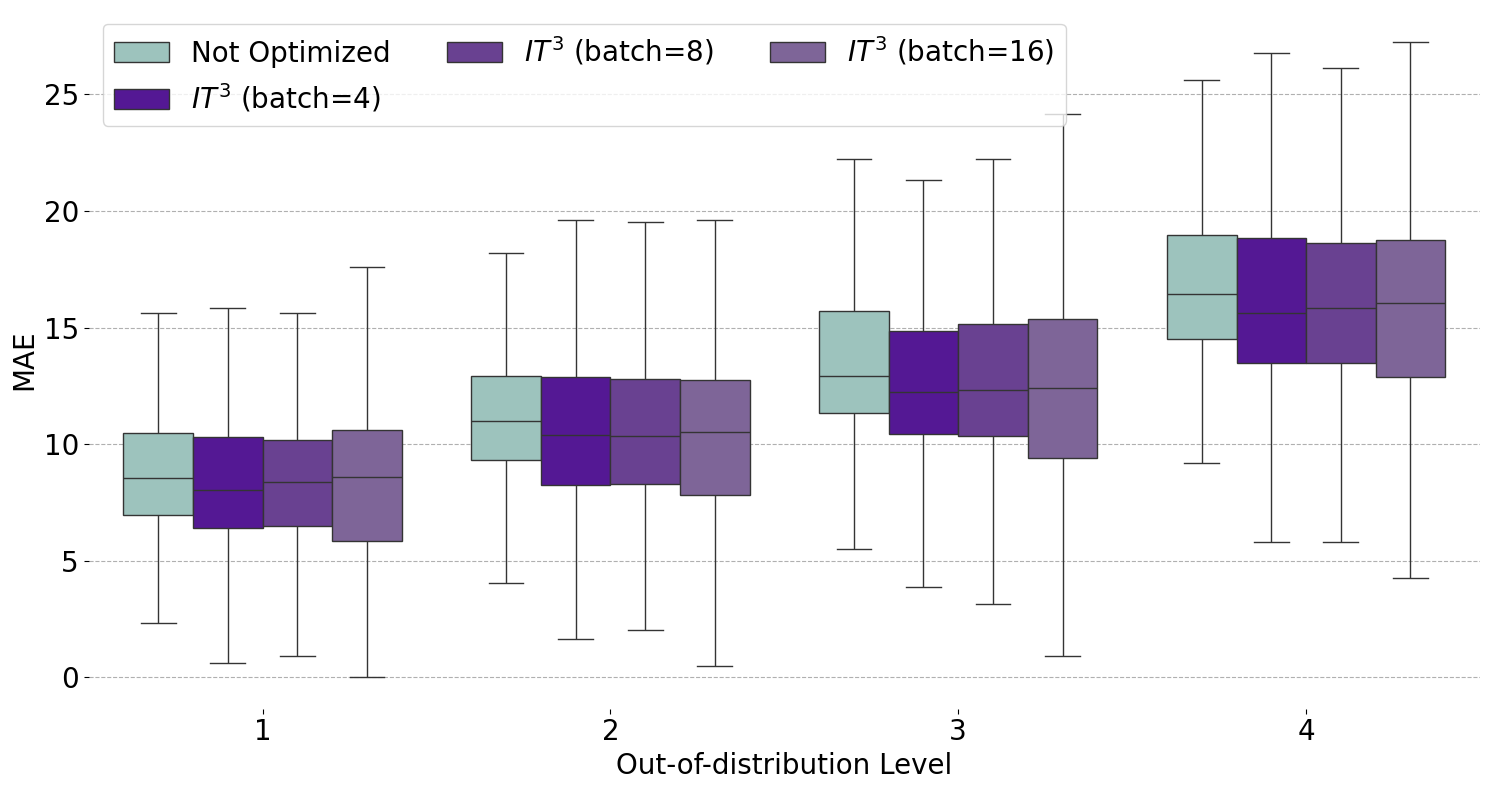

In [36]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# Example extended data (more data points for each combination)

fontsize = 20

data = {
    'Method': ['Not Optimized'] * len(NOT_OPTIMIZED) + ['$IT^3$ (batch=4)'] * len(MAE_4_batch) + ['$IT^3$ (batch=8)'] * len(MAE_8_batch) + ['$IT^3$ (batch=16)'] * len(MAE_16_batch),
    'Out-of-distribution Level': ([1] * 675 + [2] * 676 + [3] * 676 + [4] * 676) * 4,
    'Accuracy': NOT_OPTIMIZED + MAE_4_batch + MAE_8_batch + MAE_16_batch
    # MAE_4_batch + MAE_4_batch + MAE_4_batch
}
# Convert the dictionary to a Pandas DataFrame
df = pd.DataFrame(data)
# Define custom colors for each method
custom_palette = {
    'Not Optimized': '#96CAC1',      # Green
#     'ActMAD (batch=4)': '#022db8e3', # Yellow
#     'ActMAD (batch=8)': '#2647b5e3', # Yellow
#     'ActMAD (batch=16)': '#475fade3', # Yellow
    '$IT^3$ (batch=4)': '#5304a8e3', # Yellow
    '$IT^3$ (batch=8)': '#69349ee3',   # Violet
    '$IT^3$ (batch=16)': '#7e5ca1e3',   # Red
    '$IT^3$ (batch=32)': '#EA8E83'   # Red    
}

# Create the seaborn boxplot with custom colors
plt.figure(figsize=(15, 8))
sns.boxplot(x='Out-of-distribution Level', y='Accuracy', hue='Method', showmeans=False, data=df, palette=custom_palette, showfliers=False)

# Customize the plot
# plt.title('Accuracy by Method and Severity', fontsize=fontsize)
plt.xlabel('Out-of-distribution Level', fontsize=fontsize)
plt.ylabel('MAE', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize, ncol=3)

plt.grid(True, axis='y', linestyle='--') 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()

# Show plot
# plt.show()
# plt.savefig("./viz/age_ittt_results_box_udpated.pdf", format="pdf")